# Interpretating linear forces of 21 particles and 3 interacting types in a reflective circle with dNRI+, PyG dataloaders, and super-GaussiansMask, ignoring the border Rinterior=0.6, MSE vs time in non-reflected dataset

This self-contained notebook generates a dataset of an interacting system, trains a model to learn to predict its trajectories, and extracts the interaction forces.

The dataset consist of 21 particles interacting inside a reflective circle with 3 types of interaction: No-interaction, linear repulsion, linear attraction.
We use PyG dataloaders with implicit batching.

The model is a simplified and optimized version from dNRI paper's code.
The model learns the physics of the bulk and is able to predict further in time.
The loss ignores the reflections from the border by considering only an interior defined by R=0.6.
The Gumbel temperature is decreased through the training.

The model unsupervisedly classifies types of interactions based on the full trajectory.
We add a learnable super-Gaussian to mask long distance interactions.

The model is crafted for interpretability, the edge types show the structure of the forces, and the edge functions allow extracting the functional form of the forces.

In [6]:
import os, matplotlib.pyplot as plt, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.nn import init
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm, trange

In [100]:
params = {
 'load_model': None,
 'load_best_model': False,
 'working_dir': '../results/synth3reflective_21/dnri/seed_3/',
 'gpu': torch.cuda.is_available() and True,
    # data args
 'data_seed': 1, # data loader
 'data_path': '../data/raw/synth3reflective_21/',
 'batch_size': 32,
 'val_batch_size': None,
 'test': False,
 'use_data_norm': True,
 'sparse': False,
    # model args
 'model_seed': 3,
 'pred_delta': False,
 'mode': 'train', # model
 'model_type': 'dnri',
 'num_vars' : 3*7, # num objects
 'input_node_size' : 2, # input node features: velocities
 'n_bound':0,           #+ boundary
 'input_edge_size' : 3, # input edge features: d, versor
 'output_size' : 4,
 'input_time_steps' : 50,
 'num_edge_types': 3, # <--- Interaction types: Attractive, Repulsive, None
 'prior_num_layers': 3,
 'prior_hidden_size': 128,
 'encoder_hidden': 256,
 'encoder_dropout': 0.0,
 'encoder_bn': True,
 'encoder_mlp_hidden': 128,
 'encoder_mlp_num_layers': 3,
 'encoder_rnn_type': 'lstm',
 'encoder_rnn_hidden': 64,
 'encoder_rnn_num_layers': 1,
 'rnn_hidden': 64,
 'teacher_forcing_prior': False,
 'encoder_normalize_mode': None,
 'use_supergaussian': True,
 'decoder_type': 'ref_mlp',
 'decoder_rnn_type': 'gru',
 'decoder_hidden': 256,
 'decoder_hidden_out': 2, #256,
 'decoder_rnn_hidden': None,
 'decoder_msg_hidden': 256,
 'decoder_dropout': 0.0,
 'skip_first': True,
    # loss args
 'nll_loss_type' : 'gaussian',
 'add_uniform_prior': False, # False = only add learned prior
 'no_edge_prior': 0.9,
 'prior_variance': 5e-05,
 'normalize_kl': True,
 'normalize_kl_per_var': False,
 'normalize_nll': True,
 'normalize_nll_per_var': False,
 'kl_coef': 1.0,
    # train args
 'gumbel_temp': 1.5,
 'continue_training': False,
 'num_epochs': 100, #200,
 'lr': 0.0005,
 'lr_decay_factor': 0.5,
 'lr_decay_steps': 100, # 200
 'mom': 0,
 'clip_grad_norm': None,
 'train_hard_sample': True,
      # eval args
 'test_burn_in_steps': 10,
 'error_out_name': 'prediction_errors_%dstep.npy',
 'error_suffix': None,
 'subject_ind': -1,
}

In [10]:
os.makedirs(params['working_dir'], exist_ok=True, )

In [11]:
dvc = DEVICE = torch.device('cuda' if torch.cuda.is_available() and params['gpu'] else 'cpu')
print(dvc)

cuda


In [12]:
def non_diagonal_linear_index(n):
    idx = np.arange(n*(n-1))
    row_idx = idx // (n-1)
    col_idx = idx % (n-1)
    col_idx += (col_idx >= row_idx).astype(int)
    return row_idx, col_idx

# # example usage:
row_idx, col_idx = non_diagonal_linear_index(params['num_vars'])
# print(idx,row_idx, col_idx)  # [0, 1, 0, 1]

# Data generation

In [26]:
# # Make sure to replace this with the directory containing the data files
DATA_PATH='../data/raw/synth3reflective_21'
DATA_PATH='../data/raw/synth3_21'

In [27]:
import argparse

In [28]:
parser = argparse.ArgumentParser()
parser.add_argument('--output_dir', required=True)
parser.add_argument('--num_train', type=int, default=100)
parser.add_argument('--num_val', type=int, default=100)
parser.add_argument('--num_test', type=int, default=100)
parser.add_argument('--num_time_steps', type=int, default=50)
parser.add_argument('--pull_factor', type=float, default=0.1)
parser.add_argument('--push_factor', type=float, default=0.05)

args = parser.parse_args(f'--output_dir {DATA_PATH} --num_train 200 --num_val 200 --num_test 2000 --pull_factor 0.05 --push_factor 0.1'.split())

In [29]:
args

Namespace(output_dir='data/synth3reflective_21', num_train=200, num_val=200, num_test=2000, num_time_steps=50, pull_factor=0.05, push_factor=0.1)

In [ ]:
from numba import njit
from tqdm.auto import trange, tqdm

## Reflections

In [33]:
# from https://github.com/AnDiChallenge/andi_datasets/blob/master/andi_datasets/utils_trajectories.py#L172C5-L248C5
@njit
def circle_line_segment_intersection(circle_center, circle_radius,
                                     pt1, pt2,
                                     full_line=False, tangent_tol=1e-16):
    """
    Find the points at which a circle intersects a line-segment.
    This can happen at 0, 1, or 2 points.

    Parameters
    ----------
    circle_center : tuple
        The (x, y) location of the circle center.
    circle_radius : float
        The radius of the circle.
    pt1 : tuple
        The (x, y) location of the first point of the segment.
    pt2 : tuple
        The (x, y) location of the second point of the segment.
    full_line : bool
        True to find intersections along full line - not just in the segment.
        False will just return intersections within the segment.
    tangent_tol : float
        Numerical tolerance at which we decide the intersections are close enough to consider it a tangent.

    Returns
    -------
    Sequence[Tuple[float, float]]
        A list of length 0, 1, or 2, where each element is a point at which the circle intercepts a line segment.
    """

    (p1x, p1y), (p2x, p2y), (cx, cy) = pt1, pt2, circle_center
    (x1, y1), (x2, y2) = (p1x - cx, p1y - cy), (p2x - cx, p2y - cy)
    dx, dy = (x2 - x1), (y2 - y1)
    dr2 = (dx ** 2 + dy ** 2)
    dr = dr2**.5
    big_d = x1 * y2 - x2 * y1
    discriminant = circle_radius ** 2 * dr2 - big_d ** 2

    if discriminant < 0:  # No intersection between circle and line
        #return []
        return [(float(x),float(x)) for x in range(0)] # empty list with Numba inferable type float
    else:  # There may be 0, 1, or 2 intersections with the segment
        intersections = [
            (cx + ( big_d * dy + sign * (-1 if dy < 0 else 1) * dx * discriminant**.5) / dr2,
             cy + (-big_d * dx + sign * abs(dy) * discriminant**.5) / dr2)
            for sign in ((1, -1) if dy < 0 else (-1, 1))]  # This makes sure the order along the segment is correct
        if not full_line:  # If only considering the segment, filter out intersections that do not fall within the segment
            fraction_along_segment = [(xi - p1x) / dx if abs(dx) > abs(dy) else (yi - p1y) / dy for xi, yi in intersections]
            intersections = [pt for pt, frac in zip(intersections, fraction_along_segment) if 0 <= frac <= 1]
        if len(intersections) == 2 and abs(discriminant) <= tangent_tol:  # If line is tangent to circle, return just one point (as both intersections have same location)
            return [intersections[0]]
        else:
            return intersections

@njit
def seg_to_vec(seg):
    ''' Find the vector given a segment created by two 2D points'''
    return np.array([(seg[0][0]-seg[1][0]), (seg[0][1]-seg[1][1])])

#@njit
def ang_vec(vA, vB):
    ''' Calculates the angle between two vectors'''
    # Get dot prod
    dot_prod = np.dot(vA, vB)
    # Get magnitudes
    magA = np.dot(vA, vA)**0.5
    magB = np.dot(vB, vB)**0.5
    # Get cosine value
    cos_ = dot_prod/magA/magB
    # Get angle in radians and then convert to degrees
    return np.arccos(np.clip(dot_prod/magB/magA, -1, 1)) # in radians [0, pi]

@njit
def get_angle(from_vec, # T, d=2
              to_vec,   # T, d=2
              ):
    x1, y1 = from_vec[...,0], from_vec[...,1]
    x2, y2 = to_vec[...,0], to_vec[...,1]
    dot = x1*x2 + y1*y2      # Dot product between [x1, y1] and [x2, y2]
    det = x1*y2 - y1*x2      # Determinant (cross2d) # 2.53 micros, njit 256 ns
    return np.arctan2(det, dot) # Array of angles in radians, in the range ``[-pi, pi]``
# @njit
# def get_angle(from_vec, # d=2
#               to_vec,   # d=2
#               ):
#     x1, y1 = from_vec[0], from_vec[1]
#     x2, y2 = to_vec[0], to_vec[1]
#     dot = x1*x2 + y1*y2      # Dot product between [x1, y1] and [x2, y2]
#     det = x1*y2 - y1*x2      # Determinant (cross2d) # 2.53 micros, njit 256 ns
#     return np.arctan2(det, dot)

@njit
def ang_line(lineA, lineB):
    ''' Calculates the angle between two lines/segments'''
    # Get vector form
    vA = seg_to_vec(lineA)
    vB = seg_to_vec(lineB)
    return get_angle(vA,vB)
    # return ang_vec(vA, vB)

@njit
def rotate_vec(vec, angle):
    return np.array([ vec[0]*np.cos(angle) + vec[1]*np.sin(angle),
                     -vec[0]*np.sin(angle) + vec[1]*np.cos(angle)])

# from https://github.com/AnDiChallenge/andi_datasets/blob/master/andi_datasets/models_phenom.py#L1117
@njit
def reflect(circle_radius,
            beg,
            end, vel,
            circle_center=np.zeros(2),
            precision_boundary = 1e-14):
        '''
        Given the begining and end of a segment crossing the boundary of a circle,
        calculates the new position considering that boundaries are fully reflective.

        Parameters
        ----------
        circle_radius : float
            Radius of the circle
        beg : tuple
            Position (in 2D) of the begining of the segment
        end : tuple
            Position (in 2D) of the begining of the segment
        circle_center : float
            Center of the circle
        precision_boundary : float
            Small area around the real boundary which is also considered as boundary. For numerical stability

        Returns
        -------
        tuple
            - Reflected position
            - Intersection point

        '''
        beg = np.asarray(beg)#, order='C')  # force to be C contiguous
        # If the begining of the segment is in the exact boundary, no intersection is found.
        # In that case, we bring closer the point to the center of the cercle so it is
        # at a distance 'precision_boundary' from the border
        if np.linalg.norm(circle_center - beg) > (circle_radius - precision_boundary): # This is cheking if the beg is outside circle-precision, right??
            vec = seg_to_vec([circle_center, beg])
            beg = circle_center+\
                 (circle_radius-precision_boundary)*(-vec/np.linalg.norm(vec))

        # find the intersection between the line drawn by the displacement and the circle
        intersect = circle_line_segment_intersection(circle_center = circle_center,
                                                           circle_radius = circle_radius,
                                                           pt1 = beg,
                                                           pt2 = end)[-1]
        intersect = np.array(intersect)

        # Draw lines and calculate angles between radius and begining-intersection
        line1 = [circle_center, intersect]
        line2 = [beg, intersect]
        angle = ang_line(line1, line2)

        # Calculate distance between intersection and end of displacement
        dist_int_end = np.linalg.norm(intersect - end)

        # Create radius vector and calculate the tangent vector
        vec_radius = seg_to_vec([circle_center, intersect])
        tangent = rotate_vec(vec_radius, np.pi*.5)

        # Calculate the angle between the tangent and the displacement vector
        # angle_tan = ang_vec(tangent, seg_to_vec([beg, intersect]))
        angle_tan = get_angle(tangent, seg_to_vec([beg, intersect]))


        # Change sign to correct get the reflection, only if using arccos
        #if angle_tan < np.pi*.5: angle = - angle

        # Rotate the radius vector with the reflection angle and normalize by magnitude
        vec_bounce = rotate_vec(vec_radius, angle)
        vec_bounce /= np.dot(vec_bounce, vec_bounce)**0.5
        # rotate velocity
        vel_bounce = rotate_vec(vel, np.pi+2*angle)

        # Final point is the previous vector times the distance starting at the intersect point
        return intersect+dist_int_end*vec_bounce, vel_bounce, intersect

In [34]:
@njit
def reflective_circle_boundary(rbeg, # N,2
                               rend, R, vend):
    refl_i = (rend**2).sum(-1) > R**2  # mask
    if np.any(refl_i):  # particles outside circle
        refl_i = np.flatnonzero(refl_i)
        # if reflect function would work on arrays
        #rend[refl_i], vend[refl_i], _ = reflect(R,rbeg[refl_i],rend[refl_i],vend[refl_i], precision_boundary=1e-15)
        for i in refl_i:
            rend[i], vend[i], _ = reflect(R,rbeg[i],rend[i],vend[i], precision_boundary=1e-15)
        # reflections: r_refl, v_refl
    return rend, vend

def reflective_circle_boundary_(rbeg, # 2
                               rend, R, vend):
    if (rend**2).sum(-1) > R**2:  # particle outside circle
        # r_refl, v_refl
        rend, vend , _= reflect(R,rbeg,rend,vend, precision_boundary=1e-15)
    return rend, vend

## Generation

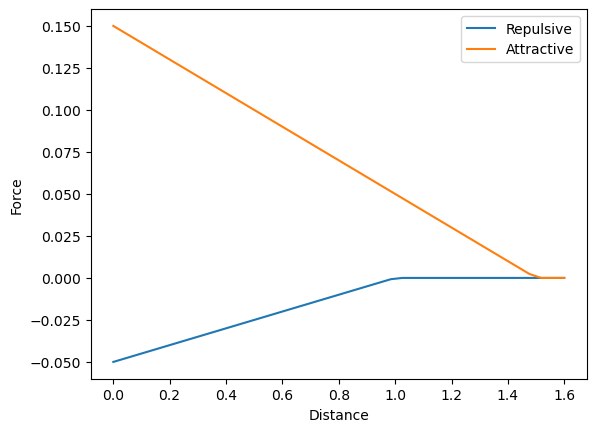

In [13]:
# Linear non-reciprocal Forces
k=0.05
d=np.linspace(0,1.6,40)
dv = -k*(1-d); dv[d>1]=0
plt.plot(d,dv, label='Repulsive');

k=0.1
d=np.linspace(0,1.6,40)
dv = k*(1.5-d); dv[d>1.5]=0
plt.plot(d,dv, label='Attractive');
plt.gca().set( xlabel='Distance', ylabel='Force');
plt.legend();

In [35]:
np.random.seed(1)
reflect = True
all_data = []
all_edges = []
num_sims = args.num_train + args.num_val + args.num_test
n = 7
N = n*3
E = N*(N-1) # Fully connected without self-connection
row_idx, col_idx = non_diagonal_linear_index(N)
idx_1 = np.flatnonzero(np.logical_and(row_idx<=(n-1),col_idx>=(n*2)))
idx_3 = np.flatnonzero(np.logical_and(np.logical_and(n<=row_idx, row_idx<=(2*n-1)),col_idx>=(n*2)))
sf = 1. #.5  # scale factor
Rbox = 3*sf
for sim in trange(num_sims):
    p1_loc = np.random.uniform(-2, -1, size=(n,2))*sf
    p2_loc = np.random.uniform( 1,  2, size=(n,2))*sf
    p3_loc = np.random.uniform(-1,  1, size=(n,2))*sf
    p1_vel = np.random.uniform( 0.05,   0.1, size=(n,2))
    p2_vel = np.random.uniform(-0.05,  -0.1, size=(n,2))
    p3_vel = np.random.uniform(-0.05,  0.05, size=(n,2))

    current_feats = []
    current_edges = []
    for time_step in range(args.num_time_steps):
        current_edge = np.zeros(E)# np.array([0,0,0,0,0,0])
        current_edges.append(current_edge)

        # update vel if interaction
        # compute distances
        dv31 = p3_loc - p1_loc[:,None]       # n,n,2
        d31 = np.linalg.norm(dv31, axis=-1)  # n,n
        for i,d in enumerate(d31.reshape(-1)):  # n*n
            if d<1:
                coef = 1-d
                dir  = dv31.reshape(-1,2)[i]/d  # 2
                p3_vel[i%n] -= args.pull_factor*coef*dir  # 2  # Attractive
                current_edge[idx_1[i]] = 1

        dv32 = p3_loc - p2_loc[:,None]  # n,n
        d32 = np.linalg.norm(dv32, axis=-1) # n,n
        for i,d in enumerate(d32.reshape(-1)):
            if d<1.5:
                coef = 1.5-d
                dir  = dv32.reshape(-1,2)[i]/d
                p3_vel[i%n] += args.push_factor*coef*dir   # Repulsive
                current_edge[idx_3[i]] = 2

        p1_loc_ = p1_loc + p1_vel  # n, 2
        p2_loc_ = p2_loc + p2_vel
        p3_loc_ = p3_loc + p3_vel                          # p = p + v
        # check boundaries
        if reflect:
            p1_loc, p1_vel = reflective_circle_boundary(p1_loc,
                                                        p1_loc_,
                                                        Rbox,
                                                        p1_vel)
            p2_loc, p2_vel = reflective_circle_boundary(p2_loc,
                                                        p2_loc_,
                                                        Rbox,
                                                        p2_vel)
            p3_loc, p3_vel = reflective_circle_boundary(p3_loc,
                                                        p3_loc_,
                                                        Rbox,
                                                        p3_vel)
        else:
            p1_loc = p1_loc_
            p2_loc = p2_loc_
            p3_loc = p3_loc_

        p1_feat = np.concatenate([p1_loc, p1_vel],axis=-1)  # n, 4
        p2_feat = np.concatenate([p2_loc, p2_vel],axis=-1)
        p3_feat = np.concatenate([p3_loc, p3_vel],axis=-1)
        new_feat = np.concatenate([p1_feat, p2_feat, p3_feat],axis=0)    # n*3, 4
        current_feats.append(new_feat)
        # end time loop
    all_data.append(np.stack(current_feats))   # sims, (T, n*3, 4)
    all_edges.append(np.stack(current_edges))  # sims, T, E, C=3

  0%|          | 0/2400 [00:00<?, ?it/s]

In [36]:
all_data  = np.stack(all_data)
all_edges = np.stack(all_edges)

In [37]:
assert np.all(np.isfinite(all_data))

In [38]:
assert np.all(np.isfinite(all_edges))

## Visualize

In [39]:
all_data.shape

(2400, 50, 21, 4)

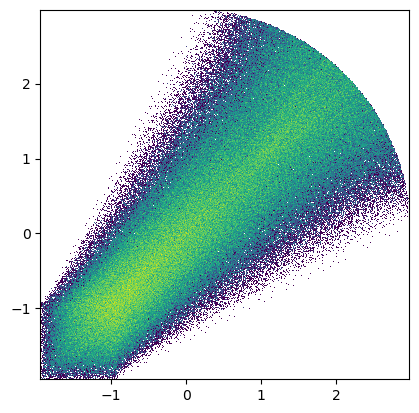

In [40]:
plt.hist2d(all_data[:,:,0:n,0].reshape(-1),
           all_data[:,:,0:n,1].reshape(-1), 500, norm='log');
plt.gca().set_aspect('equal')

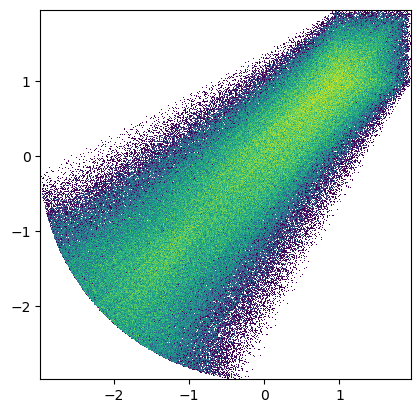

In [41]:
plt.hist2d(all_data[:,:,n:2*n,0].reshape(-1),
           all_data[:,:,n:2*n,1].reshape(-1), 500, norm='log');
plt.gca().set_aspect('equal')

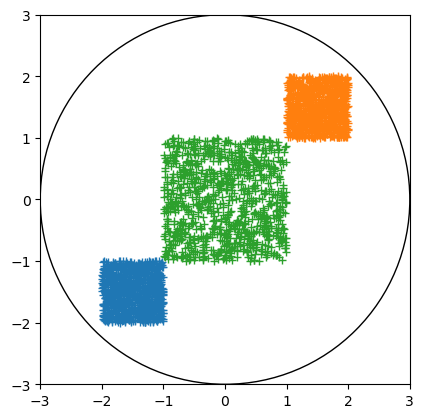

In [42]:
plt.gca().add_artist(plt.Circle((0,0),Rbox,fill=None));
plt.plot(*np.random.uniform(-2, -1, size=(1000,2)).T*sf, '+');
plt.plot(*np.random.uniform(1, 2, size=(1000,2)).T*sf, '+');
plt.plot(*np.random.uniform(-1,1, size=(1000,2)).T*sf, '+');
plt.xlim(-Rbox,Rbox);plt.ylim(-Rbox,Rbox);
plt.gca().set_aspect('equal');

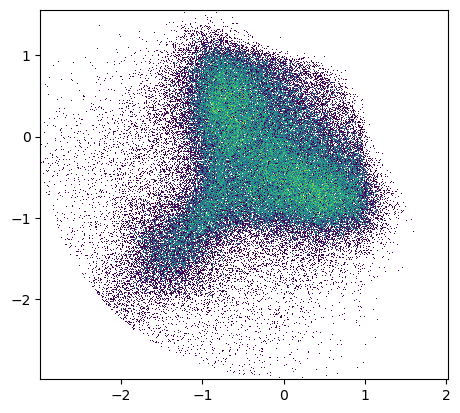

In [43]:
plt.hist2d(all_data[:,:10,2*n:,0].reshape(-1),
           all_data[:,:10,2*n:,1].reshape(-1), 500, norm='log');
plt.gca().set_aspect('equal')

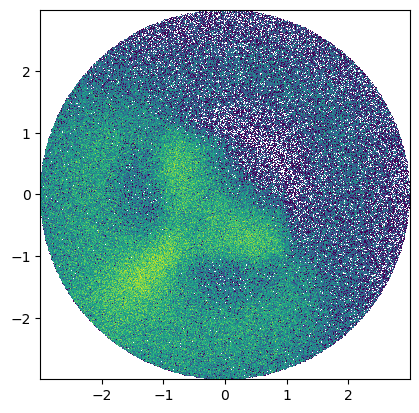

In [44]:
plt.hist2d(all_data[:,:,2*n:,0].reshape(-1),
           all_data[:,:,2*n:,1].reshape(-1), 500, norm='log');
plt.gca().set_aspect('equal')

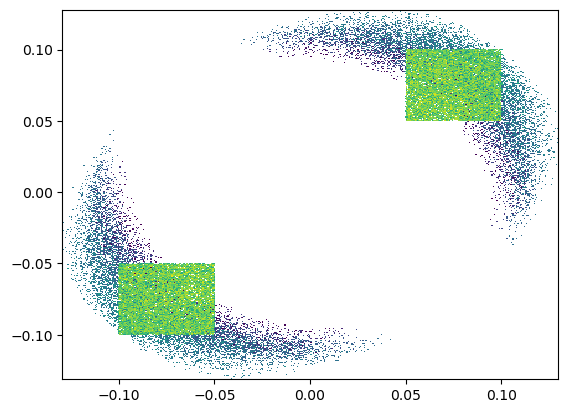

In [45]:
plt.hist2d(all_data[:,:,:2*n,2].reshape(-1),
           all_data[:,:,:2*n,3].reshape(-1), 400, norm='log');

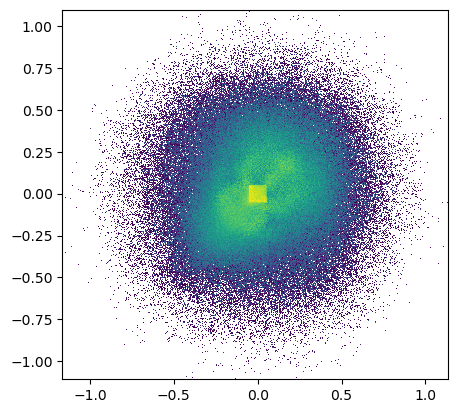

In [46]:
plt.hist2d(all_data[:,:,2*n:,2].reshape(-1),
           all_data[:,:,2*n:,3].reshape(-1), 400, norm='log');
plt.gca().set_aspect('equal')

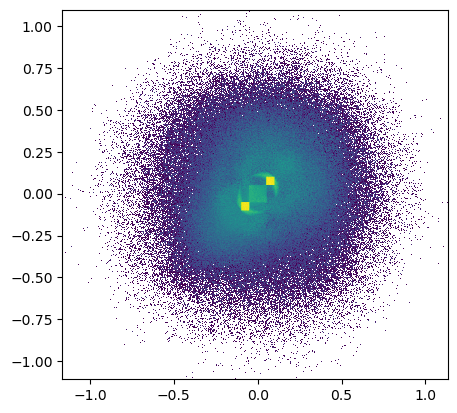

In [47]:
plt.hist2d(all_data[:,:,:,2].reshape(-1),
           all_data[:,:,:,3].reshape(-1), 400, norm='log');
plt.gca().set_aspect('equal')

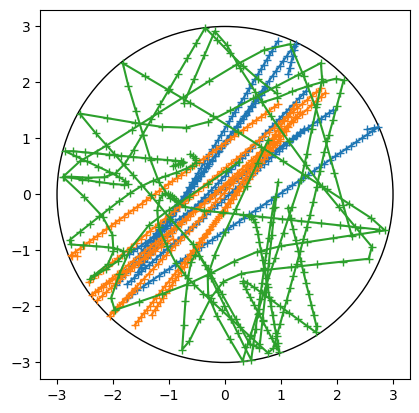

In [48]:
i=0
for j in range(3*n):
    plt.plot(*all_data[i,:,j,:2].T,'+-', c=f'C{j//n}');
plt.gca().add_patch(plt.Circle((0,0),radius=Rbox,fill=None));
plt.gca().set_aspect('equal')

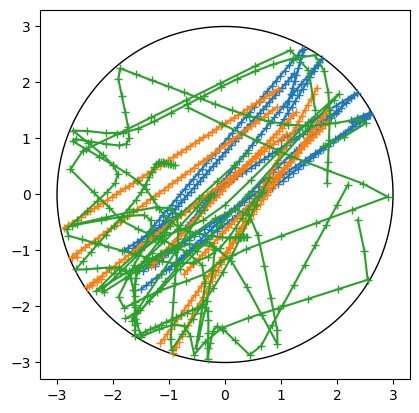

In [49]:
i+=1
for j in range(3*n):
    plt.plot(*all_data[i,:,j,:2].T,'+-', c=f'C{j//n}');
plt.gca().add_patch(plt.Circle((0,0),radius=Rbox,fill=None));
plt.gca().set_aspect('equal')

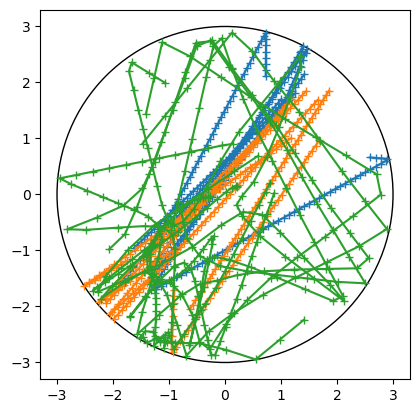

In [50]:
i+=1
for j in range(3*n):
    plt.plot(*all_data[i,:,j,:2].T,'+-', c=f'C{j//n}');
plt.gca().add_patch(plt.Circle((0,0),radius=Rbox,fill=None));
plt.gca().set_aspect('equal')

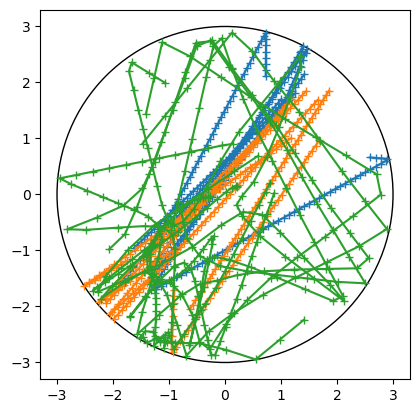

In [51]:
#i+=1
for j in range(3*n):
    plt.plot(*all_data[i,:,j,:2].T,'+-', c=f'C{j//n}');
plt.gca().add_patch(plt.Circle((0,0),radius=Rbox,fill=None));
plt.gca().set_aspect('equal')

## Save

In [52]:
from pathlib import Path

In [53]:
out_dir = Path(args.output_dir)
out_dir.mkdir(parents=True, exist_ok=True)
train_path = out_dir/'train_feats'
val_path   = out_dir/'val_feats'
test_path  = out_dir/'test_feats'

In [54]:
train_data = torch.FloatTensor(all_data[:args.num_train])
val_data   = torch.FloatTensor(all_data[args.num_train:args.num_train+args.num_val])
test_data  = torch.FloatTensor(all_data[args.num_train+args.num_val:])

torch.save(train_data, train_path)
torch.save(val_data, val_path)
torch.save(test_data, test_path)

In [55]:
train_path = out_dir/'train_edges'
val_path   = out_dir/'val_edges'
test_path  = out_dir/'test_edges'
train_edges = torch.FloatTensor(all_edges[:args.num_train])
val_edges   = torch.FloatTensor(all_edges[args.num_train:args.num_train+args.num_val])
test_edges  = torch.FloatTensor(all_edges[args.num_train+args.num_val:])
torch.save(train_edges, train_path)
torch.save(val_edges, val_path)
torch.save(test_edges, test_path)

# Data loading

In [14]:
def seed(seed_val):
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    if torch.cuda.is_available():  torch.cuda.manual_seed_all(seed_val)

In [15]:
def get_dv(data, sparse=True): # data shape= sims,num_particles,T, dim
    assert data.dim()==4, data.dim()
    N = data.shape[1]
    if sparse:
        row_idx, col_idx = s_e.to(data.device), r_e.to(data.device)
    else:
        row_idx, col_idx = non_diagonal_linear_index(N)
    v = data[:,col_idx,:,:2]-data[:,row_idx,:,:2]
    d = torch.sqrt((v*v).sum(-1))[...,None]
    v = v/d
    return torch.cat((d,v),dim=-1)

In [16]:
from torch_geometric.data import Data, Dataset, Batch
from torch_geometric.loader import DataLoader
class SmallSynthDataPyG():
    def __init__(self, data_path, mode, params):
        # paths
        self.data_path = data_path;  self.mode = mode
        if mode in ['train', 'val','test']:
            path = os.path.join(data_path, f'{mode}_feats')
            edge_path = os.path.join(data_path, f'{mode}_edges')

        # load node data into device directly
        self.node_feats = torch.load(path,
                                     map_location=torch.device('cuda' if (params['gpu'] and torch.cuda.is_available())
                                                               else 'cpu'))
        # Transpose data: shape=  sims,T,num_particles, dim -> sims,num_particles,T, dim
        self.node_feats = self.node_feats.transpose(1,2).contiguous()
        # take the latest 50 snapshots
        self.delta_t = 1e-3*100
        self.slice_t = slice_t = slice(-50, None, None)
        self.node_feats = self.node_feats[:,:,slice_t]

        # normalize data
        self.use_data_norm = params.get('use_data_norm',True)
        if self.use_data_norm:
            if params.get('norms', None) is None:
                self._set_norm()
            else:
                print('Using given norm')
                self.loc_max, self.loc_min = params['norms']['loc_max'], params['norms']['loc_min']
                self.vel_max, self.vel_min = params['norms']['vel_max'], params['norms']['vel_min']
                self.norm, self.norm_v = params['norms']['norm'], params['norms']['norm_v']
            self._normalize_data()

        # get edge features from normalized node features
        with torch.device('cuda' if (params['gpu'] and torch.cuda.is_available())
                                                               else 'cpu'):
            self.edge_feats = get_dv(self.node_feats, params['sparse'])

            # set edges
            if params['sparse']: # For instance, if we know particle 0 and 1 do not interact with each other
                send_edges, recv_edges = (s_e.cuda(), r_e.cuda()) if params['gpu'] else (s_e, r_e)
            else: # fully connected
                send_edges, recv_edges = torch.where(torch.ones(params['num_vars']) - torch.eye(params['num_vars']))
                edge2node_mat = nn.Parameter(torch.stack([(recv_edges == i)*1.
                                                      for i in range(params['num_vars'])]),
                                         requires_grad=False)
                self.edge2node_mat = edge2node_mat
        edge_index = torch.stack((send_edges, recv_edges))

        # create Data list containing time series' node and edge feats
        if not params['sparse']:
            self.datalist = [Data(node_feats=n, edge_feats=e,
                                  edge_index=edge_index, edge2node_mat=edge2node_mat)
                         for n,e in zip(self.node_feats,self.edge_feats)]
        else:
            self.datalist = [Data(node_feats=n, edge_feats=e,
                                  edge_index=edge_index)
                         for n,e in zip(self.node_feats,self.edge_feats)]

        # load ground truth edges into CPU for comparison-only
        self.edges = torch.load(edge_path)
        # take the latest 50 snapshots
        self.edges = self.edges[:,slice_t]
        if params['sparse']:
            self.edges = self.edges[...,np.concatenate([np.flatnonzero(np.logical_and(row_idx==i.item(), col_idx==j.item())) for i,j in zip(s_e,r_e)])]


    def _set_norm(self):
        train_data = torch.load(os.path.join(self.data_path, 'train_feats'))
        self.loc_max, self.loc_min = train_data[...,  :2].max(), train_data[...,  :2].min()
        self.vel_max, self.vel_min = train_data[..., 2:4].max(), train_data[..., 2:4 ].min()
        self.norm, self.norm_v = (self.loc_max-self.loc_min)*.5, (self.vel_max-self.vel_min)*.5

    def _normalize_data(self):
        # normalize with the same minmax parameters of the training
        self.node_feats[...,  :2] = (self.node_feats[...,  :2]-self.loc_min) / self.norm  -1
        self.node_feats[..., 2:4] = (self.node_feats[..., 2:4]-self.vel_min) / self.norm_v-1

    def unnormalize(self, data):
        if self.use_data_norm:
            result1 = (data[...,  :2] + 1) * self.norm   + self.loc_min
            result2 = (data[..., 2:4] + 1) * self.norm_v + self.vel_min
            return np.concatenate([result1, result2], axis=-1)
        else:
            return data

    def _normalize_symmetric_data(self):
        # normalize with the same abs max parameters of the training
        train_data = torch.load(os.path.join(self.data_path, 'train_feats'))
        self.loc_max = train_data[...,  :2].abs().max()
        self.vel_max = train_data[..., 2:4].abs().max()
        self.norm, self.norm_v = self.loc_max, self.vel_max

        self.node_feats[...,  :2] = (self.node_feats[...,  :2]+self.loc_max) / self.norm  -1.
        self.node_feats[..., 2:4] = (self.node_feats[..., 2:4]+self.vel_max) / self.norm_v-1.

ds_train = SmallSynthDataPyG(params['data_path'], 'train', params)

In [17]:
params['data_path']

'../data/raw/synth3reflective_21/'

In [18]:
ds_train.norm

tensor(2.9974)

In [19]:
seed(params['data_seed'])
dl_train = DataLoader(ds_train.datalist, batch_size=16, shuffle=True, drop_last=True)

In [20]:
ds_valid = SmallSynthDataPyG(params['data_path'], 'val', params)
dl_valid = DataLoader(ds_valid.datalist, batch_size=16, shuffle=False, drop_last=False)

In [21]:
b = next(iter(dl_train)); b

DataBatch(edge_index=[2, 6720], node_feats=[336, 50, 4], edge_feats=[6720, 50, 3], edge2node_mat=[336, 420], batch=[336], ptr=[17])

In [22]:
b.edge_index

tensor([[  0,   0,   0,  ..., 335, 335, 335],
        [  1,   2,   3,  ..., 332, 333, 334]], device='cuda:0')

In [23]:
b.ptr

tensor([  0,  21,  42,  63,  84, 105, 126, 147, 168, 189, 210, 231, 252, 273,
        294, 315, 336], device='cuda:0')

tensor(2.9974) tensor(1.0245)
tensor(2.9963) tensor(-2.9985)
tensor(1.0540) tensor(-0.9950)


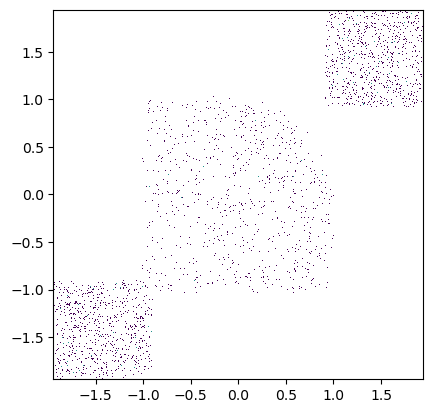

In [37]:
print(ds_train.norm, ds_train.norm_v)
print(ds_train.loc_max, ds_train.loc_min)
print(ds_train.vel_max, ds_train.vel_min)
plt.hist2d(ds_train.node_feats[:,:,:1,0].reshape(-1).cpu().numpy()*ds_train.norm.cpu().numpy(),
           ds_train.node_feats[:,:,:1,1].reshape(-1).cpu().numpy()*ds_train.norm.cpu().numpy(), 500, norm='log');
plt.gca().set_aspect('equal');

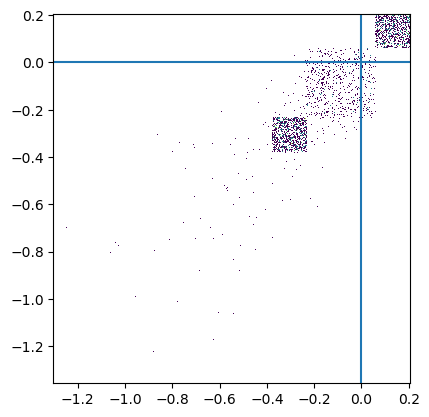

In [38]:
plt.hist2d(ds_train.node_feats[:,:,:1,2].reshape(-1).cpu().numpy()*ds_train.norm.cpu().numpy(),
           ds_train.node_feats[:,:,:1,3].reshape(-1).cpu().numpy()*ds_train.norm.cpu().numpy(), 500, norm='log');
plt.axhline(0);plt.axvline(0);
plt.gca().set_aspect('equal');

## Inspect data

In [39]:
n = ds_train.node_feats.shape[1]//3; n

7

In [40]:
feats = ds_train.node_feats.cpu().transpose(2,1)

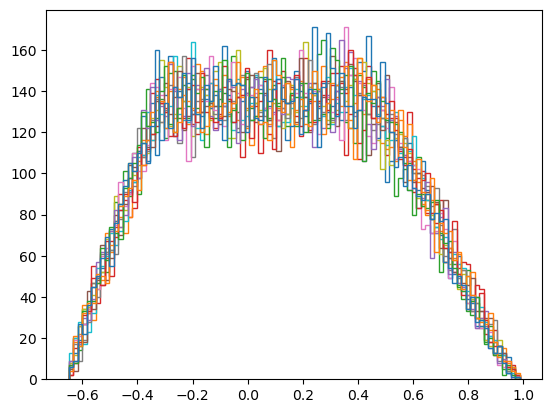

In [41]:
plt.hist(ds_train.node_feats[:,0:n,:,:2].reshape(-1,2*n).cpu().numpy(), 100, histtype='step');

In [42]:
norm = ds_train.norm.numpy()

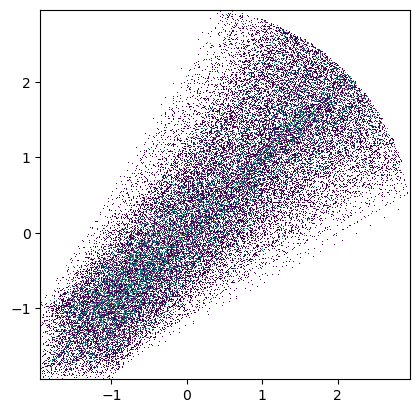

In [43]:
plt.hist2d(feats[:,:,0:n,0].reshape(-1).numpy()*norm,
           feats[:,:,0:n,1].reshape(-1).numpy()*norm, 500, norm='log');
plt.gca().set_aspect('equal');

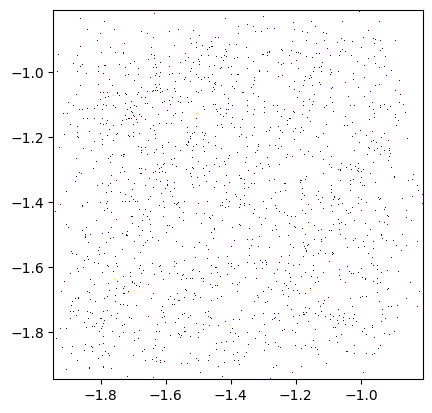

In [44]:
plt.hist2d(feats[:,:2,0:n,0].reshape(-1).numpy()*norm,
           feats[:,:2,0:n,1].reshape(-1).numpy()*norm, 500, norm='log');
plt.gca().set_aspect('equal');

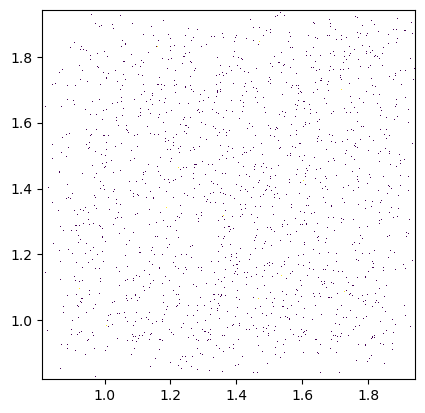

In [45]:
plt.hist2d(feats[:,:2,n:2*n,0].reshape(-1).numpy()*norm,
           feats[:,:2,n:2*n,1].reshape(-1).numpy()*norm, 500, norm='log');
plt.gca().set_aspect('equal');

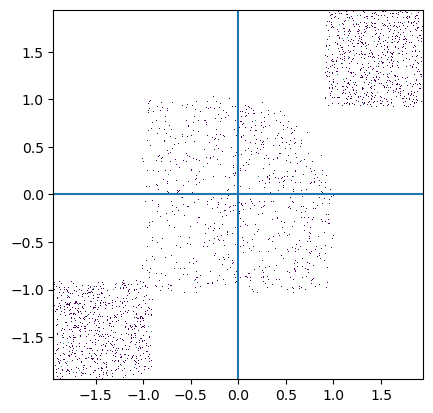

In [46]:
plt.hist2d(feats[:,:1,:,0].reshape(-1).numpy()*norm,
           feats[:,:1,:,1].reshape(-1).numpy()*norm, 500, norm='log');
plt.axhline(0);plt.axvline(0);
plt.gca().set_aspect('equal');

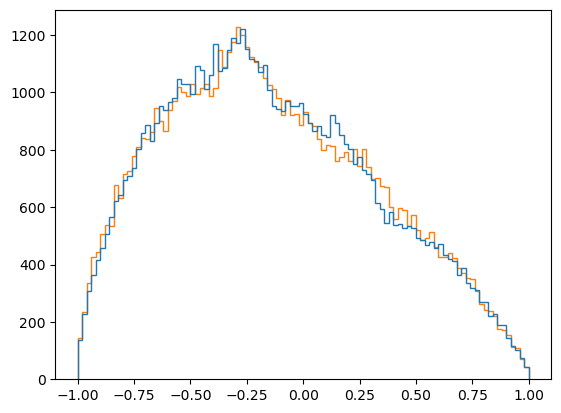

In [67]:
plt.hist(feats[:,:,2*n:,:2].reshape(-1,2).numpy(), 100, histtype='step');

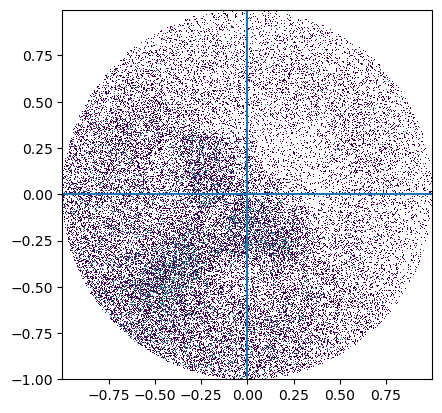

In [48]:
plt.hist2d(feats[:,:,2*n:,0].reshape(-1).numpy(),
           feats[:,:,2*n:,1].reshape(-1).numpy(), 500, norm='log');
plt.axhline(0);plt.axvline(0);
plt.gca().set_aspect('equal');

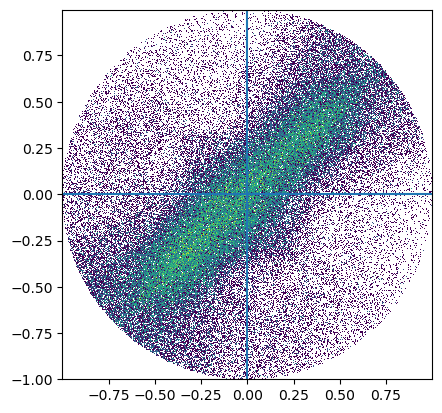

In [49]:
plt.hist2d(feats[:,:,:,0].reshape(-1).numpy(),
           feats[:,:,:,1].reshape(-1).numpy(), 500, norm='log');
plt.axhline(0);plt.axvline(0);
plt.gca().set_aspect('equal');

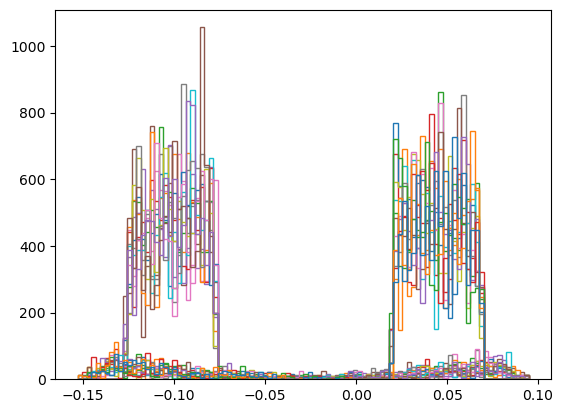

In [50]:
plt.hist(feats[...,0:n*2,2:].reshape(-1,2*n*2).numpy(), 100, histtype='step');

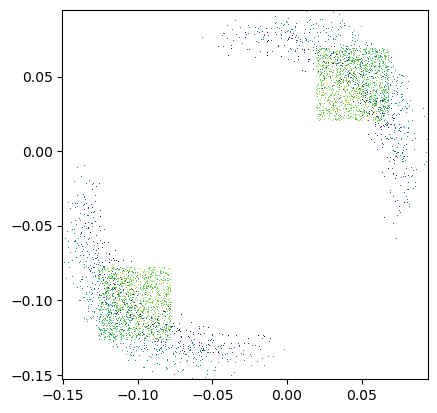

In [51]:
plt.hist2d(feats[:,:,0:2*n,2].reshape(-1).numpy(),
           feats[:,:,0:2*n,3].reshape(-1).numpy(), 400, norm='log');
plt.gca().set_aspect('equal');

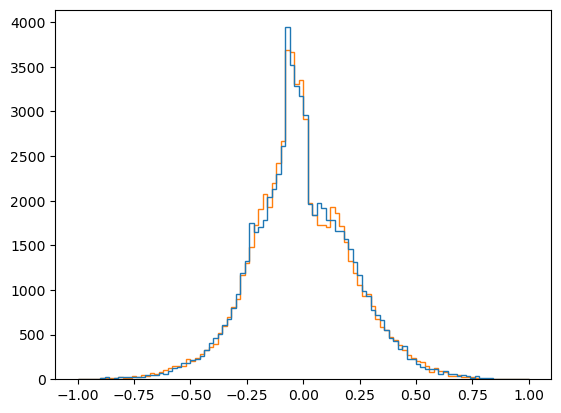

In [52]:
plt.hist(feats[...,2*n:,2:].reshape(-1,2).numpy(), 100, histtype='step');

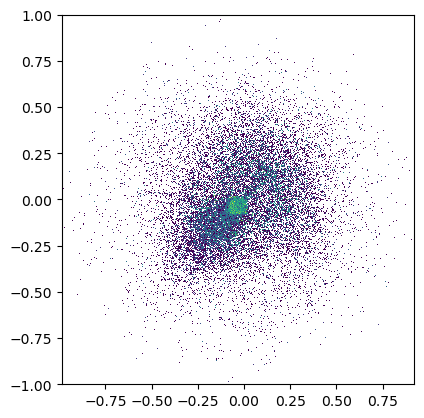

In [53]:
plt.hist2d(feats[:,:,2*n:,2].reshape(-1).numpy(),
           feats[:,:,2*n:,3].reshape(-1).numpy(), 500, norm='log');
plt.gca().set_aspect('equal');

Velocity mean is not centered but in the negatives (positives) for attractive particle 0 (1).

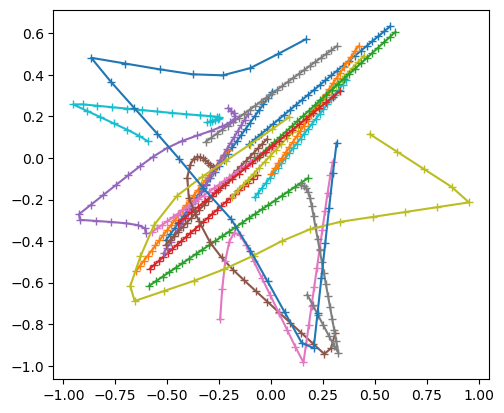

In [54]:
i=0#i+=1
for j in range(n*3):
    plt.plot(*feats[i,:25,j,:2].cpu().T,'+-');
plt.gca().set_aspect('equal');

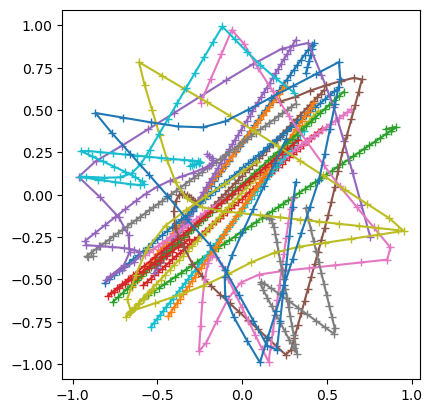

In [55]:
i=0#i+=1
for j in range(n*3):
    plt.plot(*feats[i,:,j,:2].cpu().T,'+-');
plt.gca().set_aspect('equal');

In [56]:
print( f"{((ds_train.edges[:,1:]==0)*1.).mean()*100:.2g}% of non-interacting edges")

97% of non-interacting edges


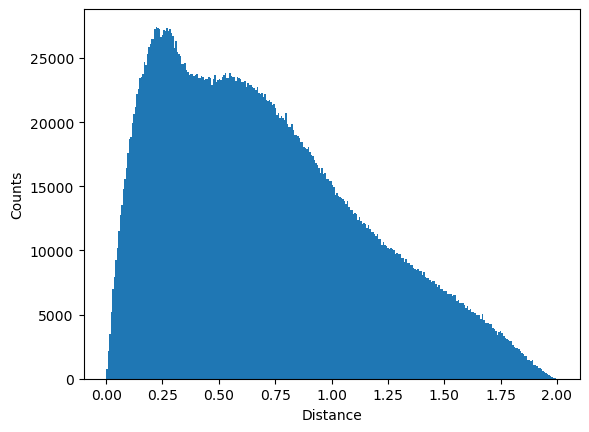

In [57]:
plt.hist(ds_train.edge_feats[...,0].reshape(-1).cpu().numpy(),300);
plt.gca().set( xlabel='Distance', ylabel='Counts');

## How to determine interior? R < maximum bounce from boundary

In [58]:
path = os.path.join(params['data_path'],f'train_feats')
# load node data into device directly
sf = 1
slice_t = slice(None, None, sf)
node_feats = torch.load(path,
                         map_location=torch.device('cuda' if (params['gpu'] and torch.cuda.is_available())
                                                   else 'cpu'))[:,slice_t].transpose(2,1)

In [59]:
circle_radius = 3.
delta_t = 1
circle_center = np.zeros(2)
mask = torch.linalg.norm(node_feats[:,:,:-1,:2]+node_feats[:,:,:-1,2:4]/
              torch.linalg.norm(node_feats[:,:,:-1,2:4],axis=-1, keepdims=True)*
              torch.linalg.norm(node_feats[:,:,1:,2:4],axis=-1, keepdims=True)*
                         delta_t
              ,axis=-1)>circle_radius
idx = torch.nonzero(mask)

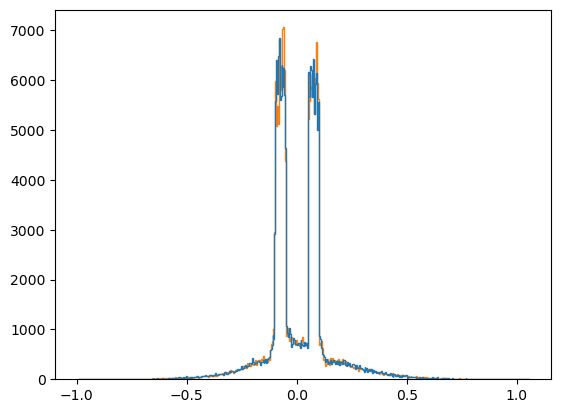

In [60]:
plt.hist(node_feats[:,:,:,2:].reshape(-1,2).cpu().numpy()*delta_t,500, histtype='step', );

In [61]:
mask.shape, idx.shape, node_feats[:,:,:-1,:2].shape

(torch.Size([200, 21, 49]),
 torch.Size([6222, 3]),
 torch.Size([200, 21, 49, 2]))

In [62]:
idx_ = idx+torch.tensor([[0,0,1]], device=idx.device)

In [63]:
assert (idx_[:,-1]>=50).sum()==0

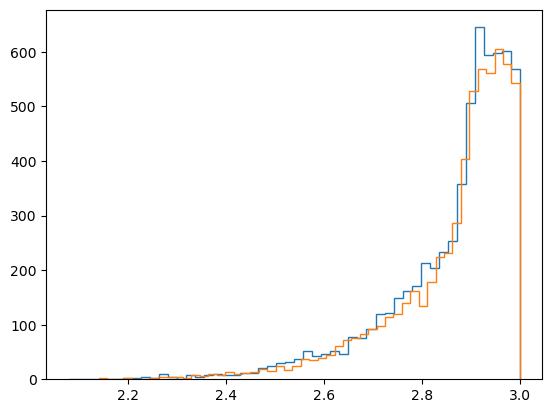

In [64]:
plt.hist(torch.linalg.norm(node_feats[:,:,:-1,:2][mask],axis=-1).cpu().numpy(),50, histtype='step');
plt.hist(torch.linalg.norm(node_feats[:,:,:,:2][*(idx_).T],axis=-1).cpu().numpy(),50, histtype='step');

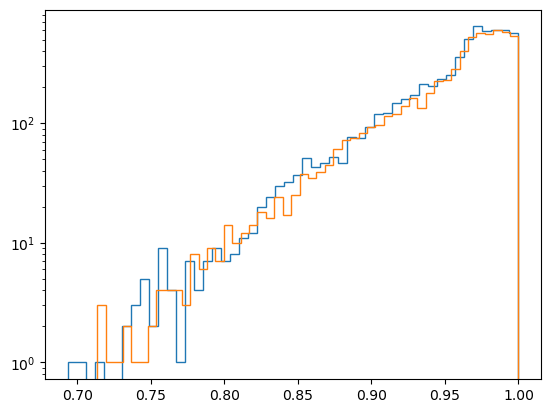

In [65]:
plt.hist(torch.linalg.norm(node_feats[:,:,:-1,:2][mask],axis=-1).cpu().numpy()/circle_radius,50, histtype='step', log=True);
plt.hist(torch.linalg.norm(node_feats[:,:,:,:2][*(idx_).T],axis=-1).cpu().numpy()/circle_radius,50, histtype='step');

In [66]:
# take the maximum velocity and suppose it starts from the border
# then that radius is save
vmax = torch.linalg.norm(node_feats[...,2:4],axis=-1).max()
Rinterior = (1. - vmax*delta_t/circle_radius).item()
print(f'{Rinterior=:.3g}')

Rinterior=0.648


# Model

In [68]:
def init_weights(self):
    for m in self.modules():
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight.data)
            m.bias.data.fill_(0.1)
        elif isinstance(m, nn.BatchNorm1d):
            m.weight.data.fill_(1)
            m.bias.data.zero_()

def set_dropout(self,p):
    for m in self.modules():
        if isinstance(m, nn.Dropout):
            m.p = p

In [69]:
class RefNRIMLP(nn.Module):
    """Two-layer fully-connected ELU net with batch norm."""

    def __init__(self, n_in, n_hid, n_out, do_prob=0., use_bn=True):
        super(RefNRIMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(n_in, n_hid),
            nn.ELU(inplace=True),
            nn.Dropout(do_prob),
            nn.Linear(n_hid, n_out),
            nn.ELU(inplace=True)
        )
        self.bn = nn.BatchNorm1d(n_out) if use_bn else None

        init_weights(self)

    def batch_norm(self, inputs):
        orig_shape = inputs.shape
        x = inputs.view(-1, inputs.size(-1))
        x = self.bn(x)
        return x.view(orig_shape)

    def forward(self, inputs):
        # Input shape: [num_sims, num_things, num_features]
        x = self.model(inputs)
        return self.batch_norm(x) if self.bn is not None else x

In [70]:
# from torch.nn.functional import gumbel_softmax

In [71]:
# redefine gumbel_softmax to avoid Gumbel noise in the inference
# effectively sampling from a categorical distribution
from torch.overrides import handle_torch_function,has_torch_function_unary
import warnings, torch
def gumbel_softmax (
    logits: torch.Tensor,
    tau: float = 1,
    hard: bool = False,
    eps: float = 1e-10,
    dim: int = -1,
    training: bool = True,
) -> torch.Tensor:
    if has_torch_function_unary(logits):
        return handle_torch_function(
            gumbel_softmax, (logits,), logits, tau=tau, hard=hard, eps=eps, dim=dim
        )
    if eps != 1e-10:
        warnings.warn("`eps` parameter is deprecated and has no effect.")

    gumbels = (
        -torch.empty_like(logits, memory_format=torch.legacy_contiguous_format)
        .exponential_()
        .log()
    )  # ~Gumbel(0,1)
    if training:
        gumbels = (logits + gumbels) / tau  # ~Gumbel(logits,tau)
    else:
        gumbels = logits / tau
    y_soft = gumbels.softmax(dim)

    if hard:
        # Straight through.
        index = y_soft.max(dim, keepdim=True)[1]
        y_hard = torch.zeros_like(
            logits, memory_format=torch.legacy_contiguous_format
        ).scatter_(dim, index, 1.0)
        ret = y_hard - y_soft.detach() + y_soft
    else:
        # Reparametrization trick.
        ret = y_soft
    return ret

## Learnable super-Gaussian

In [72]:
def getattrs(o,l): return *[getattr(o,n) for n in l],

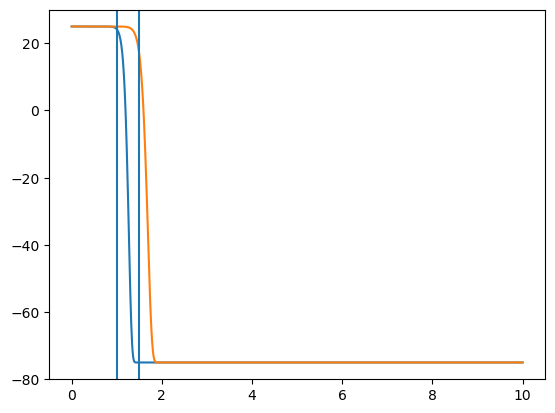

In [73]:
x = torch.linspace(0,10,1000)/ds_train.norm
sigma = torch.tensor(0.3)
beta = torch.tensor(10)
plt.plot(x*ds_train.norm,(torch.exp(-1.*torch.pow(torch.square(x) / (2. * torch.square(sigma)), beta))-.75)*100);
sigma = torch.tensor(0.4)
beta = torch.tensor(10)
plt.plot(x*ds_train.norm,(torch.exp(-1.*torch.pow(torch.square(x) / (2. * torch.square(sigma)), beta))-.75)*100);
plt.axvline(1.5);plt.axvline(1);

In [74]:
# modified from https://github.com/DeepTrackAI/deeplay/blob/develop/deeplay/components/gnn/mpn/ldw.py#L9
class LearnableDistanceMask(nn.Module):
    def __init__(
        self,
        C: int,  # number of classes (-1 if skip_first)
        sigma: list[float] = [.3,.4],
        beta:  list[float] = [10.],
        sigma_limit  = [1e-3, 1.],
        beta_limit   = [1.,   100.],
        skip_first   = True,
    ):
        super().__init__()

        self.C = C
        self.sigma_limit = sigma_limit
        self.beta_limit  = beta_limit
        self.skip_first = skip_first

        self.sigma = nn.Parameter(torch.tensor(sigma*C if len(sigma)==1 else sigma))
        self.beta  = nn.Parameter(torch.tensor(beta*C  if len(beta)==1 else beta))
        assert len(self.sigma)==C
        assert len(self.beta) ==C

    def forward(self, distance # BE, 1
               ):
        sigma = torch.clamp(self.sigma, *self.sigma_limit)
        beta  = torch.clamp(self.beta,  *self.beta_limit)
        if self.skip_first:
            edge_weights = torch.zeros(*distance.shape[:-1],self.C+1,
                                       device=distance.device)
            edge_weights[...,1:] = torch.exp(-1.*torch.pow(torch.square(distance) / (2. * torch.square(sigma)), beta)) # BE,C-1
            return edge_weights  # [BE, C]
        else:
            return torch.exp(-1.*torch.pow(torch.square(distance) / (2. * torch.square(sigma)), beta))  # BE,C

## Encoder

In [76]:
class DNRI_Encoder(nn.Module):
    def __init__(self, params,**kwargs):
        super(DNRI_Encoder, self).__init__()
        self.num_vars = num_vars = params['num_vars']  # 3
        self.num_edges = params['num_edge_types']  # 2
        self.skip_first = skip_first = params['skip_first']  # True
        self.sparse = sparse = params['sparse']
        if not self.sparse: self.edge2node_mat = kwargs['edge2node_mat']
        self.separate_prior_encoder = params.get('separate_prior_encoder', False) #
        use_bn = params['encoder_bn']
        dropout = params['encoder_dropout']  # 0

        inp_node_size = params['input_node_size']    #  4
        n_bound = params.get('n_bound',0)
        inp_edge_size = params['input_edge_size']
        hidden_size = params['encoder_hidden']  # 256
        rnn_hidden_size = params['encoder_rnn_hidden']  # 64
        if rnn_hidden_size is None:  rnn_hidden_size = hidden_size
        self.rnn_hidden_size = rnn_hidden_size
        rnn_type = params['encoder_rnn_type']  # 'lstm'
        self.rnn_num_layers = rnn_num_layers = params.get('encoder_rnn_num_layers', 1)

        self.mlp1 = RefNRIMLP(inp_node_size*2, hidden_size, hidden_size, dropout, use_bn=use_bn)
        self.mlp1_e = RefNRIMLP(inp_edge_size, hidden_size, hidden_size, dropout, use_bn=use_bn)
        self.mlp2 = RefNRIMLP(3*hidden_size, hidden_size, hidden_size, dropout, use_bn=use_bn)
        self.mlp3 = RefNRIMLP(  hidden_size, hidden_size, hidden_size, dropout, use_bn=use_bn)
        self.mlp4 = RefNRIMLP(3*hidden_size, hidden_size, hidden_size, dropout, use_bn=use_bn)

        if rnn_type == 'lstm': # True
            self.bi_rnn = nn.LSTM(hidden_size, rnn_hidden_size, num_layers=rnn_num_layers, batch_first=True, bidirectional=True)
        elif rnn_type == 'gru':
            self.bi_rnn = nn.GRU (hidden_size, rnn_hidden_size, num_layers=rnn_num_layers, batch_first=True, bidirectional=True)

        # encoder out
        out_hidden_size = 2*rnn_hidden_size  # 128
        num_layers = params['encoder_mlp_num_layers']  # 3
        if num_layers == 1: # False
            self.encoder_fc_out = nn.Linear(out_hidden_size, self.num_edges)
        else:
            tmp_hidden_size = params['encoder_mlp_hidden'] # 128
            layers = [nn.Linear(out_hidden_size, tmp_hidden_size), nn.ELU(inplace=True)]
            for _ in range(num_layers - 2):
                layers.append(nn.Linear(tmp_hidden_size, tmp_hidden_size))
                layers.append(nn.ELU(inplace=True))
            layers.append(nn.Linear(tmp_hidden_size, self.num_edges))
            self.encoder_fc_out = nn.Sequential(*layers)

        # prior out
        num_layers = params['prior_num_layers'] # 3
        if num_layers == 1: # False
            self.prior_fc_out = nn.Linear(rnn_hidden_size, self.num_edges)
        else:
            tmp_hidden_size = params['prior_hidden_size'] # 128
            layers = [nn.Linear(rnn_hidden_size, tmp_hidden_size), nn.ELU(inplace=True)]
            for _ in range(num_layers - 2):
                layers.append(nn.Linear(tmp_hidden_size, tmp_hidden_size))
                layers.append(nn.ELU(inplace=True))
            layers.append(nn.Linear(tmp_hidden_size, self.num_edges))
            self.prior_fc_out = nn.Sequential(*layers)

        init_weights(self)

    def node2edge(self, node_embeddings, edge_index):
        # Input size: [batch*num_vars, num_timesteps, embed_size]
        return torch.cat([node_embeddings[edge_index[0]],
                          node_embeddings[edge_index[1]]],
                         dim=-1)

    def edge2node(self, edge_embeddings, BN,  # [batch*num_edges, timesteps, embed_size]
                  edge_index=None, sparse=True):
        # BN is Batch*Nodes_num, not edges
        old_shape = edge_embeddings.shape
        device = next(self.parameters()).device
        node_aggregate = torch.zeros((BN, *old_shape[1:]), # B*N, T, H
                                     device=device)
        if sparse:
            if len(edge_embeddings.shape) == 3:
                node_aggregate = node_aggregate.scatter_add(dim=0, # nodes dim
                                     index=edge_index[1].view(-1,1,1).expand(-1, *old_shape[1:]),
                                     src=edge_embeddings,)
            else: # single_timestep
                 node_aggregate = node_aggregate.scatter_add(dim=0, # nodes dim
                                     index=edge_index[1].view(-1,1).expand(-1, old_shape[-1]),
                                     src=edge_embeddings,)
        else: # fully connected
            if len(edge_embeddings.shape) == 3:
                tmp_embeddings = edge_embeddings.view(old_shape[0], old_shape[1], -1)
                node_aggregate = torch.matmul(self.edge2node_mat, tmp_embeddings).view(old_shape[0], -1, *old_shape[2:])
            else:
                node_aggregate = torch.matmul(self.edge2node_mat, edge_embeddings)
        return node_aggregate/(self.num_vars-1)

    def forward(self,
                node_feats,
                edge_feats,
                edge_index,
               ):
        # Inputs is shape [batch*num_vars, num_timesteps,  input_size]
        x = node_feats  # B*N, T, 2
        BN = node_feats.shape[0]
        num_timesteps = node_feats.size(1)
        # x = node_feats.transpose(-3, -2).contiguous()  # already done in dataset creation
        x = self.mlp1(x)  # 2-layer ELU net per node        # B*N, T, H
        x = self.node2edge(x, edge_index)                   # B*E, T, 2H
        x_ = self.mlp1_e(edge_feats)                        # B*E, T, H
        x = self.mlp2(torch.cat((x,x_), dim=-1))            # B*E, T, H
        x_skip = x
        x = self.edge2node(x, BN, edge_index)               # B*N, T, 2H
        x = self.mlp3(x)                                    # B*N, T, H
        x = self.node2edge(x, edge_index)                   # B*E, T, H
        x = torch.cat((x, x_skip), dim=-1)  # Skip connection  # B*E, T, 2H
        x = self.mlp4(x)                                    # B*E, T, H


        # At this point, x should be [batch*num_edges, num_timesteps, hidden_size]
        # RNN aggregation
        old_shape = x.shape # B*E, T, H
        # x = x.contiguous().view(-1, *old_shape[-2:]) # B*E, T, H # already done with implicit batching
        # forward_x, prior_state = self.forward_rnn(x)
        # timesteps = old_shape[2]
        # reverse_x = x.flip(1)
        # reverse_x, _ = self.reverse_rnn(reverse_x)
        # reverse_x = reverse_x.flip(1)

        x, (h, c) = self.bi_rnn(x)  # B*E, T, 2*H; D*num_layers, B, H
        forward_x = x[...,:self.rnn_hidden_size]  # B*E,T,H
        prior_state = (h,c) # h[:self.rnn_num_layers], c[:self.rnn_num_layers]           # (D*num_layers, B*E,H)

        #x: [batch*num_edges, num_timesteps, hidden_size]
        prior_result = self.prior_fc_out(forward_x)  # B*E,T,C
        #.view(*old_shape[:-1], self.num_edges).transpose(-3,-2).contiguous()
        # combined_x = torch.cat([forward_x, reverse_x], dim=-1)
        # encoder_result = self.encoder_fc_out(bi_x)  # B*E,T,C
        encoder_result = self.encoder_fc_out(x)  # B*E,T,C
        #.view(*old_shape[:-1], self.num_edges).transpose(-3,-2).contiguous()
        return prior_result, encoder_result, prior_state
                # B*E, T, C

    def single_step_forward(self,
                            node_feats,
                            edge_feats,
                            edge_index,
                            prior_state):
        # Inputs is shape [batch*num_vars, input_size]
        x = node_feats                                      # B*N, 2
        BN = node_feats.shape[0]
        x = self.mlp1(x)  # 2-layer ELU net per node        # B*N, H
        x = self.node2edge(x, edge_index)                   # B*E, 2H
        x_ = self.mlp1_e(edge_feats)                        # B*E, H
        x = self.mlp2(torch.cat((x,x_), dim=-1))            # B*E, H
        x_skip = x
        x = self.edge2node(x, BN, edge_index)               # B*N, 2H
        x = self.mlp3(x)                                    # B*N, H
        x = self.node2edge(x, edge_index)                   # B*E, H
        x = torch.cat((x, x_skip), dim=-1)  # Skip connection  # B*E, 2H
        x = self.mlp4(x)                                    # B*E, H


        # At this point, x should be [batch*num_edges, hidden_size]
        # RNN aggregation
        old_shape = x.shape # B*E, H
        x  = x.contiguous().view(-1, 1, old_shape[-1])   # B*E, 1, H


        x, (h, c) = self.bi_rnn(x,prior_state)  # B*E, 1, 2*H; D*num_layers, B, H
        forward_x = x[...,:self.rnn_hidden_size]  # B*E,1,H
        prior_state = (h, c) #h[:self.rnn_num_layers], c[:self.rnn_num_layers]           # (num_layers, B*E,H)
        prior_result = self.prior_fc_out(forward_x).view(*old_shape[:-1], self.num_edges).contiguous() # B*E, C

        return prior_result, prior_state

## Decoder

In [77]:
class DNRI_MLP_Decoder(nn.Module):   # this is the Markovian decoder
    def __init__(self, params, **kwargs):
        super(DNRI_MLP_Decoder, self).__init__()
        self.num_vars = num_vars = params['num_vars']  # 3
        self.pred_delta = params.get('pred_delta',False)
        self.sparse = sparse = params['sparse']
        if not self.sparse: self.edge2node_mat = kwargs['edge2node_mat'].T
        edge_types = params['num_edge_types']  # 2
        self.n_bound = params.get('n_bound',0)
        n_hid   = params['decoder_hidden']  # 256
        msg_hid = params['decoder_hidden']  # 256
        self.msg_out_size = msg_out = params['decoder_hidden_out'] # 2
        self.skip_first_edge_type = skip_first = params['skip_first']  # True
        inp_node_size  = n_in_node = params['input_node_size']  # 4
        inp_edge_size  = params['input_edge_size']  # 4
        out_size = params['output_size']
        self.dropout_prob = do_prob = params['decoder_dropout']  # 0.0

        self.edge_functions = nn.ModuleList([
            nn.Sequential(nn.Linear(1, msg_hid),nn.ReLU(),   # (B,E,H)
                          nn.Dropout(p=do_prob),
                          nn.Linear(msg_hid, msg_hid),nn.ReLU(),   # (B,E,H)
                          nn.Dropout(p=do_prob),
                          nn.Linear(  msg_hid, msg_out) # <-- msg_out = d for interpretability
                          # ,nn.ReLU() # <-- key to learn
                         )   # (B,E,O)
            for _ in range(edge_types if not skip_first else edge_types -1)
        ])
        self.node_function = nn.Sequential(
            nn.Linear(inp_node_size + msg_out+self.n_bound, n_hid), nn.ReLU(), nn.Dropout(p=do_prob),
            nn.Linear(            n_hid, n_hid), nn.ReLU(), nn.Dropout(p=do_prob),
            nn.Linear(            n_hid, out_size))

        print('Using learned interaction net decoder.')


    def get_initial_hidden(self, inputs):  return None

    def forward(self, inputs,  # BN,F; BE,V; 2,BE
                hidden,
                edges,         # BE,C
               ):
        # TODO hidden is not used!! So, it can handle all times at once.
        node_feats_, edge_feats, edge_index = inputs
        # BN,F;      BE,V;       2,BE
        node_feats = node_feats_[...,2:]  # BE,2; # velocities

        # Node2edge
        pre_msg = edge_feats[...,0:1]  # (B*E,1) # distances

        all_msgs = torch.zeros(pre_msg.size(0),self.msg_out_size,   # (B*E,O)
                               device=node_feats.device)

        # To exlude one edge type, simply offset range by 1
        start_idx = 1 if self.skip_first_edge_type else 0

        norm = 1  # TODO sqrt(E)
        # Run separate MLP for every edge type
        for i in range(len(self.edge_functions)):
            msg = self.edge_functions[i](pre_msg)*edge_feats[...,1:]
            msg = msg*edges[..., i+start_idx:i+start_idx+1]  # <-- Encoder z edges predictions
            # normed sum message from one edge type into all messages
            all_msgs += msg/norm     # (B*E,O)

        # Aggregate all msgs to receiver
        if self.sparse:
            agg_msgs = torch.zeros(node_feats.shape[0], all_msgs.shape[-1], #  B*N, H
                              device=all_msgs.device
                         ).scatter_add(
                             dim=0, # node dimension
                             index=edge_index[1].view(-1,1).expand(-1, all_msgs.shape[-1]), # repeat for each feature
                             src=all_msgs,)  # [BN, H]
        else:
            all_msgs = all_msgs.reshape(-1,self.edge2node_mat.shape[0],all_msgs.shape[-1])
            agg_msgs = all_msgs.transpose(-2, -1).matmul(self.edge2node_mat).transpose(-2, -1)
            agg_msgs = agg_msgs.reshape(-1,agg_msgs.shape[-1])

        agg_msgs = agg_msgs.contiguous()   # (B*N,O)

        # Skip connection
        aug_inputs = torch.cat([node_feats, agg_msgs], dim=-1) # B*N,F+O

        # NODE FUNCTION--------------------------------
        pred = self.node_function(aug_inputs)   # B*N,O

        # Predict position/velocity difference
        return (node_feats_ + pred, None) if not self.pred_delta else (pred, None)

## dNRI

In [78]:
from torch_geometric.utils import to_dense_batch
class DNRI(nn.Module):
    def __init__(self, params, **kwargs):
        super(DNRI, self).__init__()
        self.sparse = sparse = params['sparse']
        # Model Params
        self.num_vars = params['num_vars']  # 21
        self.num_edges = params['num_edge_types']  # 2
        self.pred_delta = params.get('pred_delta',False)

        self.encoder = DNRI_Encoder(params, ) if self.sparse else DNRI_Encoder(params, **kwargs)
        decoder_type = params.get('decoder_type', None)  # ref_mlp
        if decoder_type == 'ref_mlp':
            self.decoder = DNRI_MLP_Decoder(params, ) if self.sparse else DNRI_MLP_Decoder(params, **kwargs)
        else:
            # recurrent decoder with hidden state
            self.decoder = DNRI_Decoder(params,) if self.sparse else DNRI_Decoder(params, **kwargs)
        self.num_edge_types = params.get('num_edge_types')  # 2
        self.skip_first = skip_first = params['skip_first']  # True
        self.Rbox = torch.tensor(params.get('Rbox', 3.0), device=dvc)
        self.n_bound = params.get('n_bound',0)

        # Training params
        self.gumbel_temp = params.get('gumbel_temp')  # 0.5
        self.train_hard_sample = params.get('train_hard_sample')  # False
        self.teacher_forcing_steps = params.get('teacher_forcing_steps', -1)  # -1

        self.normalize_kl = params.get('normalize_kl', False)  # True
        self.normalize_kl_per_var = params.get('normalize_kl_per_var', False) # False
        self.normalize_nll = params.get('normalize_nll', False)  # True
        self.normalize_nll_per_var = params.get('normalize_nll_per_var', False) # False
        self.kl_coef = params.get('kl_coef', 1.)  # 1.0
        self.prior_coef = params.get('prior_coef', 1.)
        self.nll_loss_type = params.get('nll_loss_type', 'crossent')  # gaussian
        self.prior_variance = params.get('prior_variance')   # 5e-05
        self.timesteps = params.get('timesteps', 0)  #
        self.burn_in_steps = params.get('train_burn_in_steps') #
        self.teacher_forcing_prior = params.get('teacher_forcing_prior', False) # False
        self.val_teacher_forcing_steps = params.get('val_teacher_forcing_steps', -1) # -1
        self.add_uniform_prior = params.get('add_uniform_prior')

        self.Rinterior = params.get('Rinterior', 0.6)
        self.use_supergaussian = params.get('use_supergaussian', True)
        if self.use_supergaussian:
            self.super_gaussians = LearnableDistanceMask(C=self.num_edges-1 if skip_first else self.num_edges,
                                                          skip_first=skip_first)

        if self.add_uniform_prior:
            if params.get('no_edge_prior') is not None: # 0.9
                prior = torch.full((self.num_edge_types,),(1 - params['no_edge_prior'])/(self.num_edge_types - 1)) # 0.1/1
                prior[0] = params['no_edge_prior'] # 0.9
                log_prior = torch.log(prior) # log([0.9,0.1])
                log_prior = torch.unsqueeze(log_prior, 0)
                if params['gpu']:  log_prior = log_prior.cuda(non_blocking=True)
                self.log_prior = log_prior
                print("USING NO-EDGE PRIOR: ",prior, self.log_prior) # <-----
            else:
                print("USING UNIFORM PRIOR")
                prior = torch.full((self.num_edge_types,), 1.0/self.num_edge_types)
                log_prior = torch.log(prior)
                log_prior = torch.unsqueeze(log_prior, 0)
                if params['gpu']:  log_prior = log_prior.cuda(non_blocking=True)
                self.log_prior = log_prior

    def single_step_forward(self, inputs, # BN,F; BE,V; 2,BE
                            decoder_hidden,
                            edge_logits,  # BE,C
                            hard_sample):
        # sample edges at each timestep
        edges = gumbel_softmax(edge_logits,
                               tau=self.gumbel_temp,
                               hard=hard_sample,
                               training=self.training,
                              )  # BE,C
        # mask with learnable supergaussian based on distance
        mask_type = self.super_gaussians(inputs[1][...,0:1])  # distance
        edges = edges * mask_type  # zero-out type of edges beyond distance
        predictions, decoder_hidden = self.decoder(inputs, decoder_hidden, edges)  # BN,O; None
        return predictions, decoder_hidden, edges

    def forward(self, inputs, is_train=False, teacher_forcing=True,
                      return_edges=False, return_logits=False, use_prior_logits=False):
        node_feats, edge_feats, edge_index = getattrs(inputs,['node_feats','edge_feats', 'edge_index'])
        decoder_hidden = self.decoder.get_initial_hidden(node_feats) # None
        num_time_steps = node_feats.size(1)
        all_edges = []
        all_predictions = []
        all_priors = []
        hard_sample = (not is_train) or self.train_hard_sample  # False
        prior_logits, posterior_logits, _ = self.encoder(node_feats[:,:-1], edge_feats[:,:-1], edge_index)
        for step in range(num_time_steps-1):
            current_inputs = (node_feats[:, step], edge_feats[:,step], edge_index)
            current_p_logits = posterior_logits[:, step]
            predictions, decoder_hidden, edges = self.single_step_forward(current_inputs,
                                                                          decoder_hidden,
                                                                          current_p_logits,
                                                                          hard_sample)
            all_predictions.append(predictions)
            all_edges.append(edges)
        all_predictions = torch.stack(all_predictions, dim=1)  # BN,T-1,O
        all_edges = torch.stack(all_edges, dim=1) # BE,T-1,C
        return posterior_logits, prior_logits, all_predictions, all_edges
               # BE,T-1,C;       BE,T-1,C;     # BN,T-1,O

    def calculate_loss(self, inputs, is_train=False, teacher_forcing=True,
                       return_edges=False, return_logits=False, use_prior_logits=False):
        node_feats, edge_feats, edge_index = getattrs(inputs,['node_feats','edge_feats', 'edge_index'])
        # BN,T,F;   BE,T,V;     2,BE
        decoder_hidden = self.decoder.get_initial_hidden(node_feats) # None
        num_time_steps = node_feats.size(1) # T
        all_edges = []
        all_predictions = []
        all_priors = []
        hard_sample = (not is_train) or self.train_hard_sample
        prior_logits, posterior_logits, _ = self.encoder(node_feats[:,:-1],edge_feats[:,:-1], edge_index)
        # BE,T-1,C;     BE,T-1,C;          2*(D*num_layers, BE,H)
        for step in range(num_time_steps-1):
            current_inputs = (node_feats[:, step], edge_feats[:,step], edge_index)  # BN,F; BE,V; 2,BE
            current_p_logits = posterior_logits[:, step]  # BE,C
            predictions, decoder_hidden, edges = self.single_step_forward(current_inputs,  # BN,F; BE,V; 2,BE
                                                                          decoder_hidden,
                                                                          current_p_logits, # BE,C
                                                                          hard_sample)
            # BN,O; None; BE,C
            all_predictions.append(predictions)
            all_edges.append(edges)
        all_predictions = torch.stack(all_predictions, dim=1) # BN,T-1,O

        target = node_feats[:, 1:,] if not self.pred_delta else node_feats[...,2:].diff(dim=1) # BN,T-1,O
        loss_nll = self.nll(all_predictions, target)  # gaussian
        posterior_prob = F.softmax(posterior_logits, dim=-1)  # BE,T-1,C
        loss_kl = self.kl_categorical_learned(posterior_prob, prior_logits) # 1
        if self.add_uniform_prior:  # True
            loss_kl = 0.5*loss_kl + 0.5*self.prior_coef*self.kl_categorical_avg(posterior_prob)   # 1
        loss = loss_nll + self.kl_coef*loss_kl  # 1
        loss = loss.mean()  # 1

        if return_edges: # FAlse
            all_edges = torch.stack(all_edges, dim=1) # BE,T-1,C
            return loss, loss_nll, loss_kl, all_edges, all_predictions
        elif return_logits:  # True <-----------
            return loss, loss_nll, loss_kl, posterior_logits, all_predictions
        else:
            return loss, loss_nll, loss_kl

    def predict_future(self, inputs, prediction_steps, return_edges=False, return_everything=False):
        node_feats, edge_feats, edge_index = getattrs(inputs,['node_feats','edge_feats', 'edge_index'])
        burn_in_timesteps = node_feats.size(1)
        decoder_hidden = self.decoder.get_initial_hidden(node_feats)
        all_predictions = []
        all_edges = []
        prior_logits, _, prior_hidden = self.encoder(node_feats[:,:-1],edge_feats[:,:-1], edge_index)
        for step in range(burn_in_timesteps-1):
            current_inputs = (node_feats[:, step], edge_feats[:,step], edge_index)
            current_edge_logits = prior_logits[:, step]
            predictions, decoder_hidden, edges = self.single_step_forward(current_inputs, decoder_hidden, current_edge_logits, True)
            if return_everything:
                all_edges.append(edges)
                all_predictions.append(predictions)
        # compute distances of predictions
        predictions = node_feats[:, burn_in_timesteps-1]  # BN, F
        for step in range(prediction_steps):
            pred_,mask = to_dense_batch(predictions, inputs.batch)# B,N,F
            pred_edge_feats = get_dv(pred_.unsqueeze(2), self.sparse)
            pred_edge_feats = pred_edge_feats.squeeze().reshape(-1,3)
            current_inputs = (predictions, pred_edge_feats, edge_index)
            current_edge_logits, prior_hidden  = self.encoder.single_step_forward(*current_inputs, prior_hidden)
            predictions, decoder_hidden, edges = self.single_step_forward(current_inputs, decoder_hidden, current_edge_logits, True)
            all_predictions.append(predictions)
            all_edges.append(edges)
            # add distance to boundary feature to predictions
            if self.n_bound !=0:
                d_boundary = distance_to_boundary(predictions[...,:2], R=1.)  # interior|0->1|boundary
                predictions = torch.cat((predictions,d_boundary),dim=-1)

        predictions = torch.stack(all_predictions, dim=1)
        if return_edges:
            edges = torch.stack(all_edges, dim=1)
            return predictions, edges
        else:
            return predictions

    def calculate_baseloss(self, inputs,):
        node_feats = inputs['node_feats']
        # BN,O; None; BE,C
        all_predictions = node_feats[:, :-1,:-1]
        target = node_feats[:, 1:,:-1]# BN,T-1,O
        loss_nll = self.nll(all_predictions, target)  # gaussian
        return loss_nll#, loss_kl

    def nll(self, preds, target):
        if self.nll_loss_type == 'crossent':
            return self.nll_crossent(preds, target)
        elif self.nll_loss_type == 'gaussian':
            return self.nll_gaussian(preds, target)
        elif self.nll_loss_type == 'poisson':
            return self.nll_poisson(preds, target)

    def nll_gaussian(self, preds, target, add_const=False):
                           # BN,T-1,O
        # ignore border to learn the bulk
        border_mask = torch.linalg.norm(target[...,:2],axis=-1) < self.Rinterior
        neg_log_p = ((preds - target) ** 2 / (2 * self.prior_variance))  # prior variance=5e-5
        #const = 0.5 * np.log(2 * np.pi * self.prior_variance)
        #neg_log_p += const
        if self.normalize_nll_per_var:  # False
            return neg_log_p.sum() / (target.size(0) * target.size(2))
        elif self.normalize_nll: # True
            return (neg_log_p.sum(-1)[border_mask] #+ const
                   ).mean() # 1
        else:
            return neg_log_p.view(target.size(0), -1).sum() / (target.size(1))

    def nll_crossent(self, preds, target):
        if self.normalize_nll:
            return nn.BCEWithLogitsLoss(reduction='none')(preds, target).view(preds.size(0), -1).mean(dim=1)
        else:
            return nn.BCEWithLogitsLoss(reduction='none')(preds, target).view(preds.size(0), -1).sum(dim=1)

    def nll_poisson(self, preds, target):
        if self.normalize_nll:
            return nn.PoissonNLLLoss(reduction='none')(preds, target).view(preds.size(0), -1).mean(dim=1)
        else:
            return nn.PoissonNLLLoss(reduction='none')(preds, target).view(preds.size(0), -1).sum(dim=1)

    def kl_categorical_learned(self, preds, prior_logits):
                                     # BE,T-1,C; BE,T-1,C
        log_prior = nn.LogSoftmax(dim=-1)(prior_logits) # BE,T-1,C
        kl_div = preds*(torch.log(preds + 1e-16) - log_prior)
        if self.normalize_kl:     # True
            return kl_div.sum(-1).view(preds.size(0), -1).mean(dim=1).mean() # 1
        elif self.normalize_kl_per_var:
            return kl_div.sum() / (self.num_vars * preds.size(0))
        else:
            return kl_div.view(preds.size(0), -1).sum(dim=1)

    def kl_categorical_avg(self, preds, eps=1e-16):
                               # BE,T-1,C
        avg_preds = preds.mean(dim=1)  # BE,C  # temporal mean
        kl_div = avg_preds*(torch.log(avg_preds+eps) - self.log_prior)
        if self.normalize_kl:     # True
            return kl_div.sum(-1).mean() # 1 #.view(preds.size(0), -1).mean(dim=1) # <----
        elif self.normalize_kl_per_var:
            return kl_div.sum() / (self.num_vars * preds.size(0))
        else:
            return kl_div.view(preds.size(0), -1).sum(dim=1)

    def save(self, path):  torch.save(self.state_dict(), path)

    def load(self, path):  self.load_state_dict(torch.load(path))

## Instantiate model

In [79]:
seed(params['model_seed']) # set seed for numpy torch cuda and random libs

In [80]:
if params['gpu']:
    with dvc:
        model = DNRI(params).cuda() if params['sparse'] else DNRI(params,edge2node_mat=ds_train.edge2node_mat).cuda()
else:
    model = DNRI(params)  if params['sparse'] else DNRI(params,ds_train.edge2node_mat)

Using learned interaction net decoder.


In [81]:
next(model.parameters()).device

device(type='cuda', index=0)

In [82]:
model.super_gaussians._parameters

OrderedDict([('sigma',
              Parameter containing:
              tensor([0.3000, 0.4000], device='cuda:0', requires_grad=True)),
             ('beta',
              Parameter containing:
              tensor([10., 10.], device='cuda:0', requires_grad=True))])

In [83]:
b

DataBatch(edge_index=[2, 6720], node_feats=[336, 50, 4], edge_feats=[6720, 50, 3], edge2node_mat=[336, 420], batch=[336], ptr=[17])

In [84]:
with torch.no_grad():
    print(list(map(lambda x: f'{x.item():.4g}', model.calculate_loss(ds_train.datalist[0]))))

['245.3', '245.2', '0.07068']


In [85]:
model.calculate_baseloss(ds_train.datalist[0])

tensor(39.1343, device='cuda:0')

In [86]:
ds_train.datalist[0]

Data(edge_index=[2, 420], node_feats=[21, 50, 4], edge_feats=[420, 50, 3], edge2node_mat=[21, 420])

In [87]:
with torch.no_grad():
    out = model(ds_train.datalist[0])

In [88]:
print(out[0].shape, out[1].shape, out[2].shape) # BE,T-1,C;     BE,T-1,C;  BN,T-1, O

torch.Size([420, 49, 3]) torch.Size([420, 49, 3]) torch.Size([21, 49, 4])


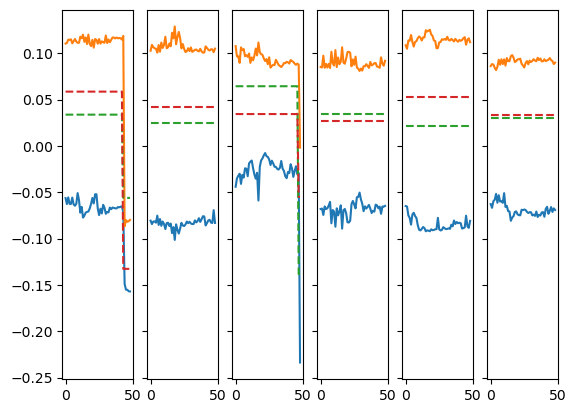

In [89]:
fig,axs = plt.subplots(1,min(params['num_vars'],6), sharey=True)
for i,ax in enumerate(axs.flatten()):
    ax.plot(out[2][i,:,-2:].cpu());
    ax.plot(ds_train.datalist[0].node_feats[i,1:,-2:].cpu(), '--');

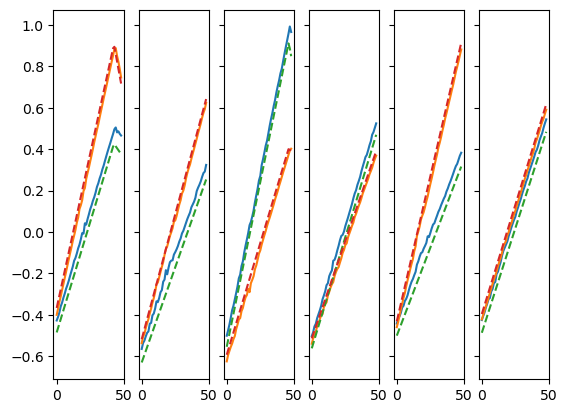

In [90]:
fig,axs = plt.subplots(1,min(params['num_vars'],6), sharey=True)
for i,ax in enumerate(axs.flatten()):
    ax.plot(out[2][i,:,:2].cpu());
    ax.plot(ds_train.datalist[0].node_feats[i,1:,:2].cpu(), '--');

In [91]:
model

DNRI(
  (encoder): DNRI_Encoder(
    (mlp1): RefNRIMLP(
      (model): Sequential(
        (0): Linear(in_features=4, out_features=256, bias=True)
        (1): ELU(alpha=1.0, inplace=True)
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=256, out_features=256, bias=True)
        (4): ELU(alpha=1.0, inplace=True)
      )
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (mlp1_e): RefNRIMLP(
      (model): Sequential(
        (0): Linear(in_features=3, out_features=256, bias=True)
        (1): ELU(alpha=1.0, inplace=True)
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=256, out_features=256, bias=True)
        (4): ELU(alpha=1.0, inplace=True)
      )
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (mlp2): RefNRIMLP(
      (model): Sequential(
        (0): Linear(in_features=768, out_features=256, bias=True)
        (1): ELU(alph

# Train

In [92]:
def get_edges_count_table(edges, dim=1):
    edges_table = np.zeros((params['num_edge_types'],params['num_vars']*(params['num_vars']-1)), dtype=int)
    idx = [slice(None)]*dim
    for i in range(edges.shape[dim]):
        u,c = edges[*(*idx,i)].unique(return_counts=True,)
        for j,j_c in zip(u,c):
            edges_table[int(j),i] = j_c
    return edges_table

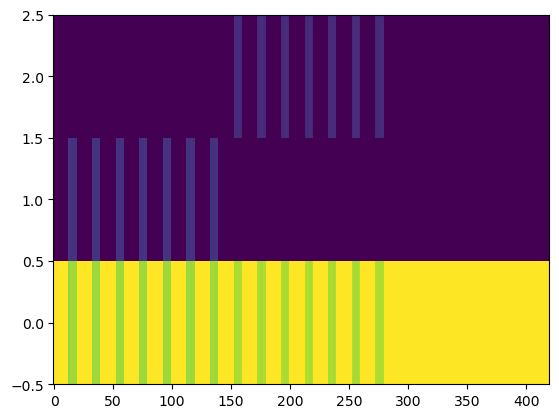

In [93]:
plt.imshow(get_edges_count_table(ds_train.edges[:,1:], dim=2),origin='lower', aspect='auto', interpolation='none');

In [94]:
import time

def build_scheduler(opt, params):
    lr_decay_factor, lr_decay_steps = params.get('lr_decay_factor'), params.get('lr_decay_steps')
    return torch.optim.lr_scheduler.StepLR(opt, lr_decay_steps, lr_decay_factor) if lr_decay_factor else None

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
def f1_score_dnri(edges_pred, edges_true_):
    if isinstance(edges_true_,torch.Tensor): edges_true_ = edges_true_.numpy()
    if isinstance(edges_pred,torch.Tensor): edges_pred = edges_pred.cpu().numpy()
    return f1_score(edges_true_.reshape(-1),
                    edges_pred.reshape(-1),
                    average='macro' if edges_true_.shape[-1]>2 else 'binary'), None

def train(model, dl_train, dl_valid, params):
    gpu = params.get('gpu', False)
    batch_size = params.get('batch_size', 1000)  # 16
    val_batch_size = params.get('val_batch_size', batch_size) # None
    if val_batch_size is None:  val_batch_size = batch_size # None=> 16
    accumulate_steps = params.get('accumulate_steps')  # 1
    training_scheduler = params.get('training_scheduler', None) # 
    num_epochs = params.get('num_epochs', 100) # 200
    # val_interval = params.get('val_interval', 1)  # 5
    val_start = params.get('val_start', 0)  #
    clip_grad = params.get('clip_grad', None)  #
    clip_grad_norm = params.get('clip_grad_norm', None) # None
    normalize_nll = params.get('normalize_nll', False) # True
    normalize_kl = params.get('normalize_kl', False)  # True
    tune_on_nll = params.get('tune_on_nll', False)  # True
    verbose = params.get('verbose', False)  # False
    val_teacher_forcing = params.get('val_teacher_forcing', False)  # True
    continue_training = params.get('continue_training', False)  # FAlse

    lr = params['lr']  # 5e-4
    wd = params.get('wd', 0.)  #
    mom = params.get('mom', 0.) # 0.

    model_params = [param for param in model.parameters() if param.requires_grad]
    opt = torch.optim.Adam(model_params, lr=lr, weight_decay=wd)

    working_dir = params['working_dir']
    best_path = os.path.join(working_dir, 'best_model')
    checkpoint_dir = os.path.join(working_dir, 'model_checkpoint')
    training_path = os.path.join(working_dir, 'training_checkpoint')
    if continue_training: # False
        print("RESUMING TRAINING")
        model.load(checkpoint_dir)
        train_params = torch.load(training_path)
        start_epoch = train_params['epoch']
        opt.load_state_dict(train_params['optimizer'])
        best_val_result = train_params['best_val_result']
        best_val_epoch = train_params['best_val_epoch']
        print("STARTING EPOCH: ",start_epoch)
    else: # <------------------------------------------
        start_epoch = 1
        best_val_epoch = -1
        best_val_result = 10000000
    unnorm_targ_pos = ds_valid.node_feats[...,1:, :2].reshape(-1,49,2)*ds_train.norm
    unnorm_targ_vel = ds_valid.node_feats[...,1:,2:4].reshape(-1,49,2)*ds_train.norm_v

    training_scheduler = build_scheduler(opt, params)
    end = start = 0
    train_loss, val_loss_ = [], []
    for epoch in range(start_epoch, num_epochs+1):
        log = f"{epoch} {end-start:.2g}s"
        model.train()
        model.train_percent = epoch / num_epochs
        start = time.time()
        for batch_ind, batch in enumerate(dl_train):
            loss, loss_nll, loss_kl = model.calculate_loss(batch, is_train=True)
            loss.backward()
            if clip_grad is not None:
                nn.utils.clip_grad_value_(model.parameters(), clip_grad)
                print('clipping gradient values')
            elif clip_grad_norm is not None:
                nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)
                print('clipping gradient norms')
            opt.step()
            opt.zero_grad()

        if training_scheduler is not None:  training_scheduler.step()
        loss_train = loss.item()
        train_loss.append(loss.item())

        model.eval()
        opt.zero_grad()

        total_nll, total_kl, bs = 0., 0., 0
        val_loss = 0.
        all_edges, all_false_edges, all_preds = [], [], []
        with torch.no_grad():
            for batch_ind, batch in enumerate(dl_valid):
                loss, loss_nll, loss_kl, edges, preds = model.calculate_loss(batch, is_train=False, teacher_forcing=val_teacher_forcing, return_edges=True)
                val_loss += loss.sum().item()*len(batch.batch)
                total_kl += loss_kl.sum().item()*len(batch.batch)
                total_nll += loss_nll.sum().item()*len(batch.batch)
                bs+=len(batch.batch)
                all_edges.append(edges)
                all_preds.append(preds)
            all_edges = torch.cat(all_edges,dim=0)
            all_preds = torch.cat(all_preds,dim=0)
            total_kl  /= bs
            total_nll /= bs
            val_loss  /= bs
            total_loss = model.kl_coef*total_kl + total_nll
            val_loss_.append(val_loss)

            # NLL positions, velocities
            unnorm_pred_pos = all_preds[...,:2]*ds_train.norm
            unnorm_pred_vel = all_preds[...,2:]*ds_train.norm_v
            # MSE is a scaled version of the nll gaussian
            nll_pos = ((unnorm_pred_pos-unnorm_targ_pos) ** 2 / (2 * model.prior_variance))
            nll_vel = ((unnorm_pred_vel-unnorm_targ_vel) ** 2 / (2 * model.prior_variance))


            all_edges_ = all_edges.argmax(dim=-1).float().cpu()
            if all_edges_[ds_valid.edges[:,1:].transpose(1,2).reshape(-1, all_edges.shape[-2])==1].mean()> 1.2: # sort labels
                all_edges_ = all_edges[...,[0,2,1]].argmax(dim=-1).float().cpu()
            f1, *_ = f1_score_dnri(all_edges_,
                                   ds_valid.edges[:,1:].transpose(1,2))
            cm = confusion_matrix(ds_valid.edges[:,1:].transpose(1,2).reshape(-1),
                                  all_edges_.numpy().reshape(-1),
                                  normalize='true'
                                 )
            # tab = get_edges_count_table(all_edges_.reshape(-1,params['num_vars']*(params['num_vars']-1),*all_edges_.shape[1:]), dim=1)
        tuning_loss = total_nll
        if tuning_loss < best_val_result:
            best_val_epoch = epoch
            best_val_result = tuning_loss
            model.save(best_path)
        model.save(checkpoint_dir)
        torch.save({'epoch':epoch+1,
                    'optimizer':opt.state_dict(),
                    'best_val_result':best_val_result,
                    'best_val_epoch':best_val_epoch,
                   }, training_path)
        print(log, f"{training_scheduler.get_last_lr()[0]:.2g}"\
              f"\t{loss_train:.4g}/{total_loss:.4g}({best_val_result:.4g}) {total_kl:.4g} {f1:.3g}")
        print(*map(lambda x: f'{x.sum(-1).mean().item():.3g}',[nll_pos, nll_vel]),
              "sigma=",*[f'{p.item():.3g}' for p in model.super_gaussians.sigma[:]],
              "beta",  *[f'{p.item():.3g}' for p in model.super_gaussians.beta[:]])
        with np.printoptions(precision=1, suppress=True):
            print(cm*100)
        end = time.time()
    tab = get_edges_count_table(all_edges_.reshape(-1,params['num_vars']*(params['num_vars']-1),*all_edges_.shape[1:]), dim=1)
    plt.imshow(tab,origin='lower', aspect='auto', interpolation='none');
    plt.figure()
    plt.plot(train_loss);plt.plot(val_loss_);
    print(f"{best_val_result:.4g}|",*map(lambda x: f'{x.sum(-1).mean().item():.3g}',[nll_pos, nll_vel]),f"|{f1:.3g}|{cm[0,0]*100:.0f},{cm[1,1]*100:.0f}|")

In [95]:
params['use_supergaussian']=True
params['add_uniform_prior']=True

In [49]:
seed(params['model_seed']) # set seed for numpy torch cuda and random libs
if params['gpu']:
    with dvc:
        model = DNRI(params).cuda() if params['sparse'] else DNRI(params,edge2node_mat=ds_train.edge2node_mat).cuda()
else:
    model = DNRI(params)  if params['sparse'] else DNRI(params,ds_train.edge2node_mat)

Using learned interaction net decoder.
USING NO-EDGE PRIOR:  tensor([0.9000, 0.0500, 0.0500], device='cuda:0') tensor([[-0.1054, -2.9957, -2.9957]], device='cuda:0')


In [50]:
model.add_uniform_prior = False

In [55]:
with torch.inference_mode():
    loss, loss_nll, loss_kl, logits, preds = model.calculate_loss(ds_train.datalist[0], is_train=False, return_logits=True)
    loss, loss_nll, loss_kl, edges, preds = model.calculate_loss(ds_train.datalist[0], is_train=False, return_edges=True)
    print(f'{loss=:.4g} = {loss_nll=:.4g} + {loss_kl=:.4g}')
    # MSE positions, velocities
    unnorm_pred_pos = preds[...,:2]*ds_train.norm
    unnorm_pred_vel = preds[...,2:]*ds_train.norm_v
    unnorm_targ_pos = ds_train.datalist[0].node_feats[...,1:, :2].reshape(-1,49,2)*ds_train.norm
    unnorm_targ_vel = ds_train.datalist[0].node_feats[...,1:,2:4].reshape(-1,49,2)*ds_train.norm_v
    nll_pos = ((unnorm_pred_pos-unnorm_targ_pos) ** 2 / (2 * model.prior_variance)).sum(-1).mean().item()
    nll_vel = ((unnorm_pred_vel-unnorm_targ_vel) ** 2 / (2 * model.prior_variance)).sum(-1).mean().item()
    print(f'unnormed NLL: {nll_pos=:.4g}, {nll_vel=:.4g}')

    all_edges_ = edges.argmax(dim=-1).float().cpu()
    f1, *_ = f1_score_dnri(all_edges_,
                           ds_train.edges[0,1:])
    cm = confusion_matrix(ds_train.edges[0,1:].reshape(-1),
                          all_edges_.numpy().reshape(-1),
                          normalize='true'
                         )
    print(f'F1={f1:.2g}')
    print(f'CM=')
    with np.printoptions(precision=1, suppress=True):
        print(cm*100)

loss=244.8 = loss_nll=244.7 + loss_kl=0.07068
unnormed NLL: nll_pos=981.1, nll_vel=266.5
F1=0.28
CM=
[[67.9 13.4 18.7]
 [67.  14.8 18.2]
 [62.9 18.4 18.8]]


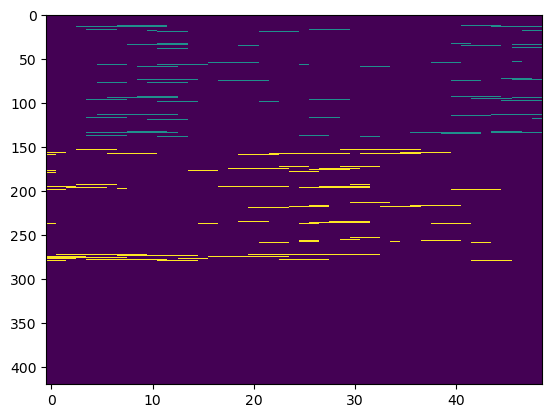

In [56]:
plt.imshow(ds_train.edges[0,1:].cpu().numpy().T, aspect='auto', interpolation='none');

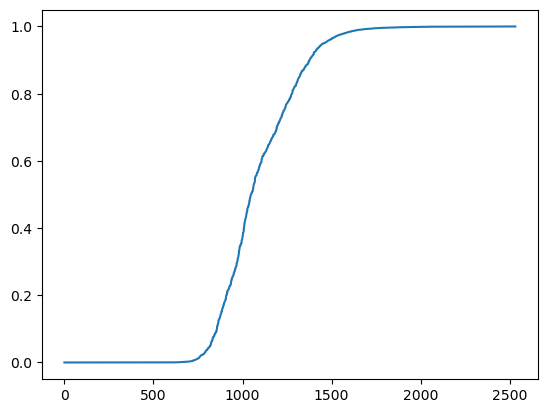

In [125]:
plt.plot(edges.unique().cpu().numpy());

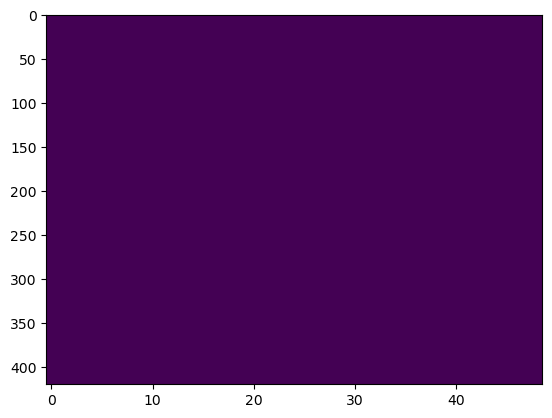

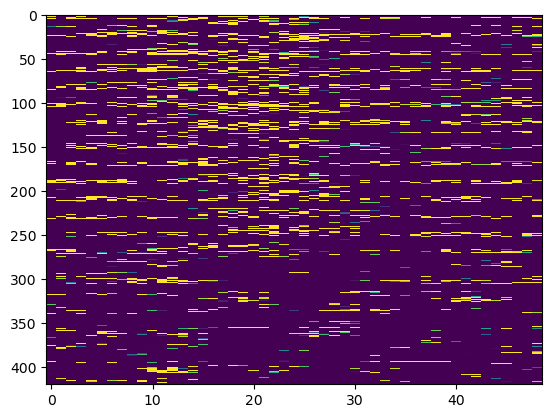

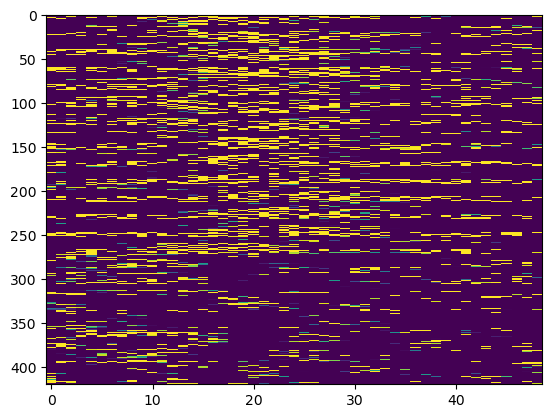

In [57]:
for i in range(3):
    plt.figure();    plt.imshow(edges[...,i].cpu().numpy(), aspect='auto', interpolation='none');

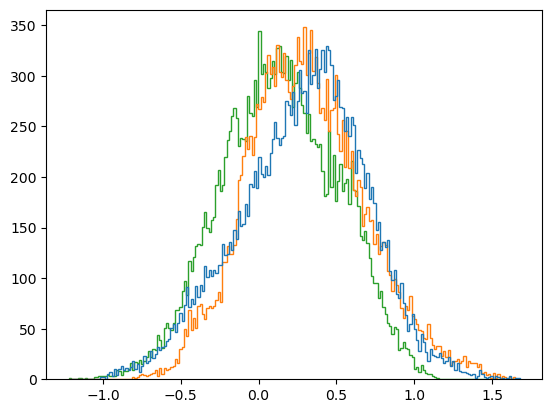

In [58]:
plt.hist(logits.reshape(-1,3).cpu().numpy(), 200, histtype='step');

## Training

In [52]:
params['lr']=5e-6

In [54]:
params['num_epochs']=20  # warm-up

In [53]:
params['gumbel_temp']=1.5
model.gumbel_temp=1.5

In [59]:
assert model.use_supergaussian

In [60]:
assert not model.add_uniform_prior

EPOCH 1 0
BEST VAL RESULT 220.5. SAVING MODEL...
EPOCH 1 EVAL: lr=5e-06
	CURRENT train/val LOSS kl_val F1: 216.9/220.6 0.03525 0.311
['895', '270']
[[69.3 10.5 20.1]
 [34.6 27.2 38.2]
 [35.5 27.  37.5]]
	BEST VAL LOSS:    220.5
EPOCH 2 9.7
BEST VAL RESULT 196.1. SAVING MODEL...
EPOCH 2 EVAL: lr=5e-06
	CURRENT train/val LOSS kl_val F1: 189.2/196.2 0.06519 0.31
['829', '253']
[[69.4  9.9 20.7]
 [35.9 25.  39.1]
 [37.5 24.9 37.6]]
	BEST VAL LOSS:    196.1
EPOCH 3 12
BEST VAL RESULT 172. SAVING MODEL...
EPOCH 3 EVAL: lr=5e-06
	CURRENT train/val LOSS kl_val F1: 162.2/172 0.07489 0.31
['762', '237']
[[69.6 10.5 19.8]
 [35.8 26.6 37.7]
 [40.9 25.5 33.6]]
	BEST VAL LOSS:    172
EPOCH 4 12
BEST VAL RESULT 147.3. SAVING MODEL...
EPOCH 4 EVAL: lr=5e-06
	CURRENT train/val LOSS kl_val F1: 146.8/147.4 0.09367 0.308
['693', '221']
[[69.8 11.3 18.9]
 [35.4 28.3 36.2]
 [44.9 27.  28.1]]
	BEST VAL LOSS:    147.3
EPOCH 5 11
BEST VAL RESULT 125.4. SAVING MODEL...
EPOCH 5 EVAL: lr=5e-06
	CURRENT train/val 

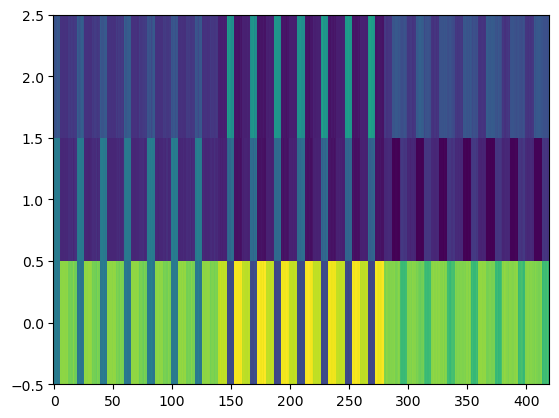

In [61]:
if params['mode'] == 'train':
    train(model, dl_train, dl_valid, params)

In [62]:
params['lr']=1e-5

In [63]:
params['num_epochs']=40

EPOCH 1 0
BEST VAL RESULT 29.66. SAVING MODEL...
EPOCH 1 EVAL: lr=1e-05
	CURRENT train/val LOSS kl_val F1: 29.34/29.84 0.1777 0.3
['224', '151']
[[65.9 14.8 19.3]
 [24.1 43.6 32.3]
 [37.6 42.9 19.6]]
	BEST VAL LOSS:    29.66
EPOCH 2 11
BEST VAL RESULT 26.97. SAVING MODEL...
EPOCH 2 EVAL: lr=1e-05
	CURRENT train/val LOSS kl_val F1: 30.49/27.14 0.1712 0.302
['199', '149']
[[66.4 14.8 18.8]
 [23.2 43.7 33.1]
 [37.5 42.8 19.7]]
	BEST VAL LOSS:    26.97
EPOCH 3 10
BEST VAL RESULT 24.92. SAVING MODEL...
EPOCH 3 EVAL: lr=1e-05
	CURRENT train/val LOSS kl_val F1: 26.16/25.08 0.1638 0.303
['179', '149']
[[67.2 14.7 18.1]
 [23.1 43.3 33.6]
 [37.8 42.9 19.3]]
	BEST VAL LOSS:    24.92
EPOCH 4 9.7
BEST VAL RESULT 23.2. SAVING MODEL...
EPOCH 4 EVAL: lr=1e-05
	CURRENT train/val LOSS kl_val F1: 27.49/23.36 0.1568 0.306
['161', '148']
[[68.1 14.6 17.3]
 [23.2 43.4 33.3]
 [37.9 43.4 18.7]]
	BEST VAL LOSS:    23.2
EPOCH 5 8.8
BEST VAL RESULT 21.81. SAVING MODEL...
EPOCH 5 EVAL: lr=1e-05
	CURRENT train/val

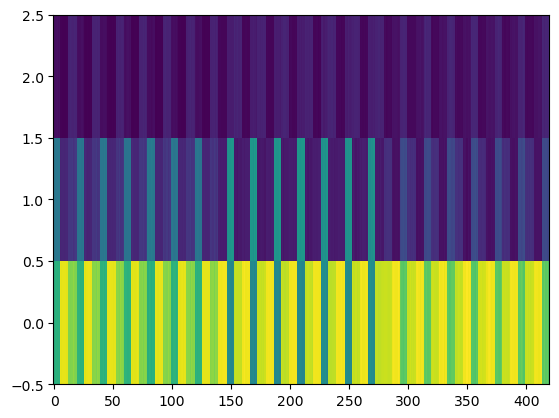

In [64]:
if params['mode'] == 'train':
    train(model, dl_train, dl_valid, params)

In [65]:
params['lr']=5e-5

In [66]:
params['num_epochs']=100

EPOCH 1 0
BEST VAL RESULT 9.26. SAVING MODEL...
EPOCH 1 EVAL: lr=5e-05
	CURRENT train/val LOSS kl_val F1: 10.2/9.318 0.05826 0.362
['53.6', '140']
[[77.4 17.2  5.4]
 [28.7 48.1 23.3]
 [20.6 43.4 36. ]]
	BEST VAL LOSS:    9.26
EPOCH 2 10
BEST VAL RESULT 8.638. SAVING MODEL...
EPOCH 2 EVAL: lr=5e-05
	CURRENT train/val LOSS kl_val F1: 11.9/8.689 0.05126 0.372
['53.6', '139']
[[77.9 17.5  4.6]
 [28.7 49.1 22.3]
 [18.7 42.5 38.9]]
	BEST VAL LOSS:    8.638
EPOCH 3 9.5
BEST VAL RESULT 7.833. SAVING MODEL...
EPOCH 3 EVAL: lr=5e-05
	CURRENT train/val LOSS kl_val F1: 9.303/7.881 0.048 0.38
['53', '139']
[[78.1 18.   3.9]
 [29.8 50.5 19.7]
 [18.1 42.8 39.1]]
	BEST VAL LOSS:    7.833
EPOCH 4 10
BEST VAL RESULT 7.188. SAVING MODEL...
EPOCH 4 EVAL: lr=5e-05
	CURRENT train/val LOSS kl_val F1: 9.051/7.231 0.04346 0.387
['52.9', '138']
[[78.1 18.3  3.6]
 [29.6 52.  18.4]
 [17.1 41.6 41.4]]
	BEST VAL LOSS:    7.188
EPOCH 5 10
BEST VAL RESULT 6.761. SAVING MODEL...
EPOCH 5 EVAL: lr=5e-05
	CURRENT train/v

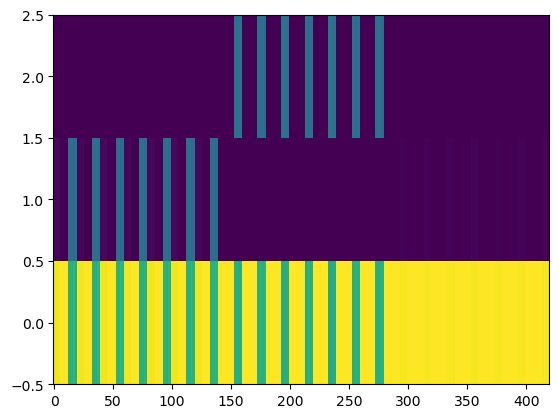

In [67]:
if params['mode'] == 'train':
    train(model, dl_train, dl_valid, params)

In [68]:
params['gumbel_temp']=0.5
model.gumbel_temp=0.5

EPOCH 1 0
BEST VAL RESULT 0.1884. SAVING MODEL...
EPOCH 1 EVAL: lr=5e-05
	CURRENT train/val LOSS kl_val F1: 0.4494/0.2048 0.01634 0.657
['45.8', '134']
[[93.9  3.   3.1]
 [ 1.6 98.3  0. ]
 [ 2.   0.1 97.8]]
	BEST VAL LOSS:    0.1884
EPOCH 2 11
BEST VAL RESULT 0.1407. SAVING MODEL...
EPOCH 2 EVAL: lr=5e-05
	CURRENT train/val LOSS kl_val F1: 0.1483/0.15 0.009346 0.663
['45.8', '134']
[[93.9  2.9  3.1]
 [ 0.9 99.1  0. ]
 [ 0.6  0.1 99.3]]
	BEST VAL LOSS:    0.1407
EPOCH 3 12
BEST VAL RESULT 0.09052. SAVING MODEL...
EPOCH 3 EVAL: lr=5e-05
	CURRENT train/val LOSS kl_val F1: 0.09226/0.09938 0.00886 0.664
['45.6', '134']
[[94.   2.9  3.1]
 [ 0.8 99.2  0. ]
 [ 1.5  0.1 98.4]]
	BEST VAL LOSS:    0.09052
EPOCH 4 12
EPOCH 4 EVAL: lr=5e-05
	CURRENT train/val LOSS kl_val F1: 0.06498/0.1185 0.007954 0.662
['45.6', '134']
[[94.   2.9  3.1]
 [ 0.4 99.5  0. ]
 [ 1.8  0.1 98.1]]
	BEST VAL LOSS:    0.09052
EPOCH 5 12
BEST VAL RESULT 0.08582. SAVING MODEL...
EPOCH 5 EVAL: lr=5e-05
	CURRENT train/val LOSS 

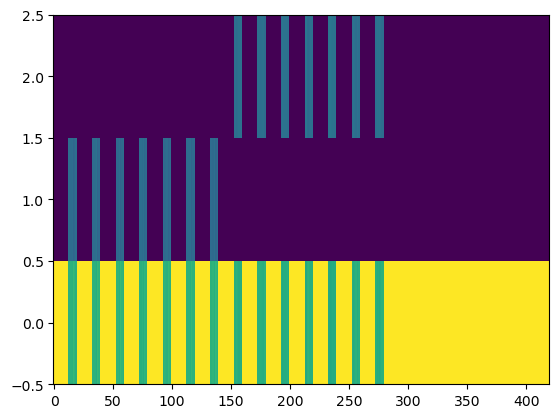

In [69]:
if params['mode'] == 'train':
    train(model, dl_train, dl_valid, params)

In [70]:
params['gumbel_temp']=0.1
model.gumbel_temp=0.1

EPOCH 1 0
BEST VAL RESULT 0.06628. SAVING MODEL...
EPOCH 1 EVAL: lr=5e-05
	CURRENT train/val LOSS kl_val F1: 0.2391/0.06906 0.00278 0.677
['45.5', '134']
[[94.4  2.6  3. ]
 [ 0.1 99.9  0. ]
 [ 0.3  0.  99.7]]
	BEST VAL LOSS:    0.06628
EPOCH 2 7.4
BEST VAL RESULT 0.04356. SAVING MODEL...
EPOCH 2 EVAL: lr=5e-05
	CURRENT train/val LOSS kl_val F1: 0.05819/0.04527 0.00171 0.678
['45.6', '134']
[[94.4  2.6  3. ]
 [ 0.3 99.7  0. ]
 [ 0.3  0.  99.6]]
	BEST VAL LOSS:    0.04356
EPOCH 3 7.4
BEST VAL RESULT 0.0306. SAVING MODEL...
EPOCH 3 EVAL: lr=5e-05
	CURRENT train/val LOSS kl_val F1: 0.02179/0.03267 0.002066 0.676
['45.6', '134']
[[94.4  2.6  3. ]
 [ 0.2 99.8  0. ]
 [ 0.4  0.  99.6]]
	BEST VAL LOSS:    0.0306
EPOCH 4 7.4
BEST VAL RESULT 0.02821. SAVING MODEL...
EPOCH 4 EVAL: lr=5e-05
	CURRENT train/val LOSS kl_val F1: 0.01961/0.02952 0.001309 0.676
['45.6', '134']
[[94.3  2.7  3. ]
 [ 0.1 99.9  0. ]
 [ 0.4  0.  99.6]]
	BEST VAL LOSS:    0.02821
EPOCH 5 7.3
BEST VAL RESULT 0.02164. SAVING MOD

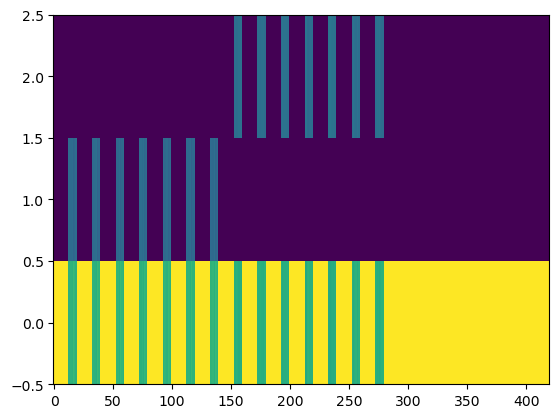

In [71]:
if params['mode'] == 'train':
    train(model, dl_train, dl_valid, params)

In [72]:
params['gumbel_temp']=0.05
model.gumbel_temp=0.05

EPOCH 1 0
BEST VAL RESULT 0.07709. SAVING MODEL...
EPOCH 1 EVAL: lr=5e-05
	CURRENT train/val LOSS kl_val F1: 0.2361/0.07828 0.001193 0.682
['45.7', '134']
[[94.5  2.5  3. ]
 [ 0.4 99.6  0. ]
 [ 0.1  0.  99.9]]
	BEST VAL LOSS:    0.07709
EPOCH 2 7.4
BEST VAL RESULT 0.0509. SAVING MODEL...
EPOCH 2 EVAL: lr=5e-05
	CURRENT train/val LOSS kl_val F1: 0.06541/0.05278 0.001882 0.681
['45.6', '134']
[[94.5  2.5  3. ]
 [ 0.2 99.8  0. ]
 [ 1.3  0.  98.7]]
	BEST VAL LOSS:    0.0509
EPOCH 3 7.5
BEST VAL RESULT 0.04178. SAVING MODEL...
EPOCH 3 EVAL: lr=5e-05
	CURRENT train/val LOSS kl_val F1: 0.03704/0.04401 0.002231 0.677
['45.6', '134']
[[94.4  2.6  3. ]
 [ 0.3 99.7  0. ]
 [ 0.8  0.  99.1]]
	BEST VAL LOSS:    0.04178
EPOCH 4 7.6
BEST VAL RESULT 0.01894. SAVING MODEL...
EPOCH 4 EVAL: lr=5e-05
	CURRENT train/val LOSS kl_val F1: 0.0173/0.02012 0.001172 0.676
['45.6', '134']
[[94.4  2.7  3. ]
 [ 0.2 99.8  0. ]
 [ 0.4  0.  99.6]]
	BEST VAL LOSS:    0.01894
EPOCH 5 7.5
BEST VAL RESULT 0.01262. SAVING MO

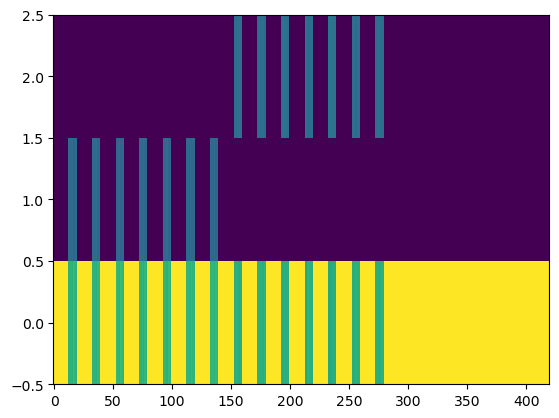

In [73]:
if params['mode'] == 'train':
    train(model, dl_train, dl_valid, params)

EPOCH 1 0
BEST VAL RESULT 0.07709. SAVING MODEL...
EPOCH 1 EVAL: lr=5e-05
	CURRENT train/val LOSS kl_val F1: 0.2361/0.07828 0.001193 0.682
['45.7', '134']
[[94.5  2.5  3. ]
 [ 0.4 99.6  0. ]
 [ 0.1  0.  99.9]]
	BEST VAL LOSS:    0.07709
EPOCH 2 7.4
BEST VAL RESULT 0.0509. SAVING MODEL...
EPOCH 2 EVAL: lr=5e-05
	CURRENT train/val LOSS kl_val F1: 0.06541/0.05278 0.001882 0.681
['45.6', '134']
[[94.5  2.5  3. ]
 [ 0.2 99.8  0. ]
 [ 1.3  0.  98.7]]
	BEST VAL LOSS:    0.0509
EPOCH 3 7.5
BEST VAL RESULT 0.04178. SAVING MODEL...
EPOCH 3 EVAL: lr=5e-05
	CURRENT train/val LOSS kl_val F1: 0.03704/0.04401 0.002231 0.677
['45.6', '134']
[[94.4  2.6  3. ]
 [ 0.3 99.7  0. ]
 [ 0.8  0.  99.1]]
	BEST VAL LOSS:    0.04178
EPOCH 4 7.6
BEST VAL RESULT 0.01894. SAVING MODEL...
EPOCH 4 EVAL: lr=5e-05
	CURRENT train/val LOSS kl_val F1: 0.0173/0.02012 0.001172 0.676
['45.6', '134']
[[94.4  2.7  3. ]
 [ 0.2 99.8  0. ]
 [ 0.4  0.  99.6]]
	BEST VAL LOSS:    0.01894
EPOCH 5 7.5
BEST VAL RESULT 0.01262. SAVING MO

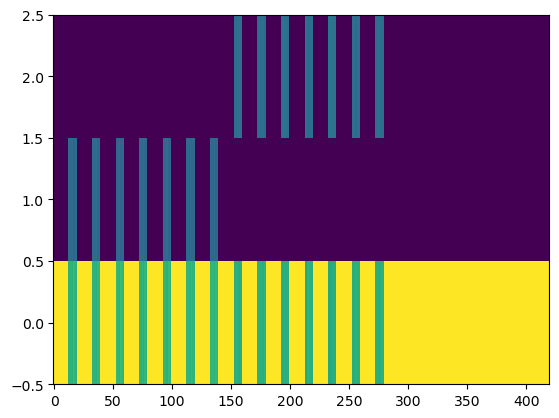

In [73]:
if params['mode'] == 'train':
    train(model, dl_train, dl_valid, params)

EPOCH 1 0
BEST VAL RESULT 0.07709. SAVING MODEL...
EPOCH 1 EVAL: lr=5e-05
	CURRENT train/val LOSS kl_val F1: 0.2361/0.07828 0.001193 0.682
['45.7', '134']
[[94.5  2.5  3. ]
 [ 0.4 99.6  0. ]
 [ 0.1  0.  99.9]]
	BEST VAL LOSS:    0.07709
EPOCH 2 7.4
BEST VAL RESULT 0.0509. SAVING MODEL...
EPOCH 2 EVAL: lr=5e-05
	CURRENT train/val LOSS kl_val F1: 0.06541/0.05278 0.001882 0.681
['45.6', '134']
[[94.5  2.5  3. ]
 [ 0.2 99.8  0. ]
 [ 1.3  0.  98.7]]
	BEST VAL LOSS:    0.0509
EPOCH 3 7.5
BEST VAL RESULT 0.04178. SAVING MODEL...
EPOCH 3 EVAL: lr=5e-05
	CURRENT train/val LOSS kl_val F1: 0.03704/0.04401 0.002231 0.677
['45.6', '134']
[[94.4  2.6  3. ]
 [ 0.3 99.7  0. ]
 [ 0.8  0.  99.1]]
	BEST VAL LOSS:    0.04178
EPOCH 4 7.6
BEST VAL RESULT 0.01894. SAVING MODEL...
EPOCH 4 EVAL: lr=5e-05
	CURRENT train/val LOSS kl_val F1: 0.0173/0.02012 0.001172 0.676
['45.6', '134']
[[94.4  2.7  3. ]
 [ 0.2 99.8  0. ]
 [ 0.4  0.  99.6]]
	BEST VAL LOSS:    0.01894
EPOCH 5 7.5
BEST VAL RESULT 0.01262. SAVING MO

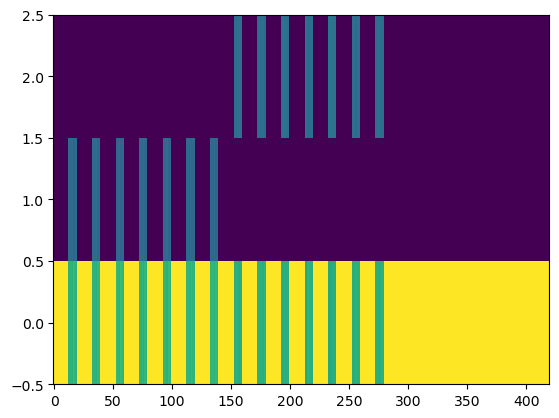

In [73]:
if params['mode'] == 'train':
    train(model, dl_train, dl_valid, params)

In [65]:
params['lr']=1e-5

EPOCH 1 0
BEST VAL RESULT 0.07709. SAVING MODEL...
EPOCH 1 EVAL: lr=5e-05
	CURRENT train/val LOSS kl_val F1: 0.2361/0.07828 0.001193 0.682
['45.7', '134']
[[94.5  2.5  3. ]
 [ 0.4 99.6  0. ]
 [ 0.1  0.  99.9]]
	BEST VAL LOSS:    0.07709
EPOCH 2 7.4
BEST VAL RESULT 0.0509. SAVING MODEL...
EPOCH 2 EVAL: lr=5e-05
	CURRENT train/val LOSS kl_val F1: 0.06541/0.05278 0.001882 0.681
['45.6', '134']
[[94.5  2.5  3. ]
 [ 0.2 99.8  0. ]
 [ 1.3  0.  98.7]]
	BEST VAL LOSS:    0.0509
EPOCH 3 7.5
BEST VAL RESULT 0.04178. SAVING MODEL...
EPOCH 3 EVAL: lr=5e-05
	CURRENT train/val LOSS kl_val F1: 0.03704/0.04401 0.002231 0.677
['45.6', '134']
[[94.4  2.6  3. ]
 [ 0.3 99.7  0. ]
 [ 0.8  0.  99.1]]
	BEST VAL LOSS:    0.04178
EPOCH 4 7.6
BEST VAL RESULT 0.01894. SAVING MODEL...
EPOCH 4 EVAL: lr=5e-05
	CURRENT train/val LOSS kl_val F1: 0.0173/0.02012 0.001172 0.676
['45.6', '134']
[[94.4  2.7  3. ]
 [ 0.2 99.8  0. ]
 [ 0.4  0.  99.6]]
	BEST VAL LOSS:    0.01894
EPOCH 5 7.5
BEST VAL RESULT 0.01262. SAVING MO

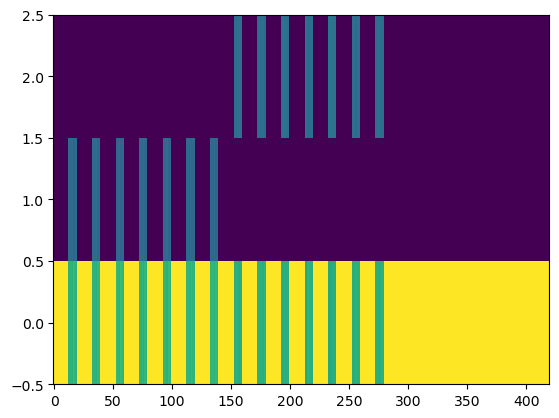

In [73]:
if params['mode'] == 'train':
    train(model, dl_train, dl_valid, params)

# Evaluation of model performance

## Inference on test data

In [116]:
#params['gpu']=True
dvc = DEVICE = torch.device('cuda' if torch.cuda.is_available() and params['gpu'] else 'cpu')
print(dvc)
if params['gpu']:
    with dvc:
        model = DNRI(params).cuda() if params['sparse'] else DNRI(params,edge2node_mat=ds_train.edge2node_mat).cuda()
else:
    model = DNRI(params)  if params['sparse'] else DNRI(params,ds_train.edge2node_mat)
print(next(model.decoder.parameters()).device,)# model.decoder.edge2node_mat.device)
print("LOADING BEST MODEL")
best_path = os.path.join(params['working_dir'],'best_model')
print(best_path)
model.load(best_path)
model.eval()
print(next(model.decoder.parameters()).device,)# model.decoder.edge2node_mat.device)

cuda
Using learned interaction net decoder.
cuda:0
LOADING BEST MODEL
../results/synth3reflective_21/dnri/seed_3/best_model
cuda:0


In [117]:
params['data_path']

'../data/raw/synth3_21/'

In [118]:
params['data_path'] = '../data/raw/synth3reflective_21/'

In [119]:
params['data_path'] = '../data/raw/synth3_21/'

In [120]:
edges_true = torch.load(params['data_path']+'test_edges')
feats = torch.load(params['data_path']+'test_feats')
feats_ = torch.load(params['data_path']+'test_feats') # not normalized feats

In [121]:
edges_true = edges_true[:,ds_train.slice_t]
feats  = feats[:,ds_train.slice_t]
feats_ = feats_[:,ds_train.slice_t]

In [122]:
feats  = feats.transpose(1,2)
feats_ = feats_.transpose(1,2)

In [123]:
feats[..., :2] = (feats[..., :2]-ds_train.loc_min)*2/(ds_train.loc_max-ds_train.loc_min)-1
feats[...,2: ] = (feats[...,2: ]-ds_train.vel_min)*2/(ds_train.vel_max-ds_train.vel_min)-1

In [124]:
norm = ds_train.norm # 2/(train_data.loc_max-train_data.loc_min)
norm_v = ds_train.norm_v # 2/(train_data.vel_max-train_data.vel_min)

In [125]:
params['norms'] = {'loc_max': ds_train.loc_max, 'loc_min': ds_train.loc_min,
                   'vel_max': ds_train.vel_max, 'vel_min': ds_train.vel_min,
                   'norm': ds_train.norm, 'norm_v': ds_train.norm_v,
                  }
params['norms']

{'loc_max': tensor(2.9963),
 'loc_min': tensor(-2.9985),
 'vel_max': tensor(1.0540),
 'vel_min': tensor(-0.9950),
 'norm': tensor(2.9974),
 'norm_v': tensor(1.0245)}

In [126]:
feats.shape, edges_true.shape

(torch.Size([2000, 21, 50, 4]), torch.Size([2000, 50, 420]))

In [127]:
N= feats.shape[1]
n=N//3
N,n

(21, 7)

In [128]:
batch_size = 32  # 128

In [129]:
assert model.training == False

In [130]:
with torch.inference_mode(), dvc:
    model.to(dvc)
    node_feats, edge_feats = feats.to(dvc), get_dv(feats, params['sparse']).to(dvc)  # B, T, N, F
    node_feats_test = node_feats
    edge_feats_test = edge_feats
    # target one step in the future
    target = node_feats[:,:, 1:] if not params['pred_delta'] else node_feats.diff(dim=2) # [B:batch, T:time-1, N:num_object, F:num_feats] target the future

    if params['sparse']: # For instance, if we know particle 0 and 1 do not interact with each other
        send_edges, recv_edges = (s_e.cuda(), r_e.cuda()) if params['gpu'] else (s_e, r_e)
    else: # fully connected
        send_edges, recv_edges = torch.where(torch.ones(params['num_vars']) - torch.eye(params['num_vars']))
        edge2node_mat = nn.Parameter(torch.stack([(recv_edges == i)*1.
                                              for i in range(params['num_vars'])]),
                                 requires_grad=False)
    edge_index = torch.stack((send_edges, recv_edges))
    # implicit batching
    datalist = [Data(node_feats=n, edge_feats=e, edge_index=edge_index)
                         for n,e in zip(node_feats,edge_feats)]

    print(f'{len(datalist)=}')
    timesteps = node_feats.size(2)  # T
    dl = DataLoader(datalist, batch_size=batch_size)
    all_edges, all_preds = [], []
    all_prior_logits, all_posterior_logits = [], []
    # batching-------------------
    for b in tqdm(dl):
        node_feats, edge_feats, edge_index_ = getattrs(b,['node_feats','edge_feats', 'edge_index'])

        # Encode input = predict prior and edge class
        prior_logits, posterior_logits, prior_state = model.encoder(node_feats[:,:-1],edge_feats[:,:-1], edge_index_)
        all_prior_logits.append(prior_logits)
        all_posterior_logits.append(posterior_logits)

        # Decode = predict next timestep features
        hidden = model.decoder.get_initial_hidden(node_feats) # zeros B*N,H
        edges, predictions = [], []

        for step in range(timesteps - 1): # T-1
            current_inputs = node_feats[:, step], edge_feats[:,step],edge_index_  # B*N, F
            prediction, hidden, edge = model.single_step_forward(
                current_inputs,  # B*N, F
                hidden,  # B*N, H
                posterior_logits[:, step],  # B*E, C
                hard_sample=True,
            )
            predictions.append(prediction)  # B*N, F
            edges.append(edge)              # B*E, C

        all_preds.append(torch.stack(predictions, dim=1)) # B*N, T-1, F
        all_edges.append(torch.stack(edges,dim=1)) # B*E,T-1,C

    # get loss
    # reconstruction
    all_preds=torch.cat(all_preds, dim=0)
    all_edges=torch.cat(all_edges, dim=0)
    print(f'{all_preds.shape=}, {target.shape=}')
    loss_nll = model.nll_gaussian(all_preds.reshape(-1,4), target.reshape(-1,4))

    # priors
    # learned prior
    all_posterior_logits=torch.cat(all_posterior_logits, dim=0)
    all_prior_logits=torch.cat(all_prior_logits, dim=0)

    prob = F.softmax(all_posterior_logits, dim=-1)
    loss_kl = loss_kl_learned = model.kl_categorical_learned(prob, all_prior_logits)
    # uniform (or guessed) prior
    if params['add_uniform_prior']:
        loss_kl_uniform = model.kl_categorical_avg(prob)
        loss_kl = 0.5 * loss_kl_learned + 0.5 * loss_kl_uniform

    loss = loss_nll + model.kl_coef * loss_kl
    loss = loss.mean().item()

    # mask_loss = torch.linalg.norm(target[...,:2], axis=-1)<model.Rinterior
    mask_loss_b = torch.linalg.norm(node_feats_test[:,:,1:,:2], axis=-1)<model.Rinterior
    idx_loss = torch.nonzero(mask_loss_b)
    mask_loss = mask_loss_b.reshape(-1,49)

node_feats = node_feats_test
edge_feats = edge_feats_test
predictions = all_preds
predictions = predictions.reshape(*node_feats.shape[:2],*predictions.shape[-2:])
edges = all_edges
posterior_logits = all_posterior_logits
prior_logits = all_prior_logits
import gc; gc.collect()
torch.cuda.empty_cache()

len(datalist)=2000


  0%|          | 0/63 [00:00<?, ?it/s]

all_preds.shape=torch.Size([42000, 49, 4]), target.shape=torch.Size([2000, 21, 49, 4])


In [131]:
# test_data = SmallSynthDataPyG(params['data_path'], 'test', params)
# edges_true = test_data.edges
edge_feats_batch = Batch.from_data_list(datalist,follow_batch=['edge_feats']).edge_feats_batch
edges_b, mask = to_dense_batch(edges,edge_feats_batch)
edges_true_ = edges_true[:,1:].long().cpu() # from the second timestep to coincide with predicted because first edges is from non-saved features
edges_pred  = edges_b.argmax(dim=-1).long().transpose(1,-1).cpu()

In [132]:
loss

0.002488774945959449

### Check effect of Gumbel noise on edge inference

In [133]:
posterior_logits.shape, 840000*49, 0.5/41*100

(torch.Size([840000, 49, 3]), 41160000, 1.2195121951219512)

In [134]:
edges_noised    = np.argmax(gumbel_softmax(posterior_logits, tau=0.01,
                                           hard=True, training=True).cpu().numpy(), axis=-1)
edges_noisefree = np.argmax(gumbel_softmax(posterior_logits, tau=0.01,
                                           hard=True, training=False).cpu().numpy(), axis=-1)
edges_argmax    = np.argmax(posterior_logits.cpu().numpy(), axis=-1)

In [139]:
print('percentage of different edges: ', ((edges_noised != edges_noisefree)*1.).mean()*100,
      '\nabsolute number: ',((edges_noised != edges_noisefree)*1.).sum())

percentage of different edges:  1.153731778425656 
absolute number:  474876.0


In [136]:
((edges_noised != edges_argmax)*1.).mean()*100, ((edges_noised != edges_argmax)*1.).sum()

(1.153731778425656, 474876.0)

In [137]:
((edges_noisefree != edges_argmax)*1.).mean()*100, ((edges_noisefree != edges_argmax)*1.).sum()

(0.0, 0.0)

## Loss

In [140]:
loss, *list(map(lambda x: x.mean().item(), [loss_nll,loss_kl, loss_kl_learned]))

(0.002488774945959449,
 0.0015732513274997473,
 0.0009155236766673625,
 0.0009155236766673625)

In [ ]:
node_feats.shape, predictions.shape, mask_loss.shape, node_feats[:,:,1:,:2][mask_loss_b].shape, 600*49

In [141]:
# MSE positions, velocities
unnorm_pred_pos = predictions[...,:2]*norm
unnorm_pred_vel = predictions[...,2:]*norm_v
unnorm_targ_pos = target[...,:2]*norm
unnorm_targ_vel = target[...,2:]*norm_v

mse_pos = F.mse_loss(unnorm_pred_pos, unnorm_targ_pos, reduction='none')
mse_vel = F.mse_loss(unnorm_pred_vel, unnorm_targ_vel, reduction='none')

nll_pos = ((unnorm_pred_pos-unnorm_targ_pos) ** 2 / (2 * model.prior_variance))
nll_vel = ((unnorm_pred_vel-unnorm_targ_vel) ** 2 / (2 * model.prior_variance))

print(list(map(lambda x: f'{x.sum(-1).mean().item():.3g}',
               [mse_pos, mse_vel, nll_pos, nll_vel])))

['7.38e-07', '1.69e-07', '0.00738', '0.00169']


In [142]:
nll_base =((node_feats_test[:,:,:-1,][mask_loss_b] - target[mask_loss_b]) ** 2 / (2 * model.prior_variance))

In [143]:
nll_base.sum(-1).mean(), nll_base[...,:2].sum(-1).mean(), nll_base[...,2:].sum(-1).mean()

(tensor(21.5653, device='cuda:0'),
 tensor(17.0775, device='cuda:0'),
 tensor(4.4878, device='cuda:0'))

In [144]:
nll_pos.shape

torch.Size([2000, 21, 49, 2])

In [145]:
nll_pos_b = nll_pos
nll_vel_b = nll_vel

### Loss vs time and space

In [146]:
nll = ((predictions - target) ** 2 / (2 * model.prior_variance))

In [147]:
nll[...,:2].sum(-1).mean(), nll[...,2:].sum(-1).mean()

(tensor(0.0008, device='cuda:0'), tensor(0.0016, device='cuda:0'))

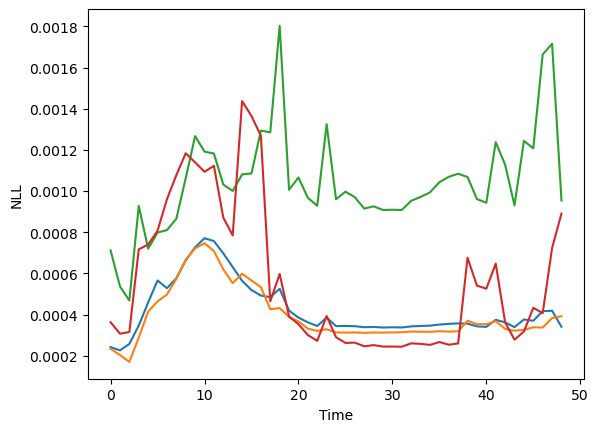

In [148]:
# NLL in time
plt.plot(nll.mean((0,1)).cpu());
plt.gca().set( xlabel='Time', ylabel='NLL');

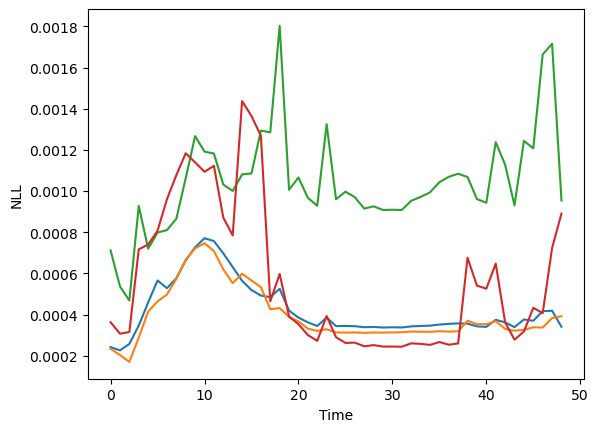

In [149]:
# NLL in time
plt.plot(nll.mean((0,1)).cpu());
plt.gca().set( xlabel='Time', ylabel='NLL');

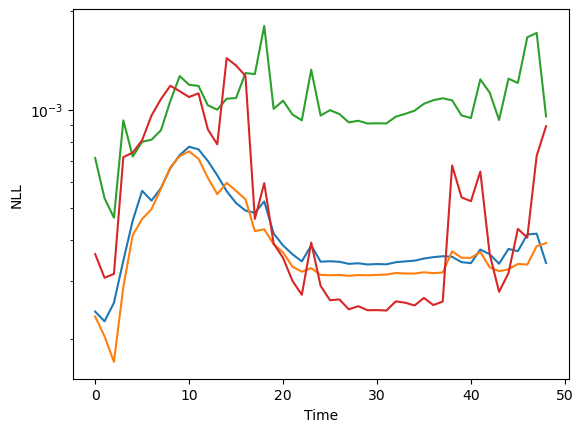

In [150]:
plt.semilogy(nll.mean((0,1)).cpu());
plt.gca().set( xlabel='Time', ylabel='NLL');

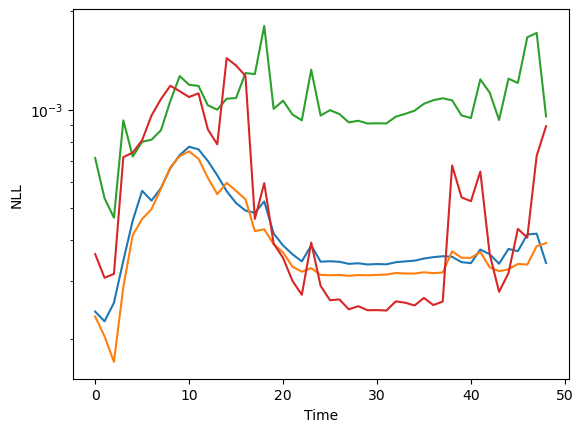

In [151]:
plt.semilogy(nll.mean((0,1)).cpu());
plt.gca().set( xlabel='Time', ylabel='NLL');

In [152]:
nll_logbins = np.geomspace(1e-8,2e4)

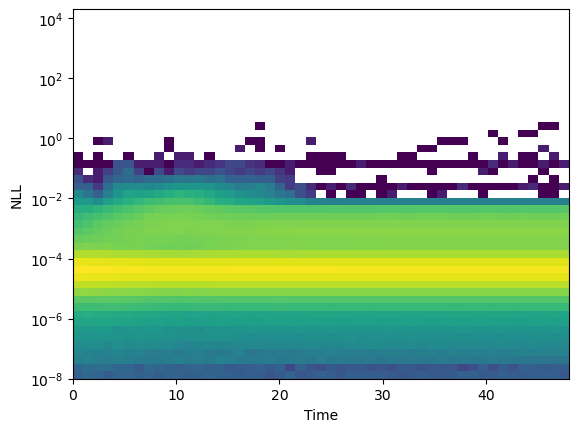

In [153]:
plt.hist2d(np.tile(np.arange(nll.shape[2]),np.prod(nll.shape[0:2])).reshape(-1),
           nll[...,0].reshape(-1).cpu(),
           bins=[49,nll_logbins],norm='log');plt.yscale('log')
plt.gca().set( xlabel='Time', ylabel='NLL');

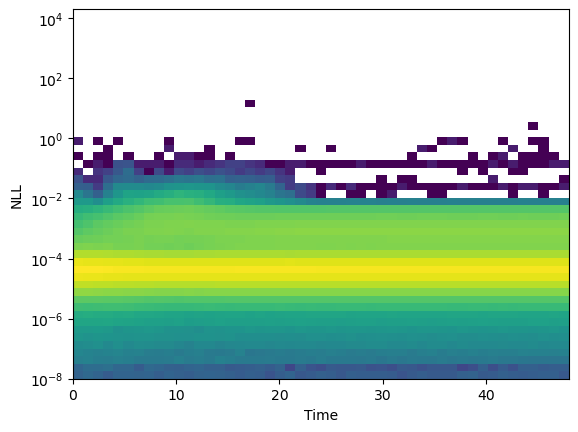

In [565]:
plt.hist2d(np.tile(np.arange(nll.shape[2]),np.prod(nll.shape[0:2])).reshape(-1),
           nll[...,0].reshape(-1).cpu(),
           bins=[49,nll_logbins],norm='log');plt.yscale('log')
plt.gca().set( xlabel='Time', ylabel='NLL');

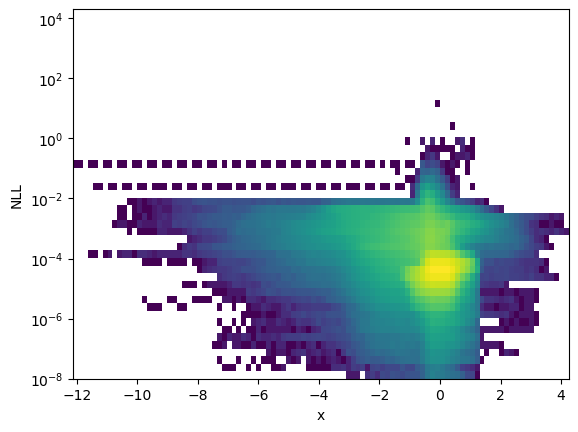

In [571]:
plt.hist2d(target[...,0].reshape(-1).cpu(),
           nll[...,0].reshape(-1).cpu(),
           bins=[100, nll_logbins],norm='log');plt.yscale('log')
plt.gca().set( xlabel='x', ylabel='NLL');

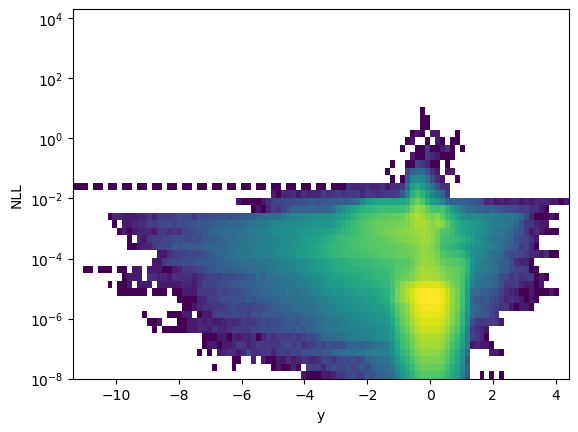

In [572]:
plt.hist2d(target[...,1].reshape(-1).cpu(),
           nll[...,1].reshape(-1).cpu(),
           bins=[100, nll_logbins],norm='log');plt.yscale('log')
plt.gca().set( xlabel='y', ylabel='NLL');

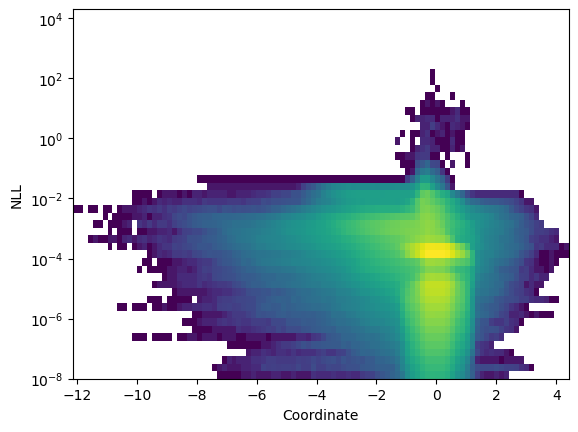

In [574]:
plt.hist2d(target[...,:2].reshape(-1).cpu(),
           nll[...,2:].reshape(-1).cpu(),
           bins=[100, nll_logbins],norm='log');plt.yscale('log')
plt.gca().set( xlabel='Coordinate', ylabel='NLL');

In [74]:
nll[...,2:].min(), nll[...,2:].max()
nll_logbins = np.geomspace(1e-4,2e4)

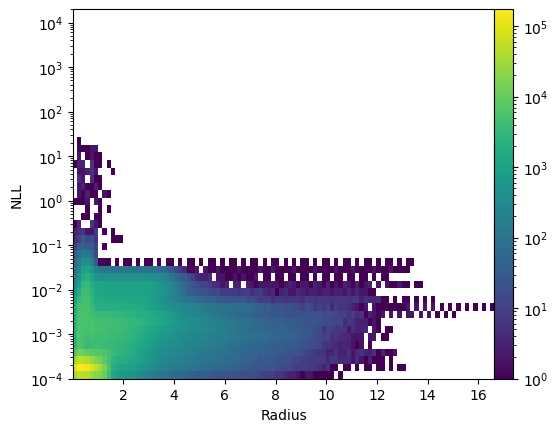

In [75]:
plt.hist2d(torch.hypot(target[...,0].reshape(-1),target[...,1].reshape(-1)).cpu(),
           torch.hypot(nll[...,2].reshape(-1),nll[...,3].reshape(-1)).cpu(),
           bins=[100,nll_logbins],norm='log');
plt.yscale('log');plt.colorbar(pad=0);
plt.gca().set( xlabel='Radius', ylabel='NLL');

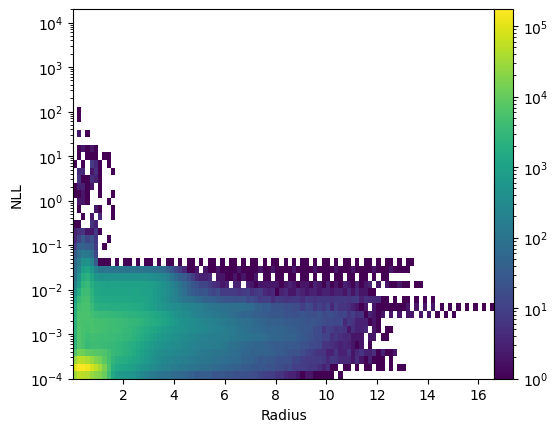

In [576]:
plt.hist2d(torch.hypot(target[...,0].reshape(-1),target[...,1].reshape(-1)).cpu(),
           torch.hypot(nll[...,2].reshape(-1),nll[...,3].reshape(-1)).cpu(),
           bins=[100,nll_logbins],norm='log');
plt.yscale('log');plt.colorbar(pad=0);
plt.gca().set( xlabel='Radius', ylabel='NLL');

In [76]:
bins = np.linspace(-1.1,1.1,100)
from scipy.stats import binned_statistic_2d
xs, ys = target[...,0].reshape(-1).cpu(), target[...,1].reshape(-1).cpu()
zs = nll[...,0:2].sum(-1).reshape(-1).cpu()
bs = binned_statistic_2d(xs,ys,zs,bins=bins,statistic='sum')

/tmp/ipykernel_1769759/754753445.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(bs.statistic), cmap='Blues',origin='lower');


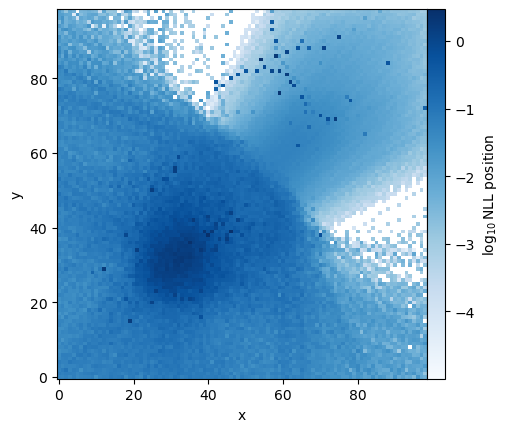

In [77]:
plt.imshow(np.log10(bs.statistic), cmap='Blues',origin='lower');
plt.colorbar(pad=0, label=r'$\log_{10}$NLL position');
plt.gca().set(xlabel='x',ylabel='y');

/tmp/ipykernel_3295868/4094421309.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(bs.statistic), cmap='Blues',origin='lower');


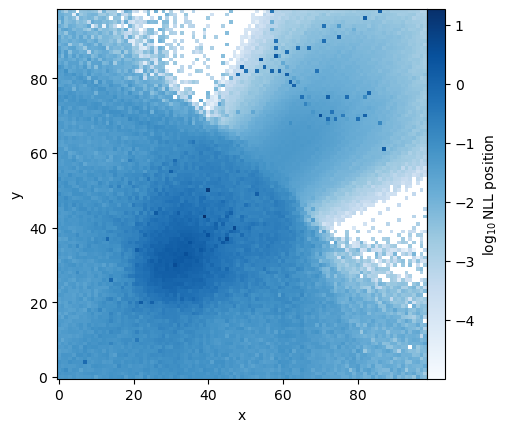

In [582]:
plt.imshow(np.log10(bs.statistic), cmap='Blues',origin='lower');
plt.colorbar(pad=0, label=r'$\log_{10}$NLL position');
plt.gca().set(xlabel='x',ylabel='y');

/tmp/ipykernel_2295519/4094421309.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(bs.statistic), cmap='Blues',origin='lower');


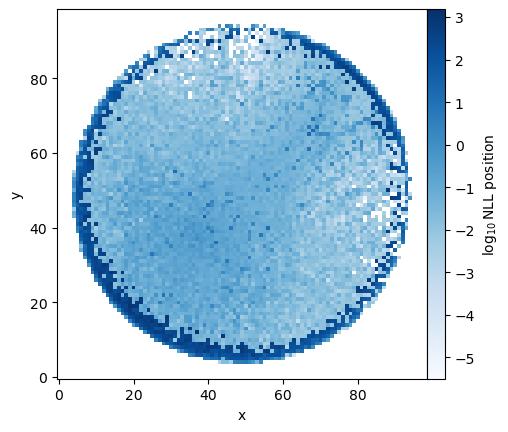

In [128]:
plt.imshow(np.log10(bs.statistic), cmap='Blues',origin='lower');
plt.colorbar(pad=0, label=r'$\log_{10}$NLL position');
plt.gca().set(xlabel='x',ylabel='y');

In [583]:
bins = np.linspace(-1.1,1.1,100)
from scipy.stats import binned_statistic_2d
xs, ys = target[...,0].reshape(-1).cpu(), target[...,1].reshape(-1).cpu()
zs = nll[...,2:4].sum(-1).reshape(-1).cpu()
bs = binned_statistic_2d(xs,ys,zs,bins=bins,statistic='sum')

/tmp/ipykernel_3295868/1568572802.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(bs.statistic), cmap='Blues',origin='lower');


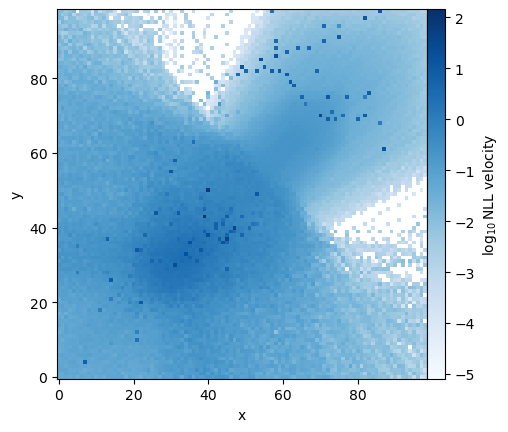

In [584]:
plt.imshow(np.log10(bs.statistic), cmap='Blues',origin='lower');
plt.colorbar(pad=0, label=r'$\log_{10}$NLL velocity');
plt.gca().set(xlabel='x',ylabel='y');

/tmp/ipykernel_2295519/1568572802.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(bs.statistic), cmap='Blues',origin='lower');


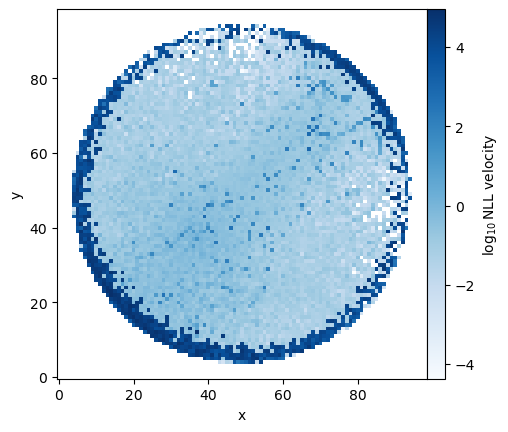

In [130]:
plt.imshow(np.log10(bs.statistic), cmap='Blues',origin='lower');
plt.colorbar(pad=0, label=r'$\log_{10}$NLL velocity');
plt.gca().set(xlabel='x',ylabel='y');

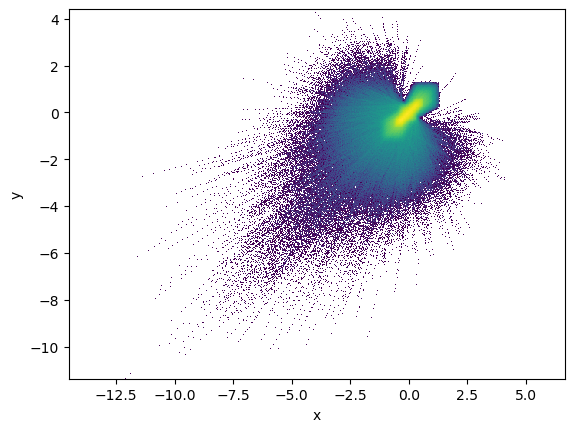

In [586]:
plt.hist2d(target[...,0].reshape(-1).cpu().numpy(),
           target[...,1].reshape(-1).cpu().numpy(), 500, norm='log');
plt.axis('equal');
plt.gca().set( xlabel='x', ylabel='y');

### Masked Top losses

In [154]:
target_b = target.transpose(2,1)
predictions_b = predictions.transpose(2,1)

In [155]:
nll_vel_b.shape, mask_loss.shape,mask_loss_b.shape,idx_loss.shape

(torch.Size([2000, 21, 49, 2]),
 torch.Size([42000, 49]),
 torch.Size([2000, 21, 49]),
 torch.Size([1079876, 3]))

In [156]:
nll_vel_b_mt = nll_vel_b*mask_loss_b[...,None].repeat(1,1,1,2)

In [157]:
nll_pos_b_mt = nll_pos_b*mask_loss_b[...,None].repeat(1,1,1,2)

In [158]:
nll_vel_b_mt.shape, mask_loss_b[...,None].repeat(1,1,1,2).shape

(torch.Size([2000, 21, 49, 2]), torch.Size([2000, 21, 49, 2]))

In [159]:
nll_vel_top_k,top_k_vel = nll_vel_b_mt.sum((-1,-2,-3)).topk(10)

In [160]:
nll_pos_top_k,top_k_pos = nll_pos_b_mt.sum((-1,-2,-3)).topk(10)

In [161]:
print(nll_vel_top_k)
print(nll_pos_top_k)

tensor([130.6703,  25.2855,  22.9123,  19.8862,  15.7640,  12.0711,  11.8097,
         10.4746,  10.4735,   9.7230], device='cuda:0')
tensor([128.0693,  25.9039,  23.8336,  20.9508,  20.5200,  15.0063,  13.3949,
         11.7331,  11.7329,  11.6143], device='cuda:0')


In [162]:
print(nll_vel_top_k)
print(nll_pos_top_k)

tensor([130.6703,  25.2855,  22.9123,  19.8862,  15.7640,  12.0711,  11.8097,
         10.4746,  10.4735,   9.7230], device='cuda:0')
tensor([128.0693,  25.9039,  23.8336,  20.9508,  20.5200,  15.0063,  13.3949,
         11.7331,  11.7329,  11.6143], device='cuda:0')


In [163]:
circle_center,circle_radius = np.zeros(2), 3.

/tmp/ipykernel_1989070/2025872965.py:9: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905969073/work/aten/src/ATen/native/TensorShape.cpp:3675.)
  axs[0].plot(*target_b[i,t,p,:2].T.cpu(), 'o', zorder=-1);


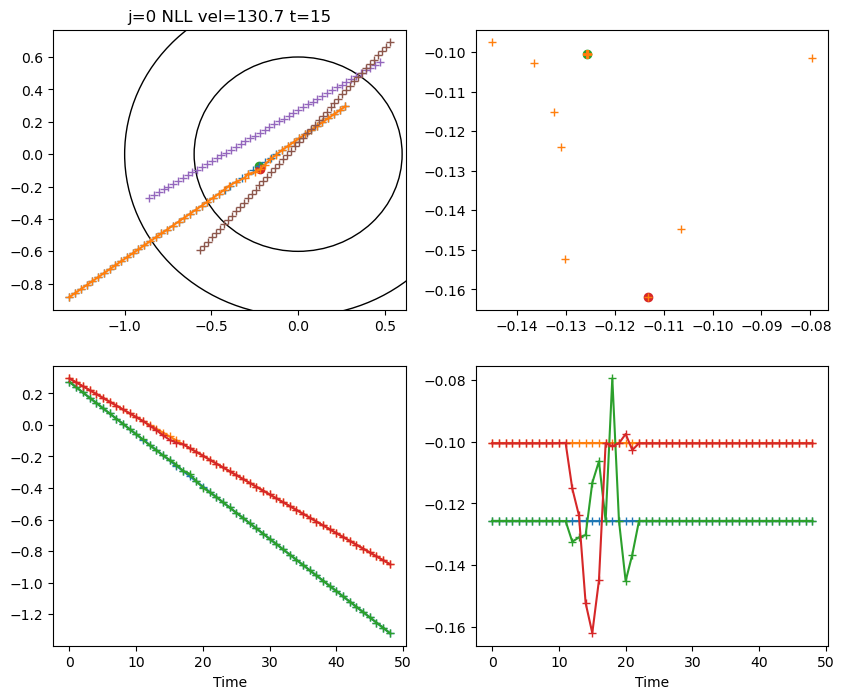

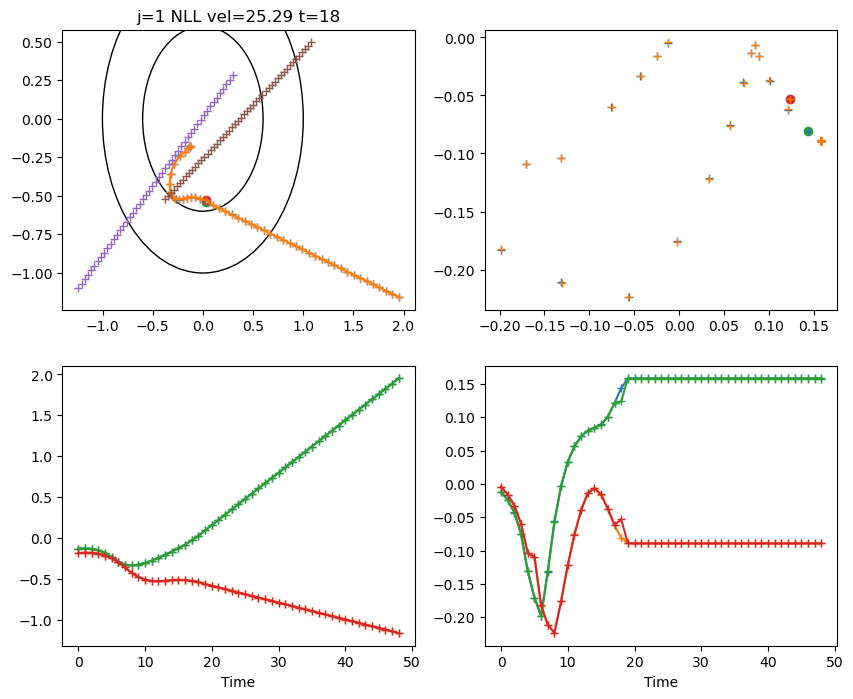

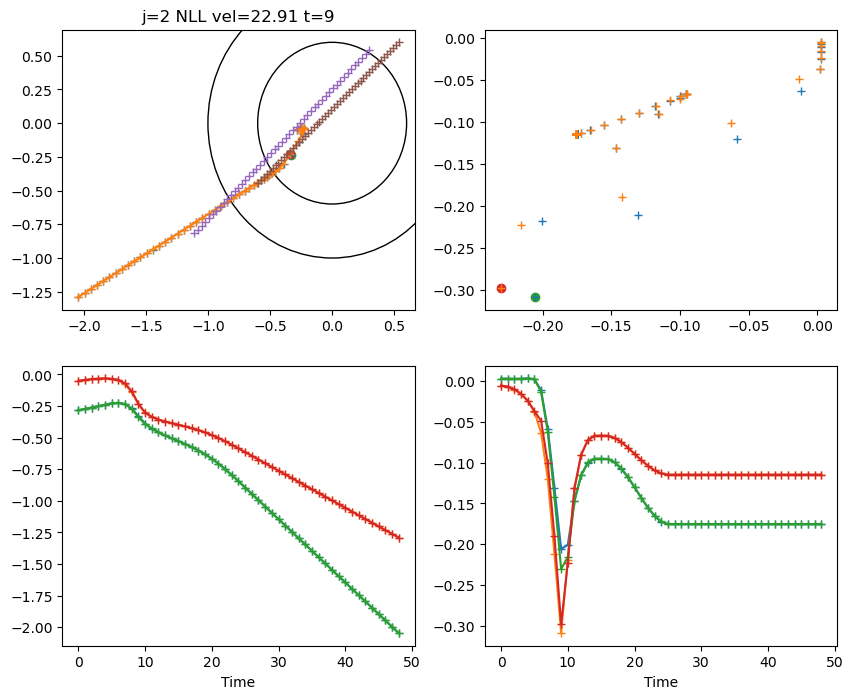

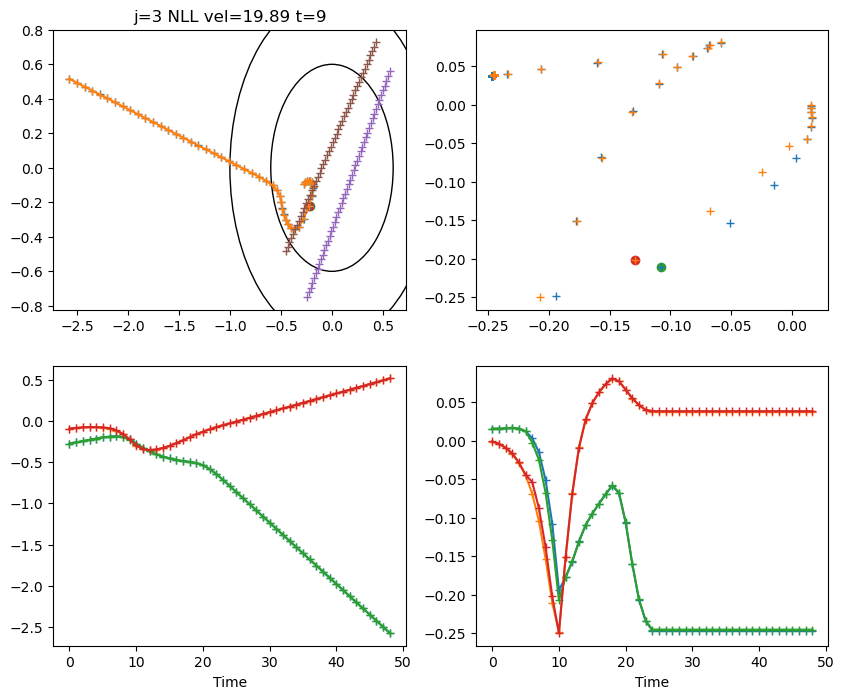

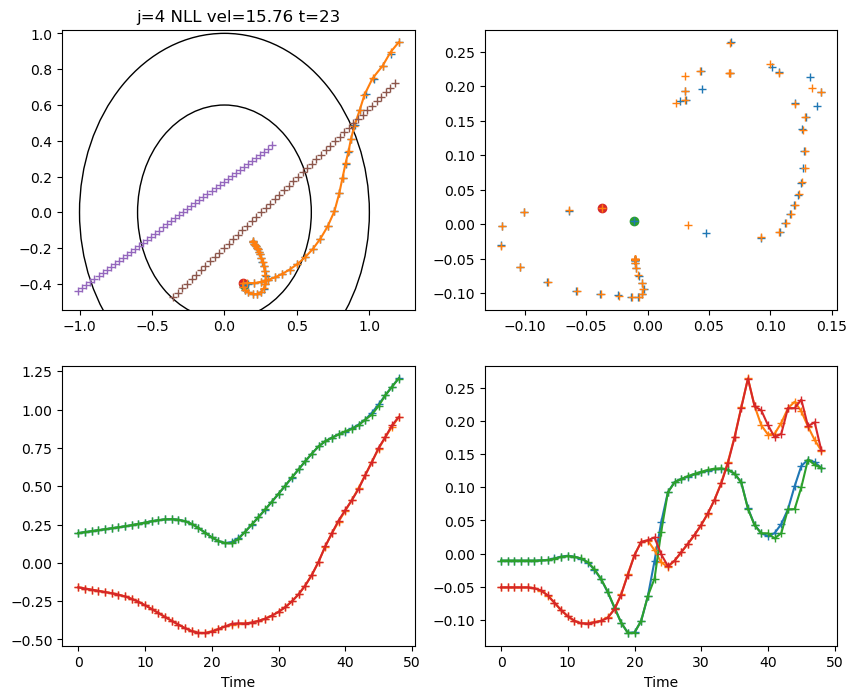

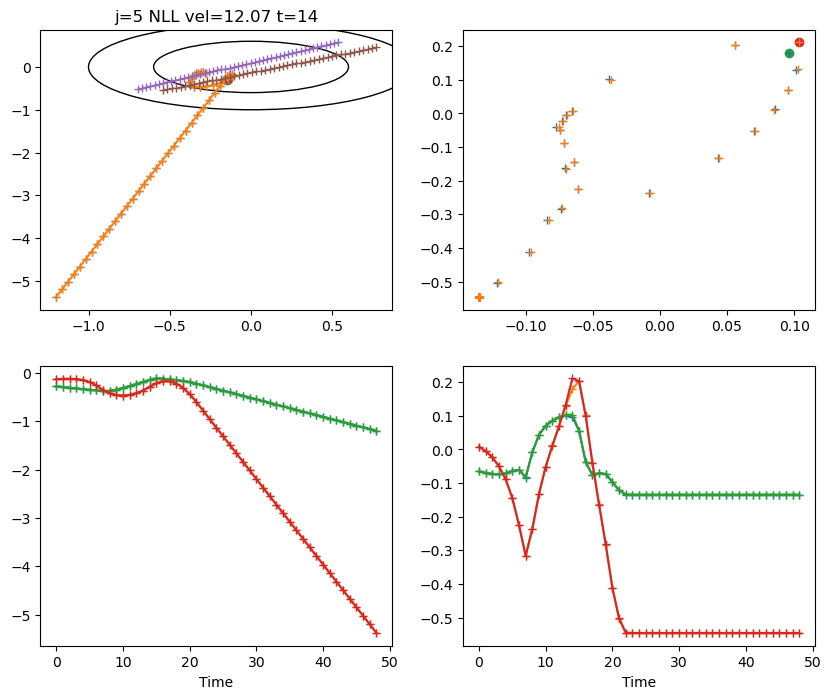

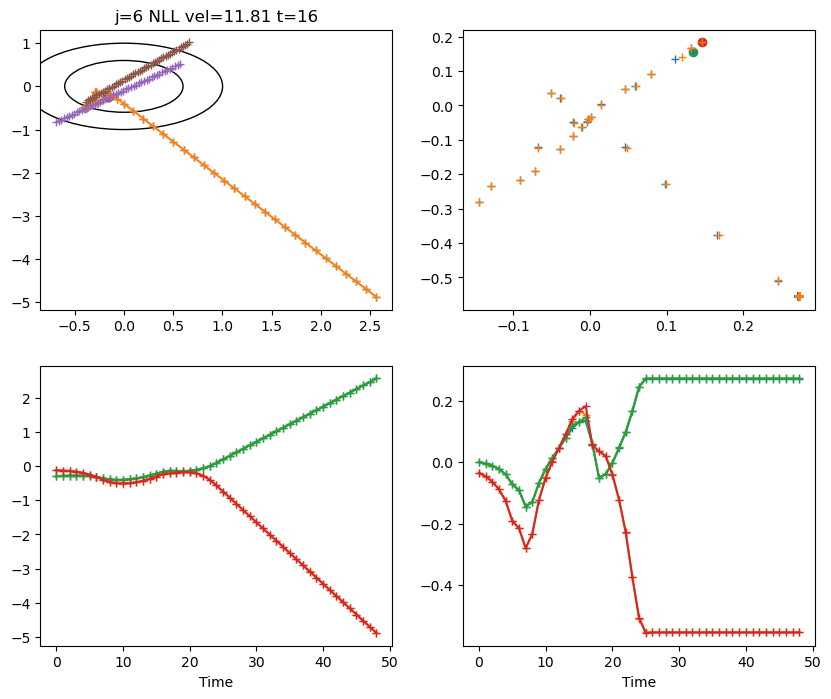

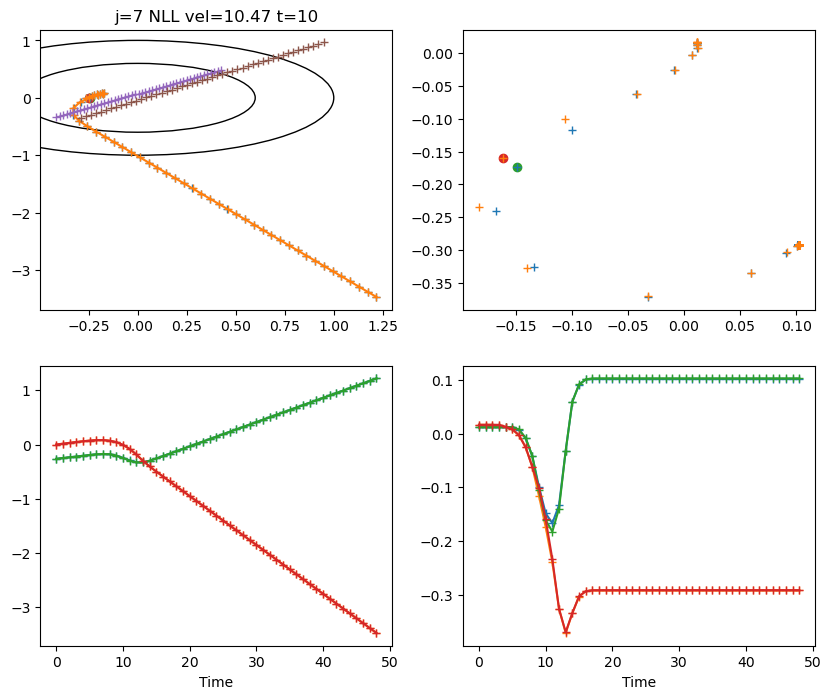

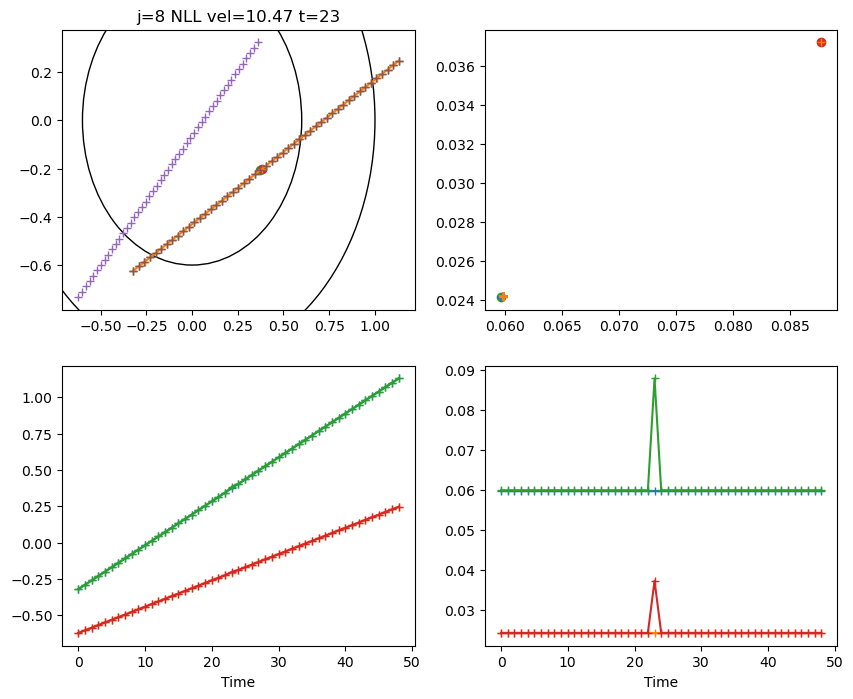

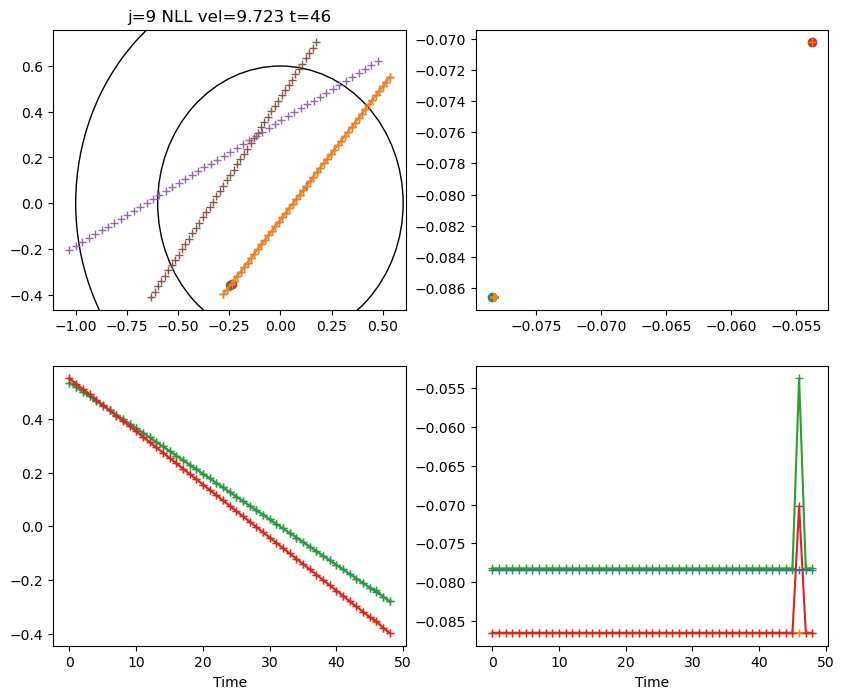

In [164]:
for j, (i,nll_v) in enumerate(zip(top_k_vel,nll_vel_top_k)):
    t = nll_vel_b_mt[i,].sum((-1,-3)).argmax(-1).item()
    p = nll_vel_b_mt[i,:,t].sum(-1).argmax(-1).item()
    fig, axs = plt.subplots(2,2, figsize=(10,8))
    axs = axs.flatten()
    axs[0].set_title(f'{j=} NLL vel={nll_v:.4g} {t=}')
    axs[0].plot(*target_b[i,:,p,:2].T.cpu(), '+');
    axs[0].plot(*predictions_b[i,:,p,:2].T.cpu(), '+-');
    axs[0].plot(*target_b[i,t,p,:2].T.cpu(), 'o', zorder=-1);
    axs[0].plot(*predictions_b[i,t,p,:2].T.cpu(), 'o', zorder=-1);
    axs[0].plot(*target_b[i,:,1*n,:2].T.cpu(), '+');
    axs[0].plot(*target_b[i,:,0*n,:2].T.cpu(), '+');
    axs[0].set(xlim=axs[0].get_xlim(),ylim=axs[0].get_ylim())
    axs[0].add_patch(plt.Circle(circle_center,circle_radius/ds_train.norm, fill=None))
    axs[0].add_patch(plt.Circle(circle_center,model.Rinterior, fill=None))
    axs[1].plot(*target_b[i,:,p,2:].T.cpu(), '+');
    axs[1].plot(*predictions_b[i,:,p,2:].T.cpu(), '+');
    axs[1].plot(*target_b[i,t,p,2:].T.cpu(), 'o', zorder=-1);
    axs[1].plot(*predictions_b[i,t,p,2:].T.cpu(), 'o', zorder=-1);

    axs[2].plot(target_b[i,:,p,:2].cpu(), '+-');
    axs[2].plot(predictions_b[i,:,p,:2].cpu(), '+-');
    axs[3].plot(target_b[i,:,p,2:].cpu(), '+-');
    axs[3].plot(predictions_b[i,:,p,2:].cpu(), '+-');
    for ax in axs[2:]: ax.set_xlabel('Time');

## Raw preds

In [165]:
target.shape, predictions.shape

(torch.Size([2000, 21, 49, 4]), torch.Size([2000, 21, 49, 4]))

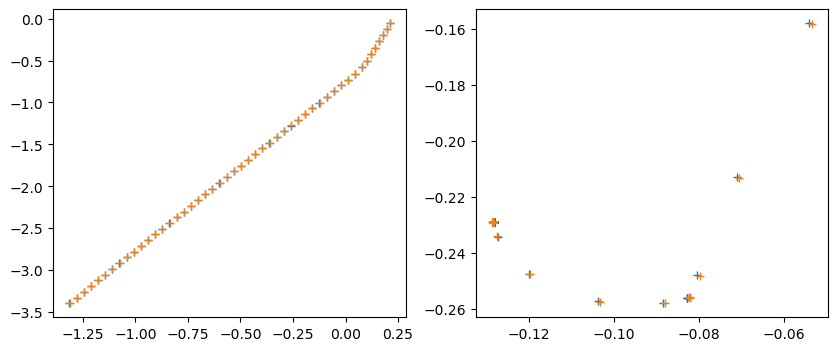

In [166]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].plot(*target_b[i,:,2*n,:2].T.cpu(), '+');
axs[0].plot(*predictions_b[i,:,2*n,:2].T.cpu(), '+');
axs[1].plot(*target_b[i,:,2*n,2:].T.cpu(), '+');
axs[1].plot(*predictions_b[i,:,2*n,2:].T.cpu(), '+');

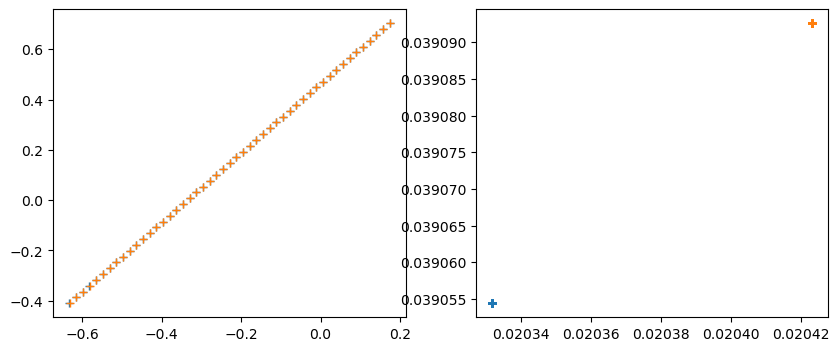

In [167]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].plot(*target_b[i,:,0,:2].T.cpu(), '+');
axs[0].plot(*predictions_b[i,:,0,:2].T.cpu(), '+');
axs[1].plot(*target_b[i,:,0,2:].T.cpu(), '+');
axs[1].plot(*predictions_b[i,:,0,2:].T.cpu(), '+');

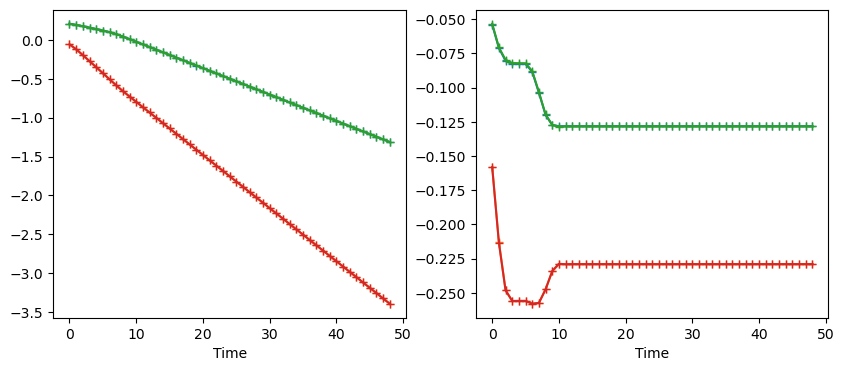

In [168]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].plot(target_b[i,:,2*n,:2].cpu(), '+-');
axs[0].plot(predictions_b[i,:,2*n,:2].cpu(), '+-');
axs[1].plot(target_b[i,:,2*n,2:].cpu(), '+-');
axs[1].plot(predictions_b[i,:,2*n,2:].cpu(), '+-');
for ax in axs: ax.set_xlabel('Time');

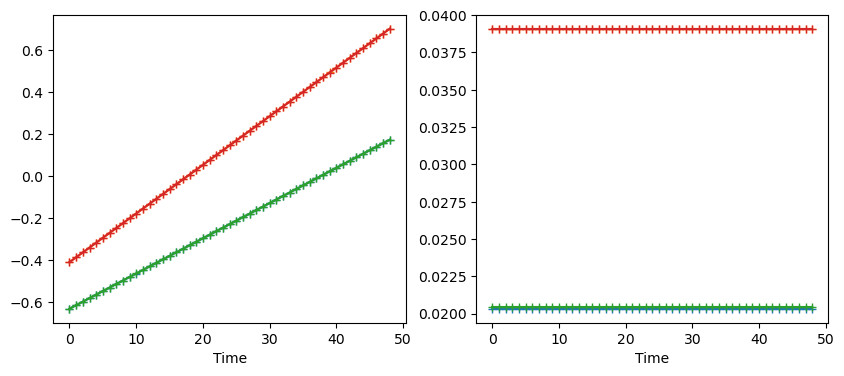

In [169]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].plot(target_b[i,:,0,:2].cpu(), '+-');
axs[0].plot(predictions_b[i,:,0,:2].cpu(), '+-');
axs[1].plot(target_b[i,:,0,2:].cpu(), '+-');
axs[1].plot(predictions_b[i,:,0,2:].cpu(), '+-');
for ax in axs: ax.set_xlabel('Time');

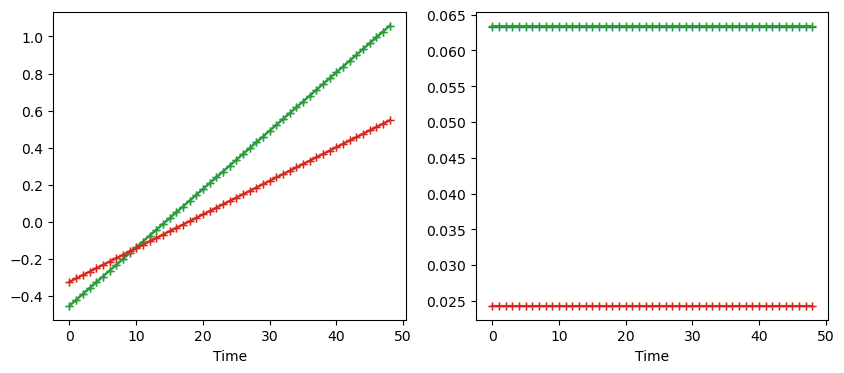

In [170]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].plot(target_b[i,:,1,:2].cpu(), '+-');
axs[0].plot(predictions_b[i,:,1,:2].cpu(), '+-');
axs[1].plot(target_b[i,:,1,2:].cpu(), '+-');
axs[1].plot(predictions_b[i,:,1,2:].cpu(), '+-');
for ax in axs: ax.set_xlabel('Time');

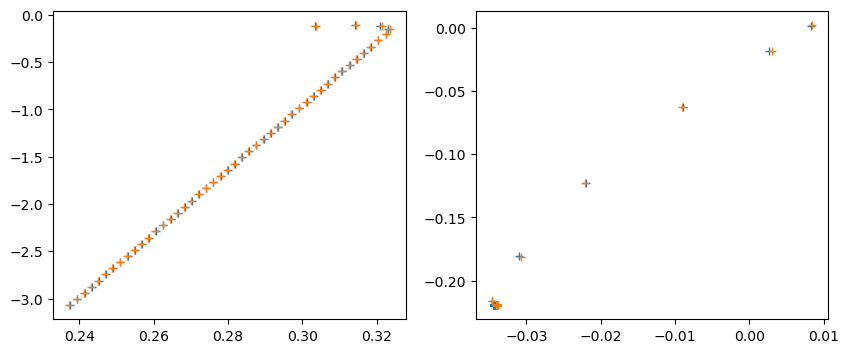

In [171]:
i=0
fig, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].plot(*target_b[i,:,2*n,:2].T.cpu(), '+');
axs[0].plot(*predictions_b[i,:,2*n,:2].T.cpu(), '+');
axs[1].plot(*target_b[i,:,2*n,2:].T.cpu(), '+');
axs[1].plot(*predictions_b[i,:,2*n,2:].T.cpu(), '+');

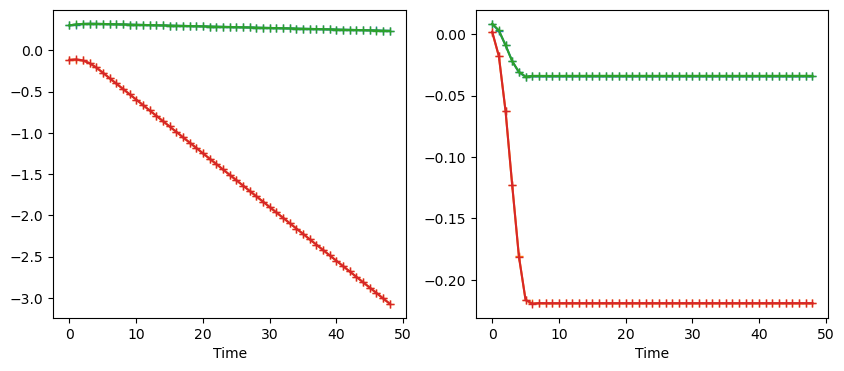

In [617]:
i=0
fig, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].plot(target_b[i,:,2*n,:2].cpu(), '+-');
axs[0].plot(predictions_b[i,:,2*n,:2].cpu(), '+-');
axs[1].plot(target_b[i,:,2*n,2:].cpu(), '+-');
axs[1].plot(predictions_b[i,:,2*n,2:].cpu(), '+-');
for ax in axs: ax.set_xlabel('Time');

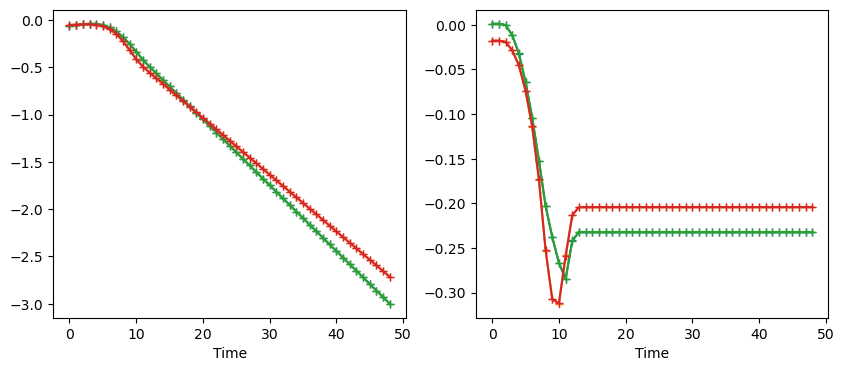

In [618]:
i=1
fig, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].plot(target_b[i,:,2*n,:2].cpu(), '+-');
axs[0].plot(predictions_b[i,:,2*n,:2].cpu(), '+-');
axs[1].plot(target_b[i,:,2*n,2:].cpu(), '+-');
axs[1].plot(predictions_b[i,:,2*n,2:].cpu(), '+-');
for ax in axs: ax.set_xlabel('Time');

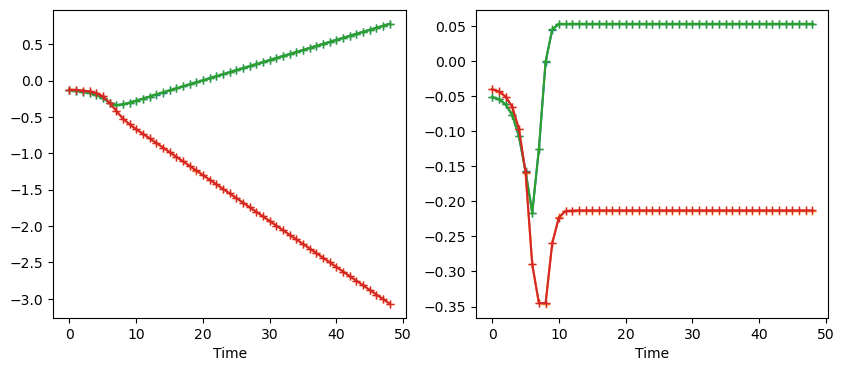

In [619]:
i=21
fig, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].plot(target_b[i,:,2*n,:2].cpu(), '+-');
axs[0].plot(predictions_b[i,:,2*n,:2].cpu(), '+-');
axs[1].plot(target_b[i,:,2*n,2:].cpu(), '+-');
axs[1].plot(predictions_b[i,:,2*n,2:].cpu(), '+-');
for ax in axs: ax.set_xlabel('Time');

In [620]:
N=21

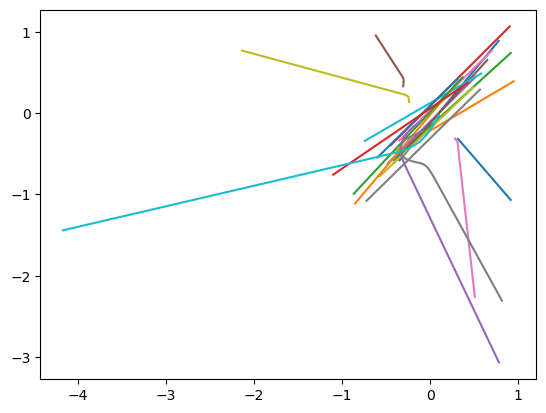

In [621]:
for j in range(N):
    plt.plot(*target_b[i,:,j,:2].cpu().T);

## 1 MSE vs time

In [172]:
def eval_forward_prediction(model, dataset, burn_in_steps, forward_pred_steps,
                            params, return_total_errors=False,bs=None):
    batch_size = params.get('batch_size', 128) if bs is None else bs
    data_loader = DataLoader(dataset, batch_size=batch_size,drop_last=True)# pin_memory=gpu)
    model.eval()
    model.to(dvc)
    total_se = 0
    batch_count = 0
    all_errors = []
    preds = []
    edges = []
    bs = 0
    for batch_ind, batch in tqdm(enumerate(data_loader)):
        node_feats, edge_feats, edge_index = getattrs(batch,['node_feats','edge_feats', 'edge_index'])
        with torch.inference_mode():
            model_inputs = Data(node_feats=node_feats[:,:burn_in_steps],
                                edge_feats=edge_feats[:,:burn_in_steps],
                                edge_index=edge_index,
                                batch=batch.batch
                               )
            model_preds, model_edges = model.predict_future(model_inputs,
                                                            forward_pred_steps,
                                                            return_edges=True,
                                                            return_everything=True)
            preds.append(model_preds)
            edges.append(model_edges)
            # BN, T-1, F
            gt_predictions = node_feats[:,1:] #if True else node_feats[:, burn_in_steps:burn_in_steps+forward_pred_steps]
            batch_count += 1
            mse = F.mse_loss(model_preds,gt_predictions,reduction='none')
            mask_bound = torch.linalg.norm(gt_predictions[...,:2], axis=-1)>model.Rinterior
            # mse[mask_bound] = 0.
            mse = mse.mean(dim=-1)
            if return_total_errors:
                all_errors.append(mse)
            else:
                total_se += mse.sum(dim=0) # T-1
        bs+=len(batch.batch.unique()) # +B
    if return_total_errors:
        return torch.cat(all_errors, dim=0), torch.cat(preds,dim=0), torch.cat(edges,dim=0)
    else:
        return total_se / bs  # bs=len(dataset)

In [173]:
params['data_path'] = '../data/raw/synth3reflective_21/'

In [174]:
params['data_path'] = '../data/raw/synth3_21/'

In [175]:
params['data_path']

'../data/raw/synth3_21/'

In [176]:
test_data = SmallSynthDataPyG(params['data_path'], 'test', params)
forward_pred = test_data.node_feats.shape[2] - params['test_burn_in_steps']  # 50-10
test_mse, test_preds, test_edges = eval_forward_prediction(model,
                                    test_data.datalist,
                                    params['test_burn_in_steps'],
                                    forward_pred, params,
                                    return_total_errors=True,
                                    bs=100
                                   )
test_mse = test_mse.cpu()
path = os.path.join(params['working_dir'], '2024_'+params['error_out_name']%params['test_burn_in_steps'])
#np.save(path, test_mse.cpu().numpy())
print(path)

Using given norm


0it [00:00, ?it/s]

../results/synth3reflective_21/dnri/seed_3/2024_prediction_errors_10step.npy


In [177]:
# np.save('draft/'+'synth3_21_'+'test_mse_burninsteps10', test_mse.cpu().numpy())

In [178]:
params['data_path'], test_preds.shape, test_data.node_feats.shape

('../data/raw/synth3_21/',
 torch.Size([42000, 49, 4]),
 torch.Size([2000, 21, 50, 4]))

In [179]:
test_mse_1  = test_mse.mean(0)[0].item()
test_mse_15 = test_mse.mean(0)[14].item()
test_mse_25 = test_mse.mean(0)[24].item()
print("FORWARD PRED RESULTS:")
print("\t1 STEP: ", test_mse_1)
print("\t15 STEP: ",test_mse_15)
print("\t25 STEP: ",test_mse_25)

FORWARD PRED RESULTS:
	1 STEP:  6.331330837383575e-08
	15 STEP:  3.626288389568799e-06
	25 STEP:  8.304782386403531e-05


In [180]:
test_preds.shape,test_mse.shape

(torch.Size([42000, 49, 4]), torch.Size([42000, 49]))

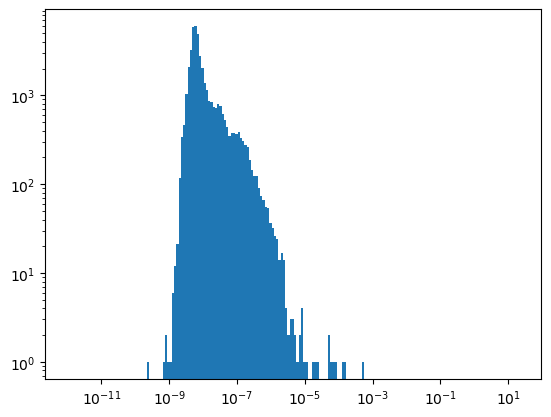

In [181]:
plt.hist(test_mse[:,0], bins=np.concatenate([[0],np.geomspace(1e-12,2e1,200)]), log=True); plt.xscale('log');

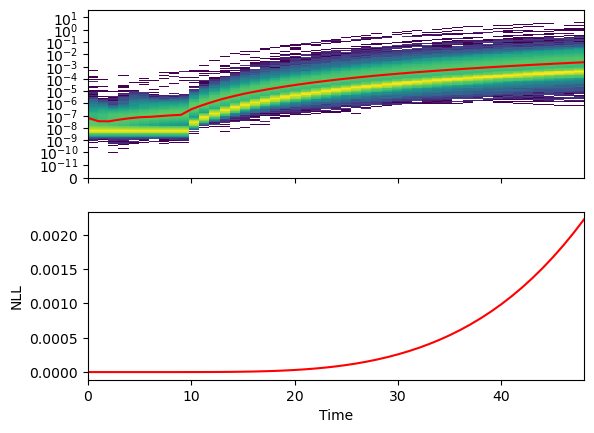

In [182]:
logbins = np.concatenate([[0],np.geomspace(1e-11,4e1,200)])
fig,axs = plt.subplots(2,1, sharex=True )#figsize=(12,4))
axs = axs.flatten()
axs[0].hist2d(np.tile(np.arange(test_mse.shape[-1]),test_mse.shape[0]),
           test_mse.reshape(-1),
           bins = [49,logbins], norm='log'
          );
axs[0].plot(test_mse.mean(0),'r')
axs[0].set_yscale('symlog', linthresh=1e-11)
axs[1].plot(test_mse.mean(0),'r');
axs[1].set_xlabel('Time');axs[1].set_ylabel('NLL');

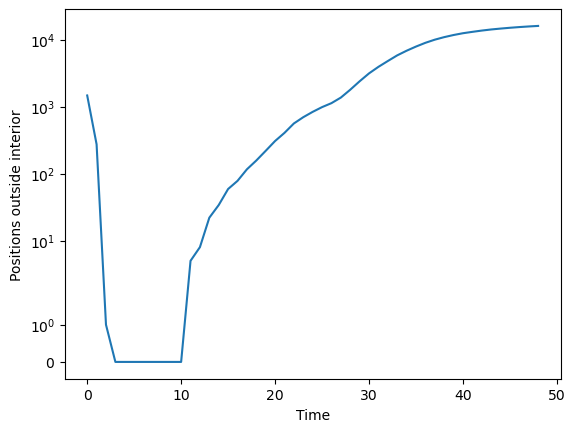

In [183]:
plt.semilogy((test_preds[:,:,:2]>model.Rinterior).any(-1).sum(0).cpu().numpy());
plt.gca().set( xlabel='Time',ylabel='Positions outside interior', yscale='symlog');

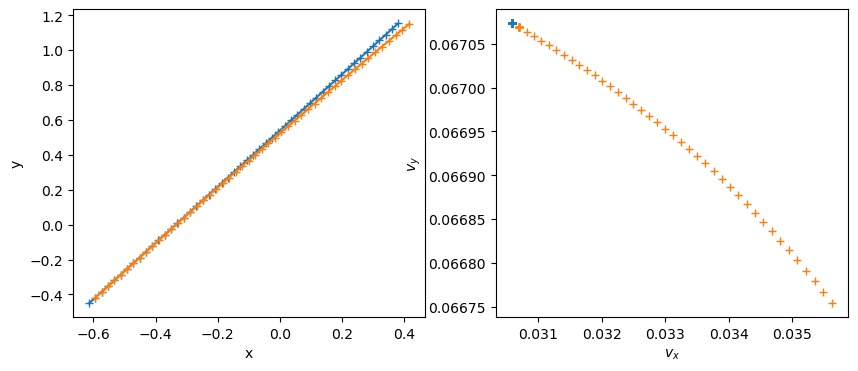

In [184]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
i=0; j=0
axs[0].plot(*test_data.node_feats.reshape(-1,50,4)[i+N*j,:,:2].T.cpu().numpy(),'+-');
axs[0].plot(*test_preds[i+j*N,:,:2].T.cpu().numpy(),'+-');
axs[0].set_xlabel('x');axs[0].set_ylabel('y');
axs[1].plot(*test_data.node_feats[i,j,:,2:].T.cpu().numpy(), '+');
axs[1].plot(*test_preds[i+j*N,:,2:].T.cpu().numpy(), '+');
axs[1].set_xlabel(r'$v_x$');axs[1].set_ylabel(r'$v_y$');

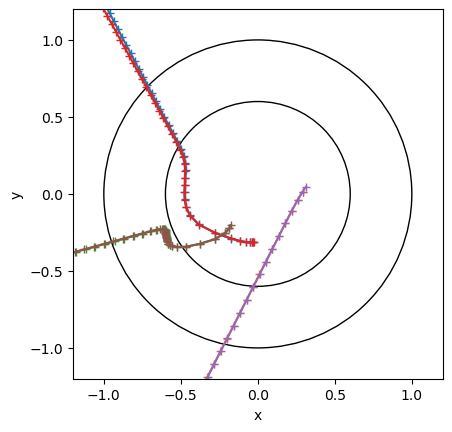

In [185]:
i=6
plt.plot(*test_preds[i*N-1,:,:2].T.cpu().numpy(),'+-');
plt.plot(*test_preds[i*N-2,:,:2].T.cpu().numpy(),'+-');
plt.plot(*test_preds[i*N-3,:,:2].T.cpu().numpy(),'+-');
plt.plot(*test_data.node_feats[i-1,-1,:,:2].T.cpu().numpy(),'+-');
plt.plot(*test_data.node_feats[i-1,-2,:,:2].T.cpu().numpy(),'+-');
plt.plot(*test_data.node_feats[i-1,-3,:,:2].T.cpu().numpy(),'+-');
plt.gca().add_patch(plt.Circle((0,0),.6,fill=None));
plt.gca().add_patch(plt.Circle((0,0),1.,fill=None));
plt.xlim(-1.2,1.2);plt.ylim(-1.2,1.2);
plt.gca().set_aspect('equal');
plt.xlabel('x');plt.ylabel('y');

## 2 Edges

### Compute Spurious edges due to small messages

In [186]:
with torch.inference_mode() and dvc:
    eps = 1e-3
    start_idx = 1 if model.decoder.skip_first_edge_type else 0
    false_edges = torch.zeros_like(edges)  # to correct predicted edges
    assert model.train_hard_sample
    datalist_ = [Data(edge_feats=e, edge=ed)
                 for e,ed in zip(edge_feats[:,:,:-1],
                                 edges.reshape(*edge_feats.shape[:2],
                                               *edges.shape[-2:]))]
    print(f'{len(datalist_)=}')
    dl_ = DataLoader(datalist_, batch_size=batch_size, follow_batch=["edge"])
    # batching-------------------
    bi=0
    for b in tqdm(dl_):
        edge_feats_ = b['edge_feats']
        edges_ = b['edge']

        d = edge_feats_[...,0:1]  # (B*E,T,1) distances
        v = edge_feats_[...,1: ]  # (B*E,T,2) versor
        for i in range(len(model.decoder.edge_functions)):
            msg = model.decoder.edge_functions[i](d)*v    # BE, T, 2
            msg_near_zero = msg.abs().sum(-1)<eps
            # spurious = near zero and predicted as interacting edge
            false_edges[bi:bi+b.edge_ptr[-1],:,i+start_idx] = 1.*(msg_near_zero*edges_[...,i+start_idx])
        bi +=b.edge_ptr[-1]
        #print(bi.item())

    false_edges[...,0] = false_edges[...,start_idx:].sum(-1)
    false_edges[...,start_idx:] = -false_edges[...,start_idx:]
torch.cuda.empty_cache()

len(datalist_)=2000


  0%|          | 0/63 [00:00<?, ?it/s]

In [187]:
false_edges.shape, false_edges.abs().max()

(torch.Size([840000, 49, 3]), tensor(0.9923, device='cuda:0'))

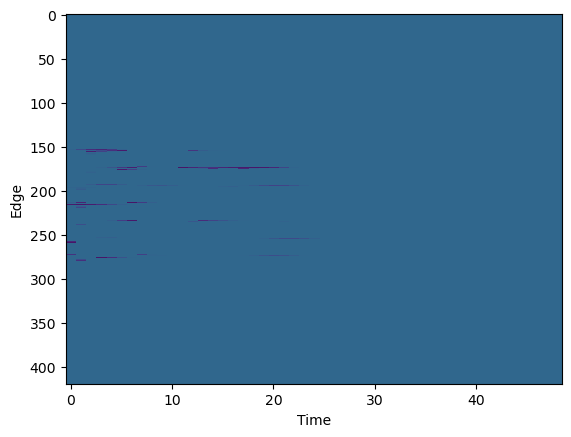

In [188]:
edge_shape = edge_feats.shape[0],params['num_vars']*(params['num_vars']-1),edge_feats.shape[-2]-1,params['num_edge_types']
plt.imshow(false_edges.reshape(edge_shape)[0,...,2].cpu().numpy(),aspect='auto', vmin=-1,vmax=2, interpolation='none');
plt.gca().set( xlabel='Time', ylabel='Edge');

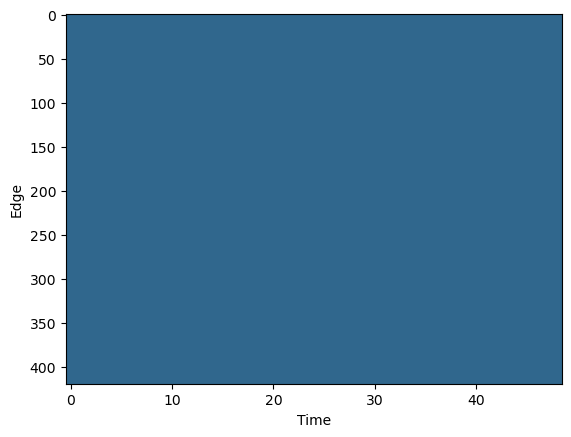

In [189]:
plt.imshow(edges.reshape(edge_shape)[0,...,0].cpu().numpy(),aspect='auto', vmin=-1,vmax=2, interpolation='none');
plt.gca().set( xlabel='Time', ylabel='Edge');

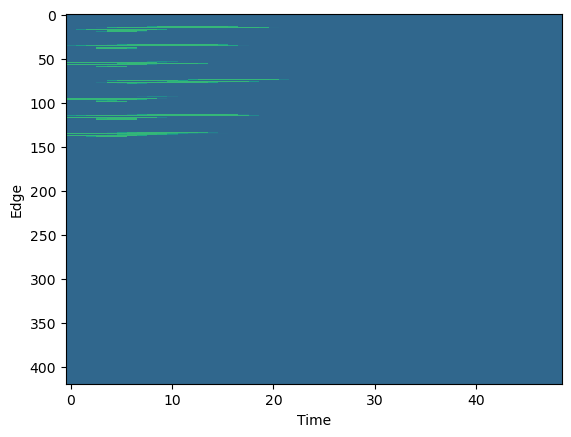

In [190]:
plt.imshow(edges.reshape(edge_shape)[0,...,1].cpu().numpy(),aspect='auto', vmin=-1,vmax=2, interpolation='none');
plt.gca().set( xlabel='Time', ylabel='Edge');

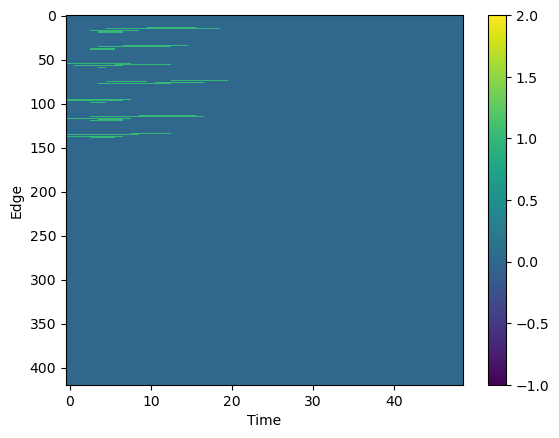

In [191]:
plt.imshow((edges+false_edges).reshape(edge_shape)[0,...,1].cpu().numpy(),aspect='auto', vmin=-1,vmax=2, interpolation='none');
plt.colorbar();
plt.gca().set( xlabel='Time', ylabel='Edge');

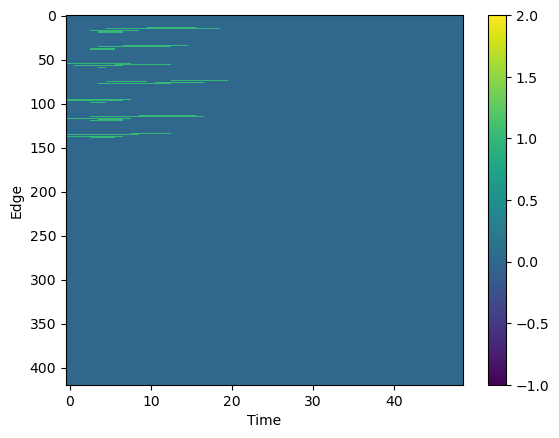

In [192]:
plt.imshow((edges+false_edges).reshape(edge_shape)[0,...,1].cpu().numpy(),aspect='auto', vmin=-1,vmax=2, interpolation='none');
plt.colorbar();
plt.gca().set( xlabel='Time', ylabel='Edge');

### Edge visual structure

In [193]:
edges_ = edges + false_edges

In [194]:
# predicted edges, true
edges_b.shape, edges_pred.shape, edges_true.shape, edges_true_.shape

(torch.Size([2000, 420, 49, 3]),
 torch.Size([2000, 49, 420]),
 torch.Size([2000, 50, 420]),
 torch.Size([2000, 49, 420]))

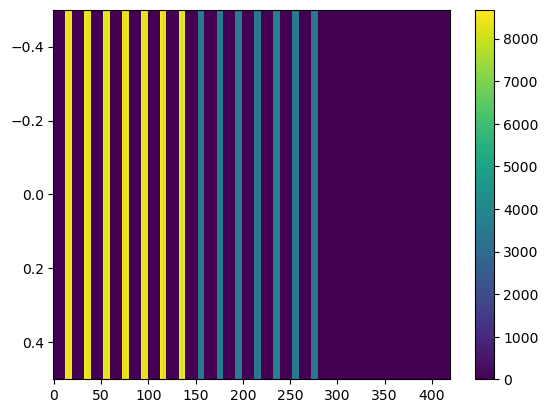

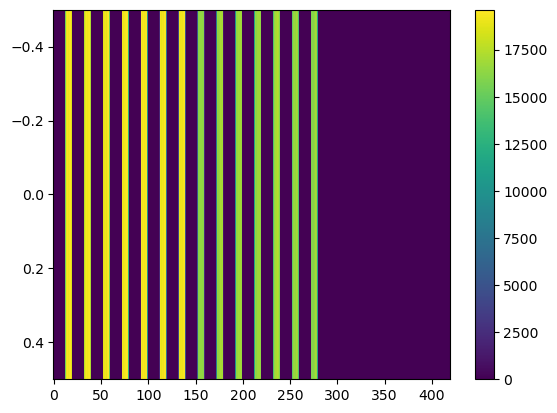

In [195]:
h = plt.imshow((edges_true[:,1:].to(bool).numpy().reshape(-1,edges_true.shape[-1])==True).sum(0)[None], aspect='auto', interpolation='none');
cbar = plt.colorbar(h)
plt.figure();
h=plt.imshow((torch.argmax(edges_b,dim=-1).long().transpose(1,-1).cpu().numpy().reshape(-1,edges_b.shape[1])!=0).sum(0)[None], aspect='auto', cmap=cbar.cmap);
cbar = plt.colorbar(h)

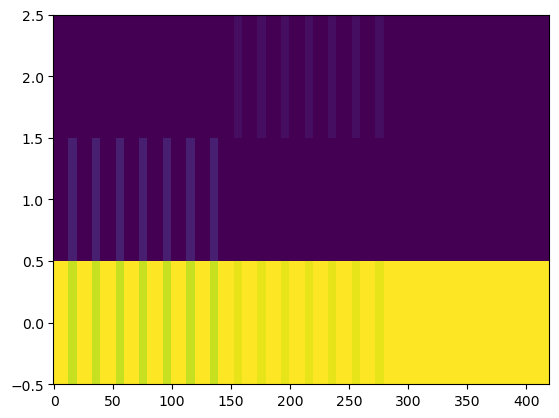

In [196]:
plt.imshow(get_edges_count_table(edges_true_, dim=2),origin='lower', aspect='auto', interpolation='none');

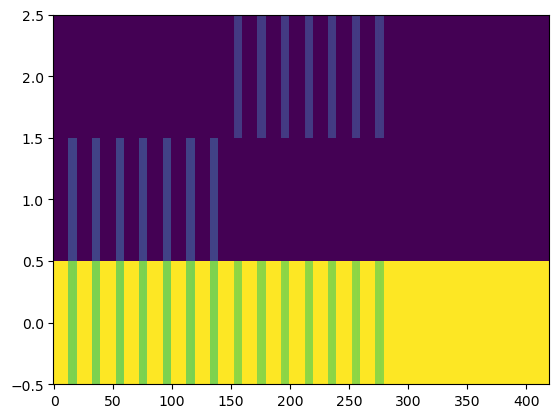

In [197]:
plt.imshow(get_edges_count_table(edges_pred, dim=2),origin='lower', aspect='auto', interpolation='none');

In [198]:
edges_pred.shape

torch.Size([2000, 49, 420])

In [199]:
edges_pred[0,0].shape, row_idx.shape, col_idx.shape

(torch.Size([420]), (420,), (420,))

In [200]:
N

21

In [201]:
params['data_path']

'../data/raw/synth3_21/'

In [966]:
# np.savez_compressed("draft/synth3_21_edge_structure",
#                     N=N,
#                     edges_pred=edges_pred.numpy(),
#                     row_idx=row_idx, col_idx=col_idx
#                    )

In [202]:
adjacency_types = np.zeros((N,N))
adjacency_types[row_idx, col_idx] = edges_pred[0,0].numpy()

In [203]:
def plot_adjacency_matrix(adjacency_types):
    plt.imshow(adjacency_types, cmap='Blues', norm='symlog',
               # to have white zero? TODO linear segmented cmaps with blues
           aspect='equal', interpolation='none', );#extent=(1,N,N,1));
    cbar = plt.colorbar(label='Edge count', pad=0.01); #cbar.set_tick_params(direction='in',);
    plt.ylabel('Sending Node');plt.xlabel('Receiving Node');
    plt.locator_params(nbins=3); plt.tick_params(direction='in', left=False, bottom=False);
    plt.xticks(np.array([0,6,13,20]), ['1','7','14','21'])
    plt.yticks(np.array([0,6,13,20]), ['1','7','14','21'])

In [204]:
np.nonzero(edges_pred[0,0].numpy()==1)

(array([ 17,  35,  37,  55,  57,  95,  97, 115, 117, 135, 137]),)

In [205]:
adjacency_types = np.zeros((N,N))
adjacency_types[row_idx, col_idx] = F.one_hot(edges_pred[0,0], num_classes=3)[:,2].numpy()

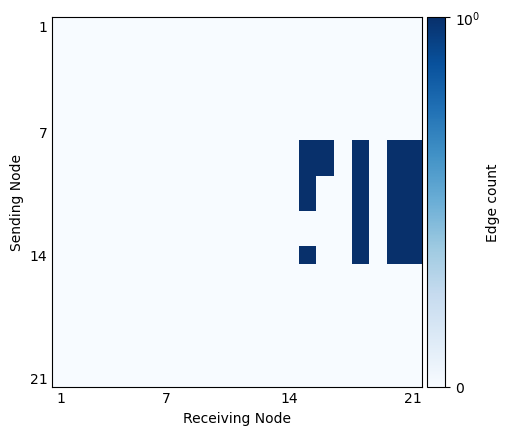

In [206]:
plot_adjacency_matrix(adjacency_types)

In [207]:
adjacency_types = np.zeros((N,N))
adjacency_types[row_idx, col_idx] = edges_pred[0].sum((0)).numpy()

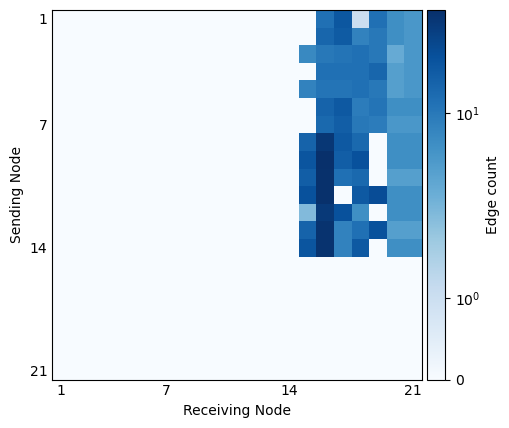

In [208]:
plot_adjacency_matrix(adjacency_types)

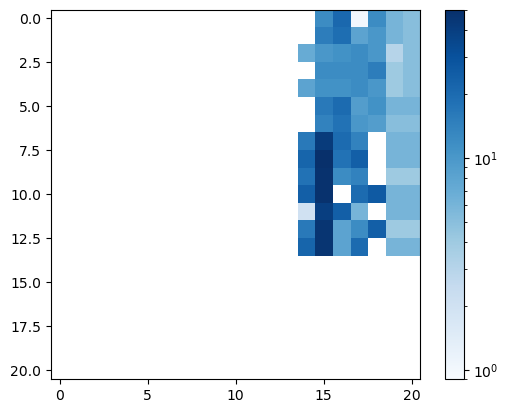

In [209]:
plt.imshow(adjacency_types, cmap='Blues', norm='log',vmin=.9);plt.colorbar();

In [210]:
adjacency_types = np.zeros((N,N))
adjacency_types[row_idx, col_idx] = edges_pred.sum((0,1)).numpy()

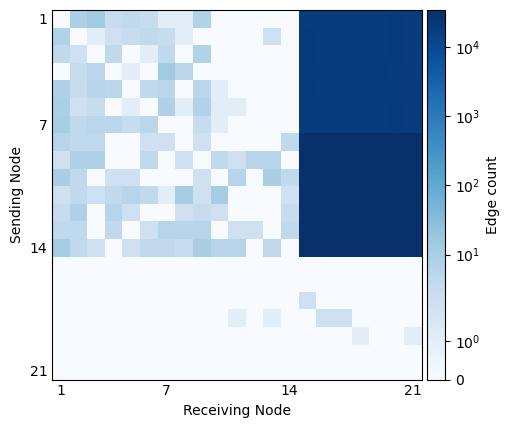

In [211]:
plot_adjacency_matrix(adjacency_types)

### Edges predictions in time

In [214]:
edges_prior  = prior_logits.cpu().detach()
edges_logits = posterior_logits.cpu().detach()

It can happen the encoder classifies an interacting edge with the correct potential learned by the decoder but with the label not matching the arbitrary naming of the edge types.

In [215]:
edge_order = [0,1,2]

In [216]:
edges_prior_b, mask = to_dense_batch(edges_prior,edge_feats_batch.cpu())
edges_logits_b, mask = to_dense_batch(edges_logits,edge_feats_batch.cpu())

In [217]:
edges_prior_b = edges_prior_b.transpose(1,2)
edges_logits_b = edges_logits_b.transpose(1,2)

In [218]:
edges_prior.shape, edges_prior_b.shape, edges_logits.shape, edges_logits_b.shape

(torch.Size([840000, 49, 3]),
 torch.Size([2000, 49, 420, 3]),
 torch.Size([840000, 49, 3]),
 torch.Size([2000, 49, 420, 3]))

In [219]:
import numpy as np
ep = np.argmax(edges_prior_b.numpy()[...,edge_order], axis=-1)
ec = np.argmax(edges_logits_b.numpy()[...,edge_order], axis=-1)

In [220]:
el = np.argmax(torch.nn.functional.gumbel_softmax(edges_logits_b, tau=model.gumbel_temp/2, hard=False,).cpu().numpy()[...,edge_order], axis=-1)

In [221]:
edges_t = edges_true_.numpy()

In [222]:
edges_t.shape, ep.shape, ec.shape, el.shape

((2000, 49, 420), (2000, 49, 420), (2000, 49, 420), (2000, 49, 420))

In [223]:
edges_b.shape

torch.Size([2000, 420, 49, 3])

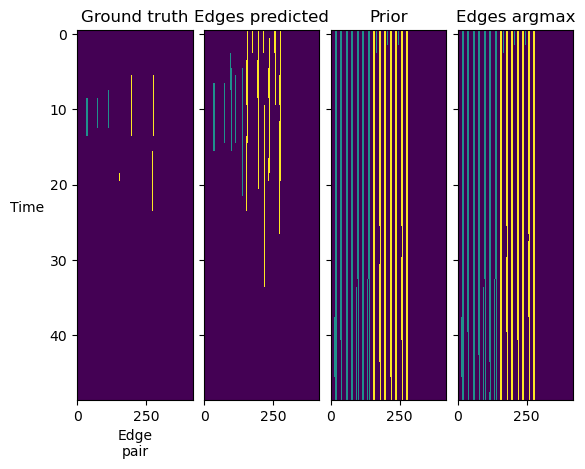

In [224]:
i=2 # timeseries sample
fig, axs = plt.subplots(1,4, sharey=True, gridspec_kw=dict(wspace=0.1))
for ax, x, t in zip(axs,[edges_t[i], edges_b[i,...,edge_order].argmax(-1).T.cpu(), ep[i],ec[i]],
                        ['Ground truth',  'Edges predicted','Prior', 'Edges argmax']):
    ax.imshow(x,aspect='auto', vmin=0,vmax=2, interpolation='none');  ax.set_title(t);

axs[0].set_ylabel('Time', rotation=0, ha='right'); axs[0].set_xlabel('Edge\npair');

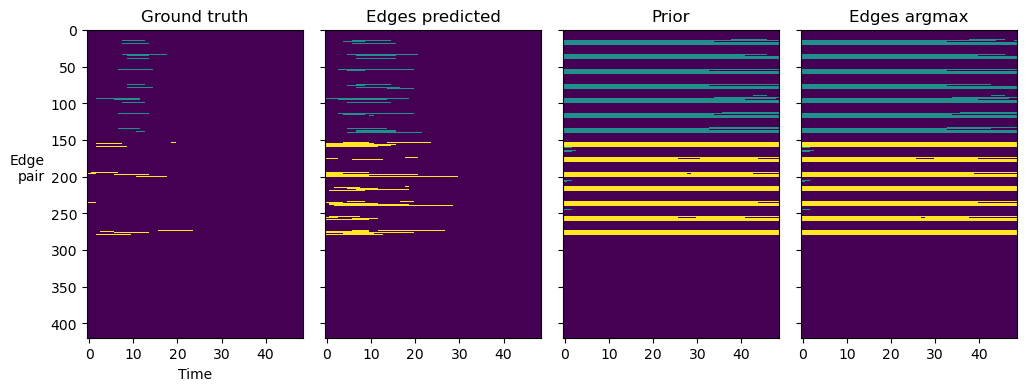

In [225]:
i=2 # timeseries sample
fig, axs = plt.subplots(1,4, sharey=True,figsize=(12,4), gridspec_kw=dict(wspace=0.1))
for ax, x, t in zip(axs,[edges_t[i].T, edges_b[i,...,edge_order].argmax(-1).cpu(), ep[i].T,ec[i].T],
                        ['Ground truth',  'Edges predicted','Prior', 'Edges argmax']):
    ax.imshow(x,aspect='auto', vmin=0,vmax=2, interpolation='none');  ax.set_title(t);

axs[0].set_xlabel('Time'); axs[0].set_ylabel('Edge\npair', rotation=0, ha='right');

### F1 score

In [226]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
def f1_score_dnri(edges_pred, edges_true_, avg=None):
    if isinstance(edges_true_,torch.Tensor): edges_true_ = edges_true_.numpy()
    if isinstance(edges_pred,torch.Tensor): edges_pred = edges_pred.cpu().numpy()
    if avg is None: avg = 'macro' if edges_true_.shape[-1]>2 else 'binary'
    return f1_score(edges_true_.reshape(-1),
                    edges_pred.reshape(-1),
                    average=avg), None

def f1_score_dnri_(edges_pred, edges_true_,):
    if isinstance(edges_true_,torch.Tensor): edges_true_ = edges_true_.numpy()
    if isinstance(edges_pred,torch.Tensor): edges_pred = edges_pred.cpu().numpy()
    return [f1_score(edges_true_[...,i].reshape(-1),
                    edges_pred[...,i].reshape(-1),
                    average='macro' if edges_true_.shape[-1]>2 else 'binary')
           for i in range(edges_pred.shape[-1])]

In [227]:
edges_order = [0,1,2]

In [228]:
f1_score_dnri((edges)[...,edges_order].argmax(-1).cpu().numpy(),
                   edges_true[:,1:].transpose(1,2)) # macro average (equal class weight)

(0.6486533788597763, None)

In [229]:
f1_score_dnri((edges+false_edges)[...,edges_order].argmax(-1).cpu().numpy(),
                   edges_true[:,1:].transpose(1,2))

(0.8058507888476525, None)

In [230]:
f1_score_dnri((edges+false_edges)[...,edges_order].argmax(-1).cpu().numpy(),
              edges_true[:,1:].transpose(1,2),
              avg="micro"
             )

(0.9898833819241982, None)

In [231]:
def f1_score_dnri_none(edges_pred, edges_true_, avg=None):
    if isinstance(edges_true_,torch.Tensor): edges_true_ = edges_true_.numpy()
    if isinstance(edges_pred,torch.Tensor): edges_pred = edges_pred.cpu().numpy()
    return f1_score(edges_true_.reshape(-1),
                    edges_pred.reshape(-1),
                    average=None)
f1_score_dnri_none((edges+false_edges)[...,edges_order].argmax(-1).cpu().numpy(),
              edges_true[:,1:].transpose(1,2))

array([0.99484232, 0.80199938, 0.62071066])

In [232]:
np.array([0.99484252, 0.80198724, 0.62075329]).mean()

0.8058610166666668

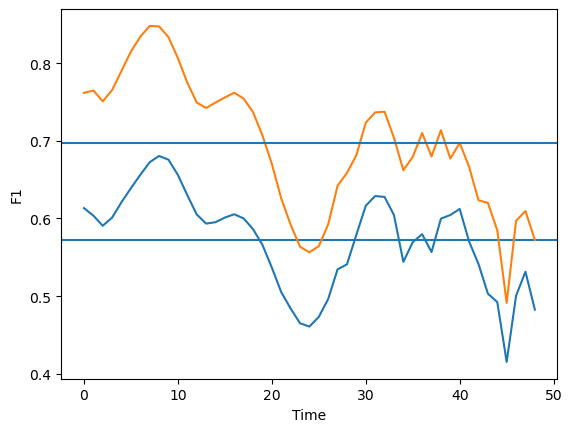

In [796]:
f1_test = f1_score_dnri_((edges)[...,edges_order].argmax(-1).cpu().numpy(),
                   edges_true[:,1:].transpose(1,2))
f1_test_mean = np.mean(f1_test)
plt.plot(f1_test);plt.axhline(f1_test_mean);

f1_test_false = f1_score_dnri_((edges+false_edges)[...,edges_order].argmax(-1).cpu().numpy(),
                   edges_true[:,1:].transpose(1,2))
f1_test_false_mean = np.mean(f1_test_false)
plt.plot(f1_test_false);plt.axhline(f1_test_false_mean);
plt.gca().set( xlabel='Time', ylabel='F1');

In [797]:
edges.shape, edges_true[:,1:].transpose(1,2).shape, mask_loss.shape

(torch.Size([840000, 49, 3]),
 torch.Size([2000, 420, 49]),
 torch.Size([42000, 49]))

In [798]:
mask_loss_edges = (mask_loss[edge_index[0].repeat(mask_loss_b.shape[0])]*mask_loss[edge_index[1].repeat(mask_loss_b.shape[0])]).cpu().numpy()
mask_loss_edges.shape

(840000, 49)

In [799]:
f1_score_dnri((edges)[...,edges_order].argmax(-1).cpu().numpy()[mask_loss_edges],
                   edges_true[:,1:].transpose(1,2).reshape(-1,49)[mask_loss_edges])

(0.6505466817922619, None)

In [800]:
f1_score_dnri((edges+false_edges)[...,edges_order].argmax(-1).cpu().numpy()[mask_loss_edges],
                   edges_true[:,1:].transpose(1,2).reshape(-1,49)[mask_loss_edges])

(0.811171239008393, None)

In [128]:
cm = confusion_matrix(edges_true[:,1:].transpose(1,2).reshape(-1),
                  edges[...,edges_order].argmax(-1).cpu().numpy().reshape(-1),
                  normalize='true'
                 )

cm_ = confusion_matrix(edges_true[:,1:].transpose(1,2).reshape(-1),
                  edges[...,edges_order].argmax(-1).cpu().numpy().reshape(-1),
                  #normalize='true'
                 )

In [129]:
with np.printoptions(precision=3, suppress=True):
    print(cm)
    print(cm_)

[[0.971 0.013 0.016]
 [0.    1.    0.   ]
 [0.    0.    1.   ]]
[[39399625   534362   638983]
 [      68   411676        0]
 [      30        0   175256]]


In [801]:
cm = confusion_matrix(edges_true[:,1:].transpose(1,2).reshape(-1),
                  edges[...,edges_order].argmax(-1).cpu().numpy().reshape(-1),
                  normalize='true'
                 )

cm_ = confusion_matrix(edges_true[:,1:].transpose(1,2).reshape(-1),
                  edges[...,edges_order].argmax(-1).cpu().numpy().reshape(-1),
                  #normalize='true'
                 )

In [802]:
with np.printoptions(precision=3, suppress=True):
    print(cm)
    print(cm_)

[[0.971 0.013 0.016]
 [0.    1.    0.   ]
 [0.    0.    1.   ]]
[[39399635   534364   638971]
 [      63   411681        0]
 [      25        0   175261]]


In [803]:
cm = confusion_matrix(edges_true[:,1:].transpose(1,2).reshape(-1),
                  (edges+false_edges)[...,edges_order].argmax(-1).cpu().numpy().reshape(-1),
                  normalize='true'
                 )

In [804]:
cm_ = confusion_matrix(edges_true[:,1:].transpose(1,2).reshape(-1),
                  (edges+false_edges)[...,edges_order].argmax(-1).cpu().numpy().reshape(-1),
                  #normalize='true'
                 )

In [805]:
with np.printoptions(precision=3, suppress=True):
    print(cm)
    print(cm_)

[[0.99  0.005 0.005]
 [0.005 0.995 0.   ]
 [0.    0.    1.   ]]
[[40158813   200032   214125]
 [    2202   409542        0]
 [      25        0   175261]]


In [861]:
cm

array([[9.89792293e-01, 4.93017889e-03, 5.27752836e-03],
       [5.34798321e-03, 9.94652017e-01, 0.00000000e+00],
       [1.42624054e-04, 0.00000000e+00, 9.99857376e-01]])

### TODO Select best epsilon for spurious edges

In [320]:
f1s_ = [f1_score_dnri((edges)[...,edges_order].argmax(-1).cpu().numpy(),
                   edges_true[:,1:].transpose(1,2))[0]]
cms_ = [confusion_matrix(edges_true[:,1:].transpose(1,2).reshape(-1),
                  edges[...,edges_order].argmax(-1).cpu().numpy().reshape(-1),
                  #normalize='true'
                 )]

In [321]:
f1s_

[0.8088927629625023]

In [322]:
# compute false edges
lin_eps_ = np.geomspace(1e-5, 1e-2, 11)
pre_msg = edge_feats[:,:-1,0:1]  # (B*E,1) # distances
# Run separate MLP for every edge type
# To exlude one edge type, simply offset range by 1
start_idx = 1 if model.decoder.skip_first_edge_type else 0
with torch.no_grad():
    for eps in tqdm(lin_eps_):
        false_edges = torch.zeros_like(edges) # to correct predicted edges out of this function
        for i in range(len(model.decoder.edge_functions)):
            # TODO masked MLP with edges types, pytorch Masked tensors?? still prototipe.
            msg = model.decoder.edge_functions[i](pre_msg)*edge_feats[:,:-1,1:] # BE, 2
            assert model.train_hard_sample
            # message True above epsilon
            msg_near_zero = msg.abs().sum(-1)<eps
            false_edges [...,i+start_idx] = 1.*(msg_near_zero*edges[...,i+start_idx])
    
        false_edges[...,0] = false_edges[...,start_idx:].sum(-1)
        false_edges[...,start_idx:] = -false_edges[...,start_idx:]
    
        f1s_.append(f1_score_dnri((edges+false_edges)[...,edges_order].argmax(-1).cpu().numpy(),
                           edges_true[:,1:].transpose(1,2)))[0]
        torch.cuda.empty_cache()
        cms_.append(confusion_matrix(edges_true[:,1:].transpose(1,2).reshape(-1),
                      (edges+false_edges)[...,edges_order].argmax(-1).cpu().numpy().reshape(-1),
                      #normalize='true'
                     ))
        torch.cuda.empty_cache()

  0%|          | 0/11 [00:00<?, ?it/s]

In [323]:
lin_eps_ = np.concatenate((np.zeros(1),lin_eps_))

In [324]:
cms_ = np.array(cms_)

false_int_count = cms_[:,0,1:].sum(-1)
false_noint_count = cms_[:,1:,0].sum(-1)

In [333]:
for p in zip(f1s_, lin_eps_):
    print(p)

(0.8088927629625023, 0.0)
(0.8090155057918049, 1e-05)
(0.8093859955204158, 1.9952623149688786e-05)
(0.8108266631701723, 3.9810717055349695e-05)
(0.8196866708636024, 7.943282347242821e-05)
(0.9096922238148856, 0.00015848931924611142)
(0.9924661982942099, 0.00031622776601683794)
(0.9950361889588107, 0.000630957344480193)
(0.9911195565623753, 0.0012589254117941675)
(0.9833432438111996, 0.0025118864315095794)
(0.967137044158072, 0.005011872336272719)
(0.9338274480855221, 0.01)


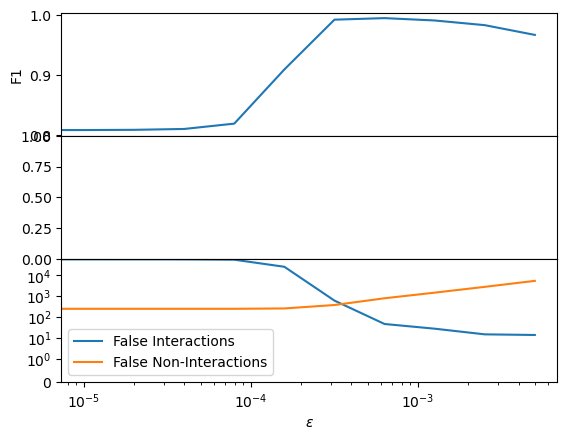

In [331]:
fig,axs = plt.subplots(3,1, sharex=True, gridspec_kw=dict(hspace=0))
eps_f = -1
axs[0].plot(lin_eps_[:eps_f], f1s_[:eps_f]);
# axs[1].plot(lin_eps_[:eps_f], losses[:eps_f]);
axs[2].plot(lin_eps_[:eps_f], false_int_count[:eps_f], label='False Interactions')
axs[2].plot(lin_eps_[:eps_f], false_noint_count[:eps_f], label='False Non-Interactions')
axs[0].set(ylabel='F1', xscale='log', );
# axs[1].set(ylabel='Loss', xscale='log');
axs[2].set(xlabel=r'$\epsilon$', ylim=(0));
plt.yscale('symlog', linthresh=1)

plt.legend();

#### With inference zeroed messages

In [59]:
params['prune_false_edges'] = True

In [118]:
model.gumbel_temp=params['gumbel_temp']=1e-3

In [69]:
test_data = SmallSynthDataPyG(params['data_path'], 'test', params)

In [70]:
edges_true = test_data.edges

In [71]:
edges_true_ = edges_true[:,1:].long().cpu() # from the second timestep to coincide with predicted because first edges is from non-saved features

In [72]:
edges_t = edges_true_.numpy()

In [122]:
losses, f1s, cms = [],[], []
lin_eps = [1e-7, 1e-6,1e-5,1e-4, 1e-3,1e-2, 0.1]
lin_eps = np.geomspace(1e-5, 1e-2, 51)
model.eval()
model.to(dvc)
node_feats, edge_feats = feats.to(dvc), get_dv(feats).to(dvc)  # B, T, N, F
node_feats_test = node_feats
edge_feats_test = edge_feats
edge_index = torch.stack((s_e.cuda(), r_e.cuda()) if params['gpu'] else (s_e, r_e))
# implicit batching
datalist = [Data(node_feats=n, edge_feats=e, edge_index=edge_index)
                     for n,e in zip(node_feats,edge_feats)]

b = Batch.from_data_list(datalist)
node_feats, edge_feats, edge_index = getattrs(b,['node_feats','edge_feats', 'edge_index'])
target = node_feats[:, 1:] if not params['pred_delta'] else inputs.diff(dim=1)[...,:2] # [B:batch, T:time-1, N:num_object, F:num_feats] target the future

with torch.no_grad():
    # Encode input = predict prior and edge class
    prior_logits, posterior_logits, prior_state =  model.encoder(node_feats[:,:-1],edge_feats[:,:-1], edge_index)

    for eps in tqdm(lin_eps):
        model.decoder.eps=eps
        # Decode = predict next timestep features
        hidden = model.decoder.get_initial_hidden(node_feats) # zeros B*N,H
        timesteps = node_feats.size(1)  # T
        edges, predictions, false_edges = [], [], []
        for step in range(timesteps - 1): # T-1
            current_inputs = node_feats[:, step], edge_feats[:,step],edge_index  # B*N, F
            prediction, hidden, edge, false_edge = model.single_step_forward(
                current_inputs,  # B*N, F
                hidden,  # B*N, H
                posterior_logits[:, step],  # B*E, C
                hard_sample=not model.training,
            )
            predictions.append(prediction)  # B*N, F
            edges.append(edge)              # B*E, C
            false_edges.append(false_edge)
        predictions = torch.stack(predictions, dim=1) # B*N, T-1, F
        edges = torch.stack(edges,dim=1) # B*E,T-1,C
        false_edges = torch.stack(false_edges,dim=1)

        # prune false edges
        all_edges = edges
        all_false_edges = false_edges
        all_edges = all_edges + all_false_edges
        all_edges_ = all_edges.argmax(dim=-1).float().cpu()
        if all_edges_[edges_t.transpose(0,2,1).reshape(-1, all_edges.shape[-2])==1].mean()> 1.2 or True: # sort labels
            all_edges_ = all_edges[...,[0,2,1]].argmax(dim=-1).float().cpu()
        f1, *_ = f1_score_dnri(all_edges_,
                               edges_t.transpose(0,2,1).reshape(-1))
        cm = confusion_matrix(edges_t.transpose(0,2,1).reshape(-1),
                              all_edges_.numpy().reshape(-1),
                              # normalize='true',
                             )
        # get loss
        # reconstruction
        loss_nll = model.nll_gaussian(predictions, target)

        # priors
        # learned prior
        prob = F.softmax(posterior_logits, dim=-1)
        loss_kl_learned = model.kl_categorical_learned(prob, prior_logits)
        loss_kl = loss_kl_learned
        # uniform (or guessed) prior
        if params['add_uniform_prior']:
            loss_kl_uniform = model.kl_categorical_avg(prob)
            loss_kl = 0.5 * loss_kl_learned + 0.5 * loss_kl_uniform

        loss = loss_nll + model.kl_coef * loss_kl
        loss = loss.mean().item()

        losses.append(loss)
        f1s.append(f1)
        cms.append(cm)

  0%|          | 0/51 [00:00<?, ?it/s]

In [123]:
cms = np.array(cms)

false_int_count = cms[:,0,1:].sum(-1)
false_noint_count = cms[:,1:,0].sum(-1)

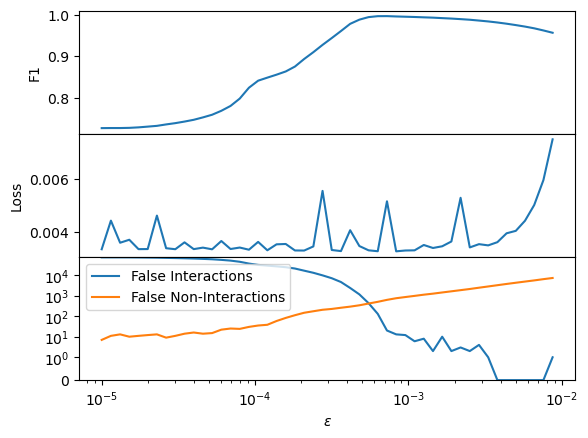

In [124]:
fig,axs = plt.subplots(3,1, sharex=True, gridspec_kw=dict(hspace=0))
eps_f = -1
axs[0].plot(lin_eps[:eps_f], f1s[:eps_f]);
axs[1].plot(lin_eps[:eps_f], losses[:eps_f]);
axs[2].plot(lin_eps[:eps_f], false_int_count[:eps_f], label='False Interactions')
axs[2].plot(lin_eps[:eps_f], false_noint_count[:eps_f], label='False Non-Interactions')
axs[0].set(ylabel='F1', xscale='log', );
axs[1].set(ylabel='Loss', xscale='log');
axs[2].set(xlabel=r'$\epsilon$', ylim=(0));
plt.yscale('symlog', linthresh=1)

plt.legend();

### Posterior Logits vs distance

In [183]:
model.use_supergaussian

True

In [184]:
posterior_logits.max(), posterior_logits.min(), model.super_gaussians._parameters

(tensor(25.5711, device='cuda:0'),
 tensor(-18.9003, device='cuda:0'),
 OrderedDict([('sigma',
               Parameter containing:
               tensor([0.2989, 0.3859], requires_grad=True)),
              ('beta',
               Parameter containing:
               tensor([ 9.9712, 10.0004], requires_grad=True))]))

In [185]:
all_posterior_logits.shape

torch.Size([840000, 49, 3])

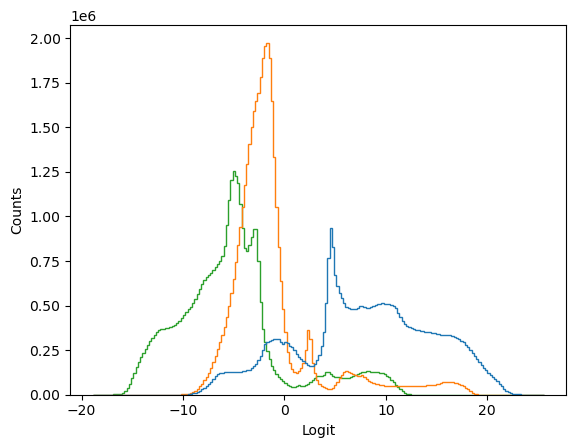

In [186]:
plt.hist(all_posterior_logits.reshape(-1, all_posterior_logits.shape[-1]).cpu().numpy(), 200,histtype='step');
plt.gca().set( xlabel='Logit', ylabel='Counts');

In [187]:
edge_feats[:,:,:-1,0].shape,all_posterior_logits[...,0].shape

(torch.Size([2000, 420, 49]), torch.Size([840000, 49]))

sigma=0.386


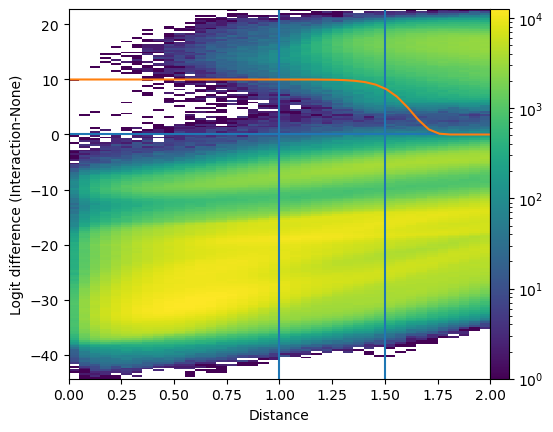

In [188]:
plt.hist2d(norm*edge_feats[:,:,:-1,0].reshape(-1).cpu().numpy(),
           all_posterior_logits[...,2].reshape(-1).cpu().numpy()
           -all_posterior_logits[...,0].reshape(-1).cpu().numpy(),
           200,range=[[0,10],None], norm="log",);
plt.colorbar(pad=0);plt.axvline(1);plt.axvline(1.5);plt.axhline(0);
sigma = model.super_gaussians._parameters['sigma'][1].detach().cpu()
print(f'{sigma=:.3g}')
beta  = model.super_gaussians._parameters['beta'][1].detach().cpu()
x= torch.linspace(0,10,200)/norm
plt.plot(x*norm,
         10*torch.exp(-1.*torch.pow(torch.square(x) / (2. * torch.square(sigma)), beta)),
        c='C1');
plt.xlabel('Distance');plt.ylabel('Logit difference (Interaction-None)');
plt.xlim(0,2);

sigma=0.386


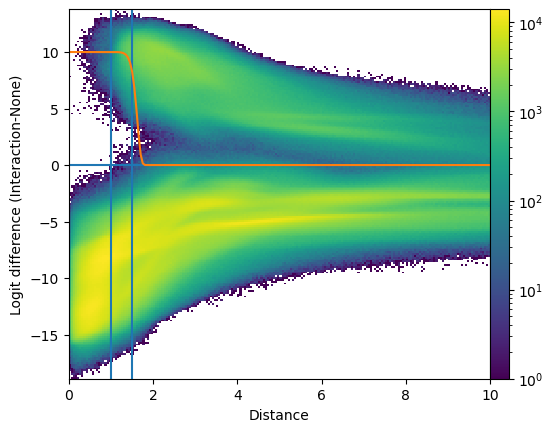

In [189]:
plt.hist2d(norm*edge_feats[:,:,:-1,0].reshape(-1).cpu().numpy(),
           all_posterior_logits[...,2].reshape(-1).cpu().numpy(),
           200,range=[[0,10],None], norm="log",);
plt.colorbar(pad=0);plt.axvline(1);plt.axvline(1.5);plt.axhline(0);
sigma = model.super_gaussians._parameters['sigma'][1].detach().cpu()
print(f'{sigma=:.3g}')
beta  = model.super_gaussians._parameters['beta'][1].detach().cpu()
x= torch.linspace(0,10,200)/norm
plt.plot(x*norm,
         10*torch.exp(-1.*torch.pow(torch.square(x) / (2. * torch.square(sigma)), beta)),
        c='C1');
plt.xlabel('Distance');plt.ylabel('Logit difference (Interaction-None)');
# plt.xlim(0,2);

sigma=0.299


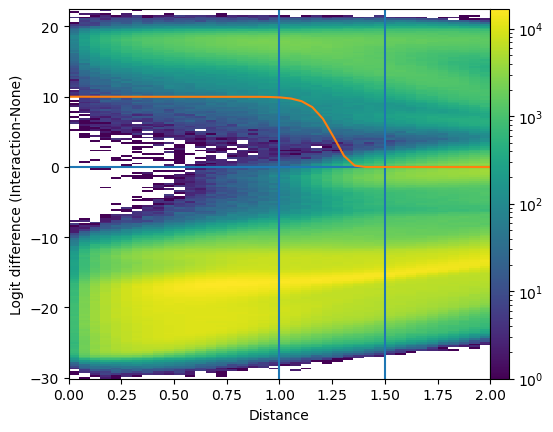

In [190]:
plt.hist2d(norm*edge_feats[:,:,:-1,0].reshape(-1).cpu().numpy(),
           all_posterior_logits[...,1].reshape(-1).cpu().numpy()
           -all_posterior_logits[...,0].reshape(-1).cpu().numpy(),
           200,range=[[0,10],None], norm="log",);
plt.colorbar(pad=0);plt.axvline(1);plt.axvline(1.5);plt.axhline(0);
sigma = model.super_gaussians._parameters['sigma'][0].detach().cpu()
print(f'{sigma=:.3g}')
beta  = model.super_gaussians._parameters['beta'][0].detach().cpu()
x= torch.linspace(0,10,200)/norm
plt.plot(x*norm,
         10*torch.exp(-1.*torch.pow(torch.square(x) / (2. * torch.square(sigma)), beta)),
        c='C1');
plt.xlabel('Distance');plt.ylabel('Logit difference (Interaction-None)');
plt.xlim(0,2);

sigma=0.299


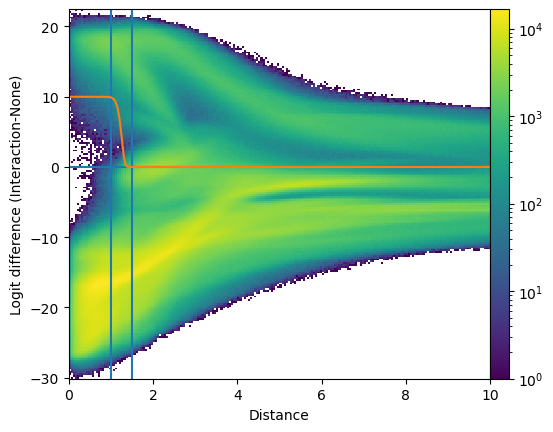

In [191]:
plt.hist2d(norm*edge_feats[:,:,:-1,0].reshape(-1).cpu().numpy(),
           all_posterior_logits[...,1].reshape(-1).cpu().numpy()
           -all_posterior_logits[...,0].reshape(-1).cpu().numpy(),
           200,range=[[0,10],None], norm="log",);
plt.colorbar(pad=0);plt.axvline(1);plt.axvline(1.5);plt.axhline(0);
sigma = model.super_gaussians._parameters['sigma'][0].detach().cpu()
print(f'{sigma=:.3g}')
beta  = model.super_gaussians._parameters['beta'][0].detach().cpu()
x= torch.linspace(0,10,200)/norm
plt.plot(x*norm,
         10*torch.exp(-1.*torch.pow(torch.square(x) / (2. * torch.square(sigma)), beta)),
        c='C1');
plt.xlabel('Distance');plt.ylabel('Logit difference (Interaction-None)');
# plt.xlim(0,2);

In [177]:
gumbels = (-torch.empty_like(all_posterior_logits, memory_format=torch.legacy_contiguous_format)
        .exponential_()
        .log())

In [178]:
gumbels.shape

torch.Size([840000, 49, 3])

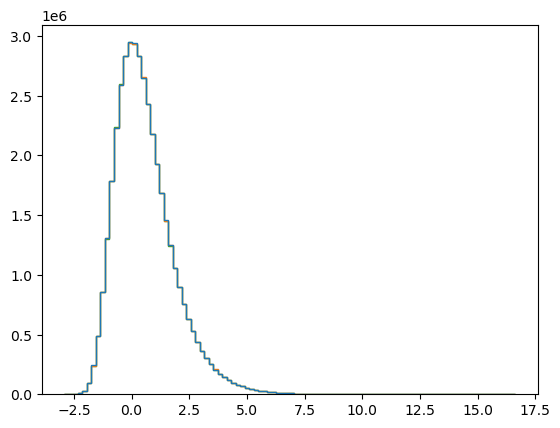

In [182]:
plt.hist(gumbels.reshape(-1,3).cpu().numpy(), 100, histtype='step');

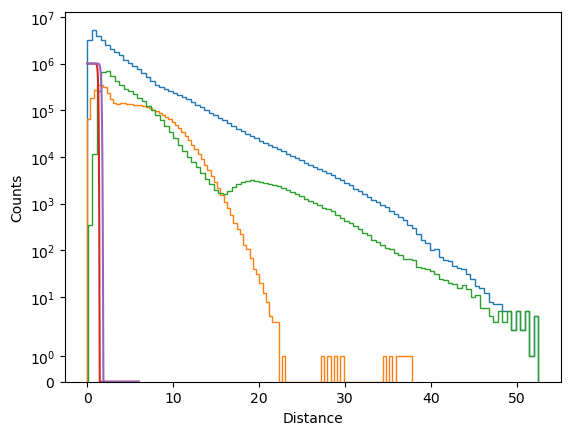

In [225]:
for i in range(all_posterior_logits.shape[-1]):
    plt.hist(ds_train.norm*edge_feats[:,:,:-1,0].reshape(-1)[(all_posterior_logits.argmax(-1)==i).reshape(-1)].cpu().numpy(),100,log=True, histtype='step');
with torch.inference_mode():
    x = torch.linspace(0,6,1000)/ds_train.norm
    for sigma, beta in zip(model.super_gaussians._parameters['sigma'].cpu(),
                           model.super_gaussians._parameters['beta'].cpu()):
        plt.plot(x*ds_train.norm,1e6*torch.exp(-1.*torch.pow(torch.square(x) / (2. * torch.square(sigma)), beta)));
    plt.yscale('symlog');
plt.gca().set( xlabel='Distance', ylabel='Counts');
torch.cuda.empty_cache()

### Edges predictions vs distance

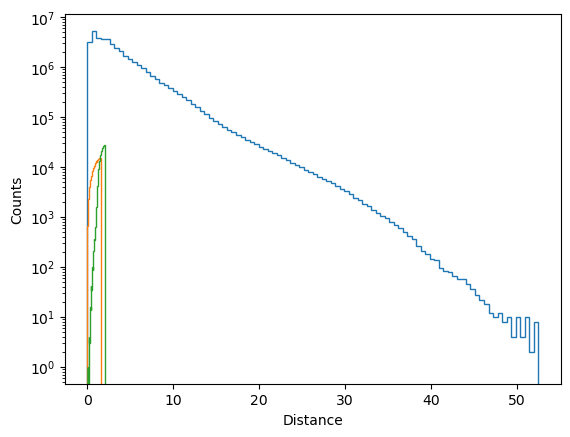

In [985]:
for i in range(3):
    plt.hist(norm*edge_feats[:,:,:-1,0].reshape(-1)[(edges_pred.transpose(2,1)==i).reshape(-1)].cpu().numpy(),100,log=True, histtype='step');
# plt.hist(norm*edge_feats[:,:,:-1,0].reshape(-1)[(edges_pred.transpose(2,1)==0).reshape(-1)].cpu().numpy(),100,log=True, histtype='step');
# with torch.inference_mode():
#     x = torch.linspace(0.9,11,1000)/ds_train.norm
#     sigma = model.super_gaussians._parameters['sigma'].cpu()
#     beta = model.super_gaussians._parameters['beta'].cpu()
#     plt.plot(x*ds_train.norm,1e5*torch.exp(-1.*torch.pow(torch.square(x) / (2. * torch.square(sigma)), beta)));
#     sigma = torch.tensor(0.4);    beta = torch.tensor(10.)
#     plt.plot(x*ds_train.norm,1e5*torch.exp(-1.*torch.pow(torch.square(x) / (2. * torch.square(sigma)), beta)));
#     plt.yscale('symlog');
plt.gca().set( xlabel='Distance', ylabel='Counts');
torch.cuda.empty_cache()

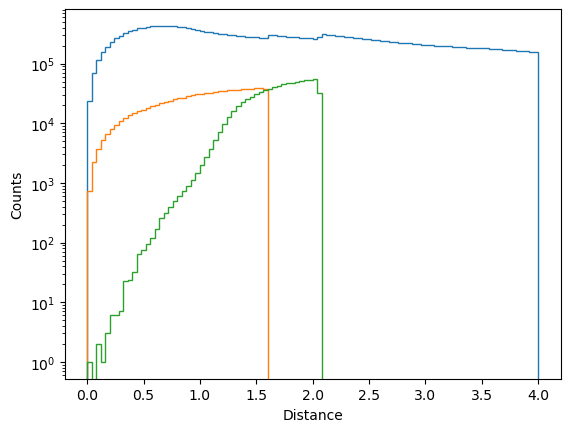

In [991]:
for i in range(3):
    plt.hist(norm*edge_feats[:,:,:-1,0].reshape(-1)[(edges_pred.transpose(2,1)==i).reshape(-1)].cpu().numpy(),
             100,range=[0,4],log=True, histtype='step');
# plt.hist(norm*edge_feats[:,:,:-1,0].reshape(-1)[(edges_pred.transpose(2,1)==0).reshape(-1)].cpu().numpy(),100,log=True, histtype='step');
# with torch.inference_mode():
#     x = torch.linspace(0.9,11,1000)/ds_train.norm
#     sigma = model.super_gaussians._parameters['sigma'].cpu()
#     beta = model.super_gaussians._parameters['beta'].cpu()
#     plt.plot(x*ds_train.norm,1e5*torch.exp(-1.*torch.pow(torch.square(x) / (2. * torch.square(sigma)), beta)));
#     sigma = torch.tensor(0.4);    beta = torch.tensor(10.)
#     plt.plot(x*ds_train.norm,1e5*torch.exp(-1.*torch.pow(torch.square(x) / (2. * torch.square(sigma)), beta)));
#     plt.yscale('symlog');
plt.gca().set( xlabel='Distance', ylabel='Counts');
torch.cuda.empty_cache()

In [993]:
edges_pred.shape, edge_feats.shape, edges_true_.shape

(torch.Size([2000, 49, 420]),
 torch.Size([2000, 420, 50, 3]),
 torch.Size([2000, 49, 420]))

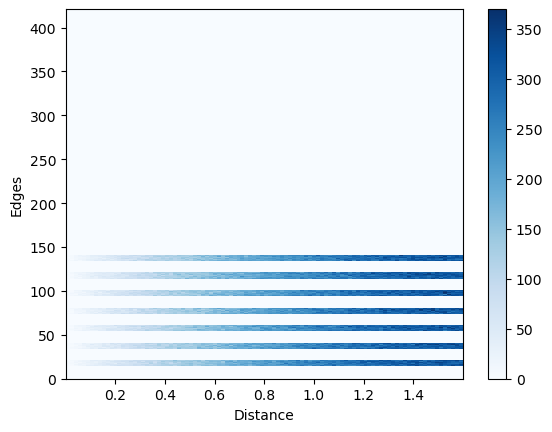

In [1005]:
edges_bins = np.arange(edges_pred.shape[-1]+2)
mask_i  = (edges_pred.transpose(2,1)==1).reshape(-1)
x = norm*edge_feats[:,:,:-1,0].reshape(-1)[mask_i].cpu().numpy()
y = (np.arange(edges_pred.shape[-1])+1)[None,:,None].repeat(edges_pred.shape[0], axis=0).repeat(edges_pred.shape[1],axis=-1).reshape(-1)
y = y[mask_i]
h = plt.hist2d(x,y,bins=[100,edges_bins],cmap='Blues');
bins_d = h[1]
plt.colorbar()
plt.gca().set( xlabel='Distance', ylabel='Edges');

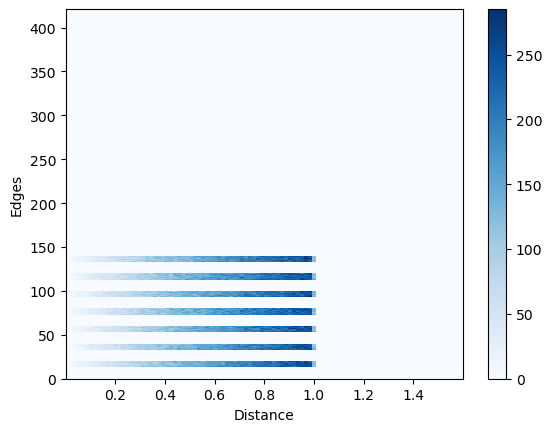

In [1006]:
mask_i  = (edges_true_.transpose(2,1)==1).reshape(-1)
x = norm*edge_feats[:,:,:-1,0].reshape(-1)[mask_i].cpu().numpy()
y = np.arange(edges_pred.shape[-1])[None,:,None].repeat(edges_pred.shape[0], axis=0).repeat(edges_pred.shape[1],axis=-1).reshape(-1)
y = y[mask_i]
h = plt.hist2d(x,y,bins=[bins_d,edges_bins],cmap='Blues');
plt.colorbar()
plt.gca().set( xlabel='Distance', ylabel='Edges');

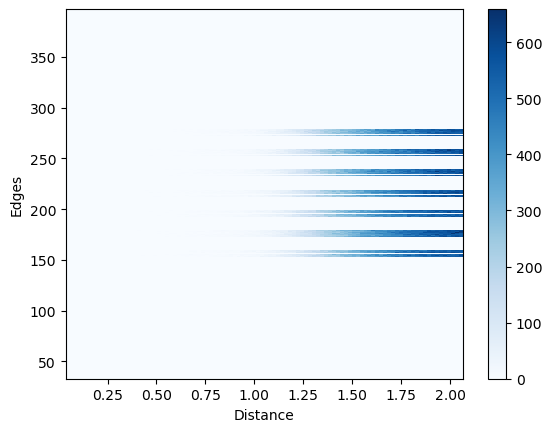

In [981]:
mask_i  = (edges_pred.transpose(2,1)==2).reshape(-1)
x = norm*edge_feats[:,:,:-1,0].reshape(-1)[mask_i].cpu().numpy()
y = np.arange(edges_pred.shape[-1])[None,:,None].repeat(edges_pred.shape[0], axis=0).repeat(edges_pred.shape[1],axis=-1).reshape(-1)
y = y[mask_i]
h = plt.hist2d(x,y,bins=[100,edges_pred.shape[-1]],cmap='Blues');
plt.colorbar()
plt.gca().set( xlabel='Distance', ylabel='Edges');
torch.cuda.empty_cache()

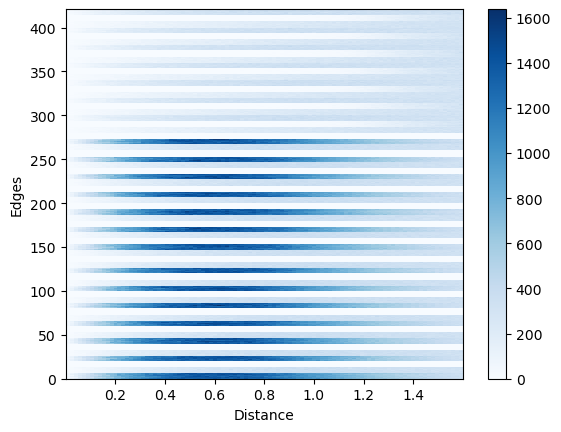

In [1007]:
mask_i  = (edges_pred.transpose(2,1)==0).reshape(-1)
x = norm*edge_feats[:,:,:-1,0].reshape(-1)[mask_i].cpu().numpy()
y = np.arange(edges_pred.shape[-1])[None,:,None].repeat(edges_pred.shape[0], axis=0).repeat(edges_pred.shape[1],axis=-1).reshape(-1)
y = y[mask_i]
h = plt.hist2d(x,y,bins=[bins_d,edges_bins],cmap='Blues');
plt.colorbar()
plt.gca().set( xlabel='Distance', ylabel='Edges');
torch.cuda.empty_cache()

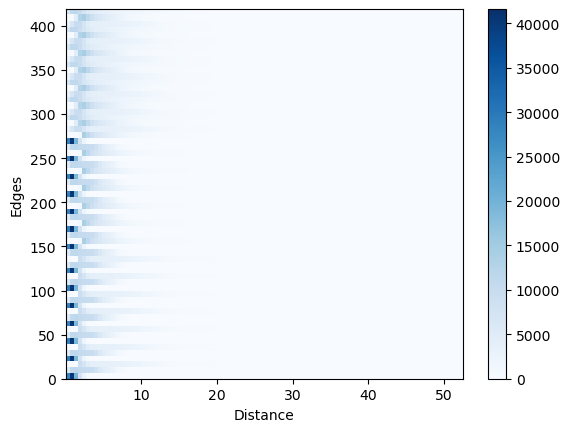

In [986]:
mask_i  = (edges_pred.transpose(2,1)==0).reshape(-1)
x = norm*edge_feats[:,:,:-1,0].reshape(-1)[mask_i].cpu().numpy()
y = np.arange(edges_pred.shape[-1])[None,:,None].repeat(edges_pred.shape[0], axis=0).repeat(edges_pred.shape[1],axis=-1).reshape(-1)
y = y[mask_i]
h = plt.hist2d(x,y,bins=[100,edges_pred.shape[-1]],cmap='Blues');
plt.colorbar()
plt.gca().set( xlabel='Distance', ylabel='Edges');
torch.cuda.empty_cache()

# 3 Extraction of forces

## Active force

In [130]:
def active_force(self, n_points=50):
    self.eval()
    dvc = next(self.parameters()).device
    with torch.no_grad():
        ori = torch.linspace(0.,2*3.14159,n_points,device=dvc)[:,None]
        versor = torch.cat([torch.cos(ori),torch.sin(ori),],dim=-1)[:,None]
        node_feats = torch.linspace(0.,0.5,n_points,device=dvc)[None,:,None]*versor
        agg_msg_zero = torch.zeros(n_points,n_points,2,device=dvc)
        return ori.cpu().numpy(), self.decoder.node_function(torch.cat([node_feats,agg_msg_zero],
                                                                        dim=-1)).cpu().numpy(), node_feats.cpu().numpy()

In [131]:
ori, delta_active, velocities = active_force(model)

In [132]:
ori.shape, delta_active.shape, velocities.shape

((50, 1), (50, 50, 4), (50, 50, 2))

The input to the node function are velocities and zeros.
The first output are deltas of position scaled by delta of time that take a very similar shape to input velocities. The other output are deltas of velocity and are mostly zero. Hence, there is no active force.

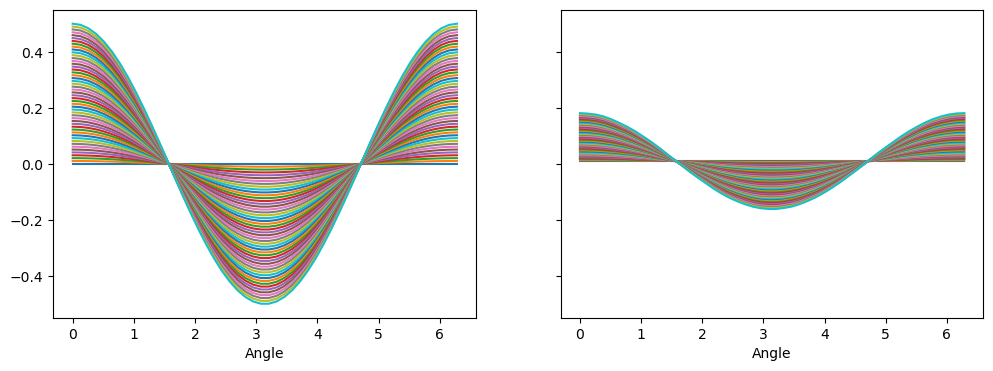

In [133]:
fig, axs = plt.subplots(1,2, figsize=(12,4), sharey=True);
axs[0].plot(ori,   velocities[:,:,0]); # velx
axs[1].plot(ori, delta_active[:,:,0]); # dx
for ax in axs: ax.set(xlabel='Angle',);

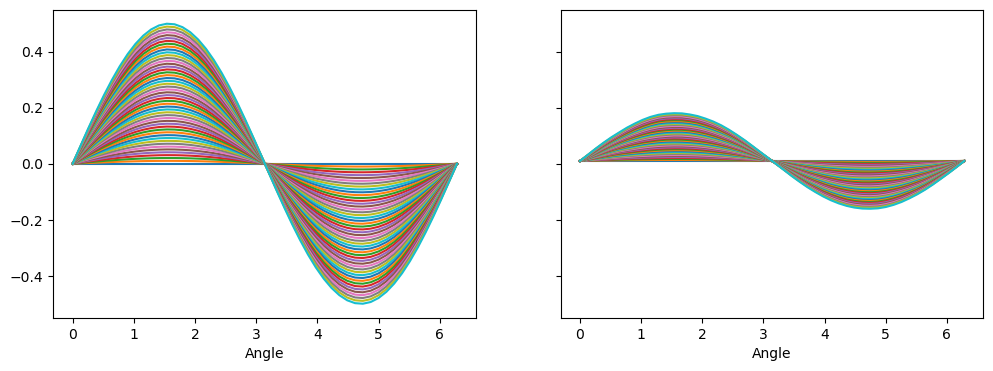

In [134]:
fig, axs = plt.subplots(1,2, figsize=(12,4), sharey=True);
axs[0].plot(ori, velocities[:,:,1]); # vely
axs[1].plot(ori,delta_active[:,:,1]); # dy
for ax in axs: ax.set(xlabel='Angle',);

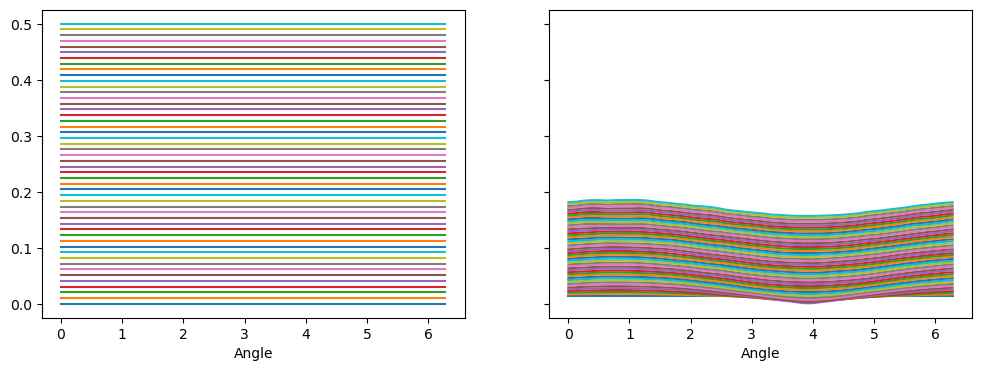

In [135]:
fig, axs = plt.subplots(1,2, figsize=(12,4), sharey=True);
axs[0].plot(ori, np.hypot(velocities[:,:,0],velocities[:,:,1])); # velx
axs[1].plot(ori, np.hypot(delta_active[:,:,0],delta_active[:,:,1])); # dx
for ax in axs: ax.set(xlabel='Angle',);

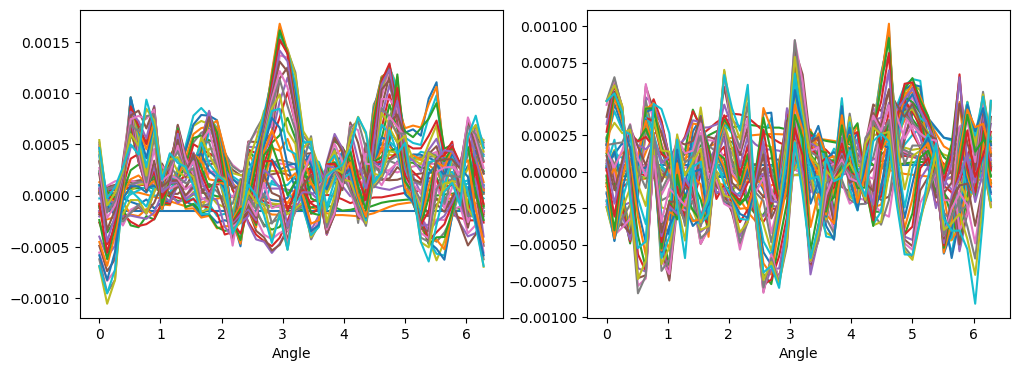

In [136]:
# dv
fig, axs = plt.subplots(1,2, figsize=(12,4));
axs[0].plot(ori,delta_active[:,:,2]); axs[1].plot(ori,delta_active[:,:,3]);
for ax in axs: ax.set(xlabel='Angle',);

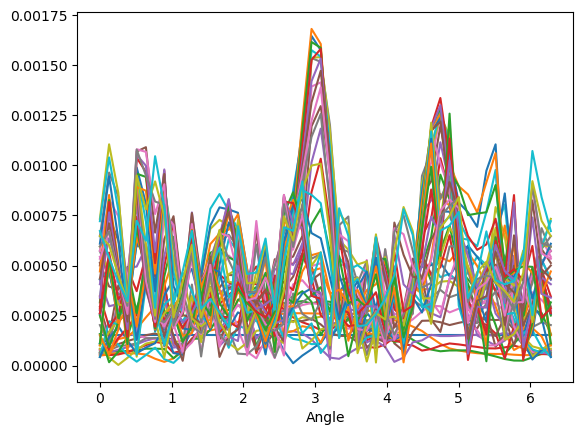

In [137]:
# dv
plt.plot(ori,np.hypot(delta_active[:,:,2],delta_active[:,:,3]));
plt.gca().set( xlabel='Angle',);

## Force magnitude from the messages

Interpreting the message components. As noted in ActiveNet, if the machine learns properly, the message that goes to the node function suffers a linear transformation to become a delta of velocity. Taking advantage of this, we fit the linear transformation and map the messages to forces.

In [138]:
def interparticle_force_modulus(self, d_max=3, n_points=50, j=0, norm=None):
    assert j in [0,1]
    self.eval()
    with torch.no_grad():
        if norm is None:
            train_data = torch.load(os.path.join('../data/raw/synth3reflective_21/', 'train_feats'))
            norm = 0.5*(train_data[:, :, :, :2].max()- train_data[:, :, :, :2].min()).abs() # 0.1
            print(norm)
        else:
            print('Using given Norm')
        aggregate_zero = torch.zeros(n_points,N,256)
        distance = torch.linspace(0.01,d_max, n_points)[None,:, None] # 1, n_points, 1
        d = distance/norm
        alphas = torch.linspace(0,2*3.14159,n_points) # distance versor angle wrt x axis
        ori = torch.linspace(0,2*np.pi,n_points+1,)[:-1,None]
        cos_ori = torch.cos(ori);    sin_ori = torch.sin(ori)
        versor = torch.cat([cos_ori,sin_ori,],dim=-1)[:,None] # n_points,1, 2
        F_inter  = torch.zeros(n_points,n_points, 1) # modulus of N particles at n distances and n alphas
        node_feats = torch.full((n_points,n_points,2),0.04)  # velocity
        edges_ = torch.ones(n_points,n_points,params['num_edge_types']); # n_points, C=3 edge_types

        # for edge_type...j
        norm_msg  = 1
        start_idx = 1 if model.decoder.skip_first_edge_type else 0
        msg = model.decoder.edge_functions[j](d)*versor # n_points, n_points, 2
        msg = msg*edges_[:,:,j+start_idx:j+start_idx+1]    # <-- Encoder z edges predictions
        msg = msg/norm_msg     # (B,E,O)
        F_active = model.decoder.node_function(torch.cat([node_feats, torch.zeros_like(msg)], dim=-1))
        deltas = model.decoder.node_function(torch.cat([node_feats, msg], dim=-1))
        F_inter = torch.hypot(deltas[...,-1]- F_active[...,-1],
                              deltas[...,-2]- F_active[...,-2])
        assert torch.all(torch.isfinite(F_inter))
    return distance.squeeze(), F_inter.detach().numpy(), deltas, ori, node_feats, msg

In [139]:
dist, f, deltas_a, alphas, node_feats, msg = interparticle_force_modulus(model.cpu(),n_points=300,d_max=4, j=0, norm=params['norms']['norm'])

Using given Norm


In [140]:
dist, f2, deltas_a2, alphas, node_feats, msg2 = interparticle_force_modulus(model.cpu(),n_points=300,d_max=4, j=1, norm=params['norms']['norm'])

Using given Norm


In [141]:
norm = params['norms']['norm'].cpu().numpy()
norm_v = params['norms']['norm_v'].cpu().numpy()

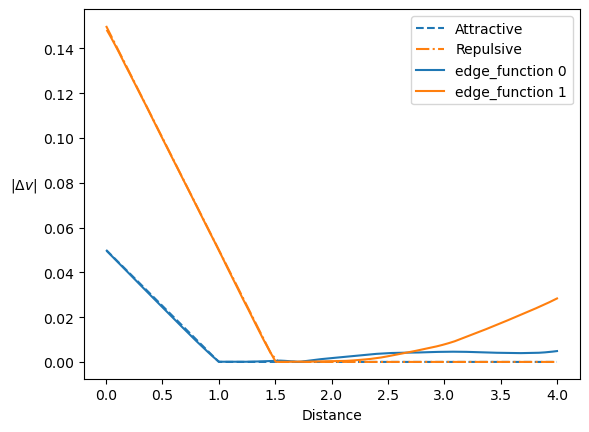

In [142]:
k=0.05;  d_=np.linspace(0,dist.max(),61)
dv_theo1 = np.maximum(0,k*(1-d_))
plt.plot(d_,dv_theo1, '--', label='Attractive');
dv_theo15 = np.maximum(0,2*k*(1.5-d_))
plt.plot(d_,dv_theo15, '-.',label='Repulsive');
plt.plot(dist,f.mean(0)*norm_v,  c=f'C0', label=f'edge_function 0');
plt.plot(dist,f2.mean(0)*norm_v, c=f'C1', label=f'edge_function 1');
plt.xlabel('Distance'); plt.ylabel(r'$|\Delta v|$', rotation=0, ha='right');
plt.legend(ncol=1);

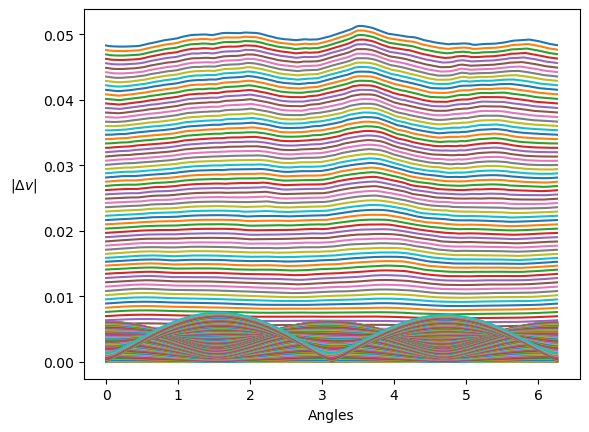

In [143]:
plt.plot(alphas,f*norm_v);plt.xlabel('Angles'); plt.ylabel(r'$|\Delta v|$', rotation=0, ha='right');

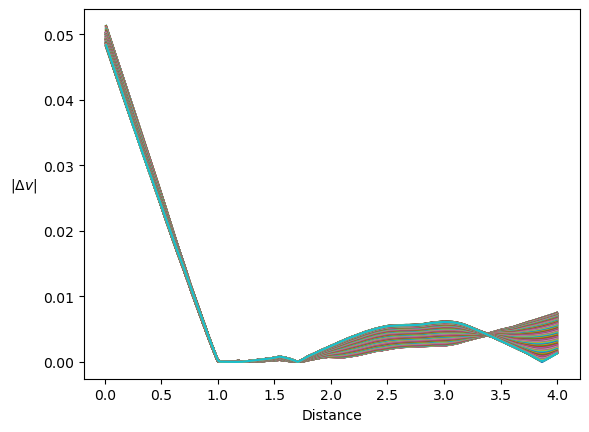

In [144]:
plt.plot(dist,f.T*norm_v);plt.xlabel('Distance'); plt.ylabel(r'$|\Delta v|$', rotation=0, ha='right');

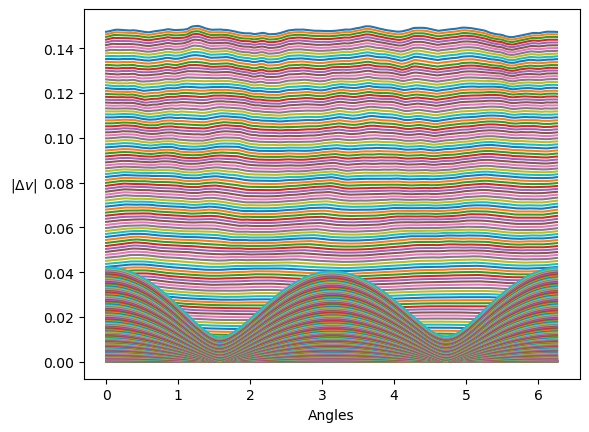

In [145]:
plt.plot(alphas,f2*norm_v);plt.xlabel('Angles'); plt.ylabel(r'$|\Delta v|$', rotation=0, ha='right');

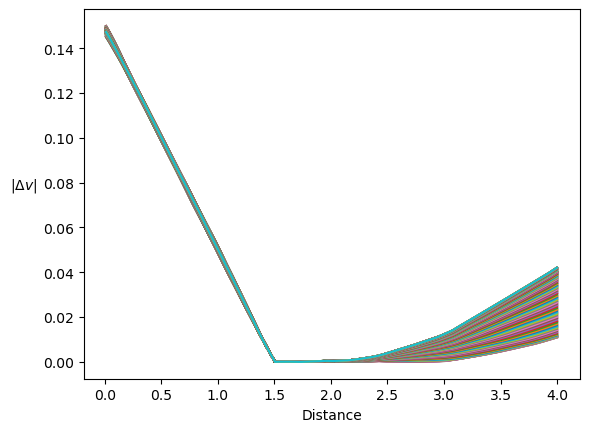

In [146]:
plt.plot(dist,f2.T*norm_v);plt.xlabel('Distance'); plt.ylabel(r'$|\Delta v|$', rotation=0, ha='right');

## Message linear transformation

In [147]:
msg.shape, deltas_a.shape

(torch.Size([300, 300, 2]), torch.Size([300, 300, 4]))

In [148]:
# Define the two sets of 2D points
X = msg.reshape(-1,2)
Y = deltas_a[...,2:].reshape(-1,2)

# Add a column of ones to X for the bias term
X_homogeneous = np.hstack((X, np.ones((X.shape[0], 1))))

# Compute the linear transformation using least squares
A, residuals, rank, s = np.linalg.lstsq(X_homogeneous, Y, rcond=None)

# Print the linear transformation matrix
print(A)

# Apply the linear transformation to X
transformed_X = np.dot(X_homogeneous, A)

[[-2.98860736e-01 -7.26690570e-03]
 [-6.52026497e-04 -3.36431024e-01]
 [ 1.85177595e-04 -2.64944757e-05]]


In [149]:
r2 = 1 - residuals / (Y.numpy().size * Y.var().numpy());r2

array([0.99967224, 0.99948928])

In [150]:
transformed_X.shape

(90000, 2)

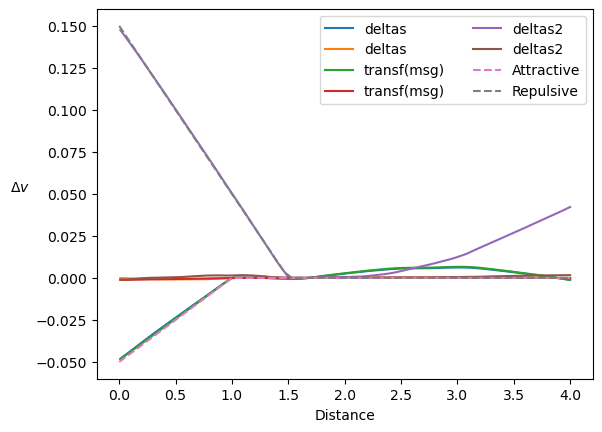

In [151]:
plt.plot(dist,deltas_a[0,:,2:]*norm_v, label='deltas');
plt.plot(dist,transformed_X.reshape(300,300,2)[0]*norm_v, label='transf(msg)');
plt.plot(dist,deltas_a2[0,:,2:]*norm_v, label='deltas2');
plt.plot(d_,-dv_theo1, '--', label='Attractive');
plt.plot(d_,dv_theo15, '--',label='Repulsive');
plt.legend(ncol=2);plt.xlabel('Distance'); plt.ylabel(r'$\Delta v$', rotation=0, ha='right');

In [152]:
# Define the two sets of 2D points
X2 = msg2.reshape(-1,2)
Y2 = deltas_a2[...,2:].reshape(-1,2)

# Add a column of ones to X for the bias term
X_homogeneous2 = np.hstack((X2, np.ones((X2.shape[0], 1))))

# Compute the linear transformation using least squares
A2, residuals, rank, s = np.linalg.lstsq(X_homogeneous2, Y2, rcond=None)

# Print the linear transformation matrix
print(A2)

# Apply the linear transformation to X
transformed_X2 = np.dot(X_homogeneous2, A2)

[[-3.02712520e-01 -1.80099154e-03]
 [-1.19070094e-04 -3.39427044e-01]
 [ 2.97403020e-04 -1.97162209e-05]]


In [153]:
r2 = 1 - residuals / (Y2.numpy().size * Y2.var().numpy());r2

array([0.99990478, 0.99987213])

In [154]:
A_ = [A,A2]

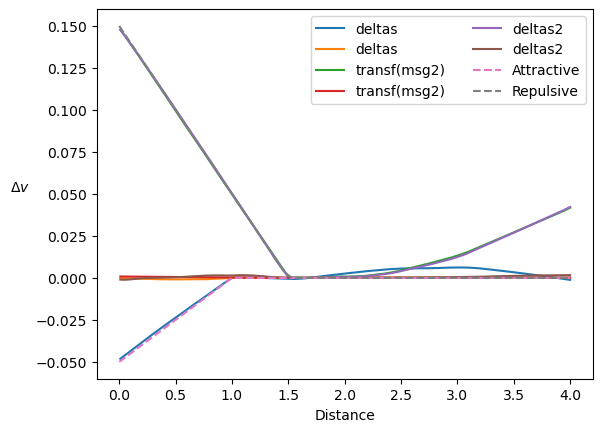

In [155]:
plt.plot(dist,deltas_a[0,:,2:]*norm_v, label='deltas');
plt.plot(dist,transformed_X2.reshape(300,300,2)[0]*norm_v, label='transf(msg2)');
plt.plot(dist,deltas_a2[0,:,2:]*norm_v, label='deltas2');
plt.plot(d_,-dv_theo1, '--', label='Attractive');
plt.plot(d_,dv_theo15, '--',label='Repulsive');
plt.legend(ncol=2);plt.xlabel('Distance'); plt.ylabel(r'$\Delta v$', rotation=0, ha='right');

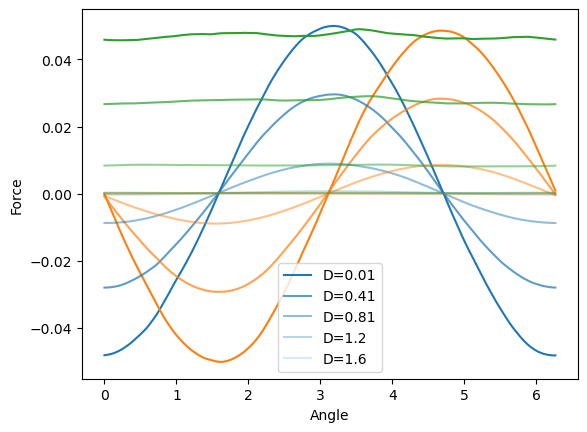

In [156]:
for i in range(0,130,30):
    plt.plot(alphas,deltas_a[:,i,2]*norm_v, c=f'C{i}', alpha=((200-i)/200)**2, label=f'D={dist[i]:.2g}');
    plt.plot(alphas,deltas_a[:,i,3]*norm_v, c=f'C{i+1}', alpha=((200-i)/200)**2);
    plt.plot(alphas,((deltas_a[:,i,2:])**2).sum(-1).sqrt()/norm_v, c=f'C{i+2}', alpha=((200-i)/200)**2);
plt.legend();plt.xlabel('Angle'); plt.ylabel('Force');

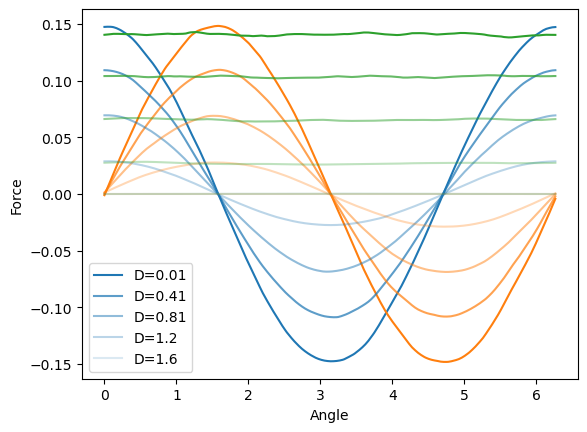

In [157]:
for i in range(0,130,30):
    plt.plot(alphas,deltas_a2[:,i,2]*norm_v, c=f'C{i}', alpha=((200-i)/200)**2, label=f'D={dist[i]:.2g}');
    plt.plot(alphas,deltas_a2[:,i,3]*norm_v, c=f'C{i+1}', alpha=((200-i)/200)**2);
    plt.plot(alphas,((deltas_a2[:,i,2:])**2).sum(-1).sqrt()/norm_v, c=f'C{i+2}', alpha=((200-i)/200)**2);
plt.legend();plt.xlabel('Angle'); plt.ylabel('Force');

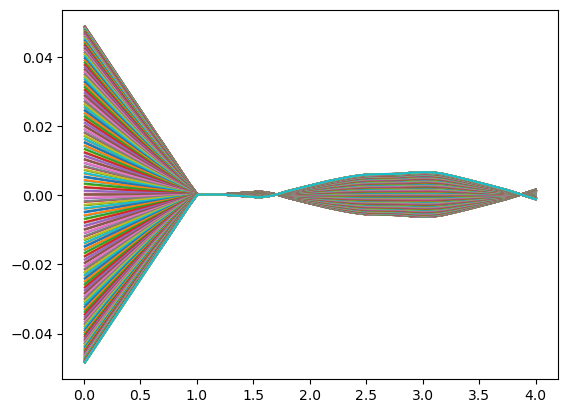

In [158]:
plt.plot(dist,transformed_X.reshape(300,300,2)[:,:,0].T*norm_v);

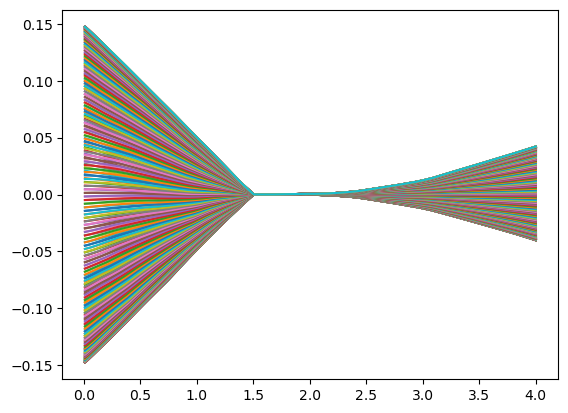

In [159]:
plt.plot(dist,deltas_a2[:,:,2].T*norm_v);

The force magnitude has no dependency of the angle.

## Force functional form from test samples messages

for all test inputs:
put msg homogenous to np.dot with A and A2.
Then, multiply by edge prediction.

In [160]:
edge_feats_test_ = edge_feats_test.transpose(1,2)[:, :-1]

In [161]:
node_feats_test_ = node_feats_test[:,:,1:].transpose(1,2)

In [162]:
params['data_path']

'data/synth3_21_/'

In [163]:
test_data = SmallSynthDataPyG(params['data_path'], 'test', params)
edges_true = test_data.edges
edge_feats_batch = Batch.from_data_list(test_data.datalist,follow_batch=['edge_feats']).edge_feats_batch
edges_b, mask = to_dense_batch(edges,edge_feats_batch)
edges_true_ = edges_true[:,:].long().cpu()
edges_pred  = edges_b.argmax(dim=-1).long().transpose(1,-1).cpu()

Using given norm


In [164]:
edges.shape, edges_b.shape

(torch.Size([840000, 49, 3]), torch.Size([2000, 420, 49, 3]))

In [165]:
edges_pred_onehot = F.one_hot(edges_pred)

In [166]:
node_feats_test_.shape, edge_feats_test_.shape, edges_pred.shape, edges_pred_onehot.shape

(torch.Size([2000, 49, 21, 4]),
 torch.Size([2000, 49, 420, 3]),
 torch.Size([2000, 49, 420]),
 torch.Size([2000, 49, 420, 3]))

In [167]:
edge_feats_test_.device, next(model.parameters()).device

(device(type='cuda', index=0), device(type='cpu'))

In [168]:
edge_feats_test_ = edge_feats_test_.cpu()

In [169]:
#  get messages from edge_feats_test
msg = [torch.zeros(*edge_feats_test_.shape[:-1],len(model.decoder.edge_functions)),
       torch.zeros(*edge_feats_test_.shape[:-1],len(model.decoder.edge_functions))]
msg_homo = [torch.zeros(np.prod(edge_feats_test_.shape[:-1]),len(model.decoder.edge_functions)+1),
            torch.zeros(np.prod(edge_feats_test_.shape[:-1]),len(model.decoder.edge_functions)+1)]
msg_transf =[0,0]
msg_f = [0,0]
with torch.no_grad():
    # msg_norm = 1
    for i in trange(len(model.decoder.edge_functions)):
        msg[i] = model.decoder.edge_functions[i](edge_feats_test_[...,0:1])*edge_feats_test_[...,1:]
        msg[i] = msg[i].reshape(-1,2)
        # Add a column of ones to X for the bias term
        msg_homo[i] = torch.hstack((msg[i], torch.ones((msg[i].shape[0], 1),device=msg[i].device)))
        # Apply the linear transformation to X
        msg_transf[i] = np.dot(msg_homo[i].detach().cpu(), A_[i]).reshape(*edge_feats_test_.shape[:-1],len(model.decoder.edge_functions))

        msg_f[i] = msg_transf[i]*edges_pred_onehot[...,i+1,None].numpy()
torch.cuda.empty_cache()

  0%|          | 0/2 [00:00<?, ?it/s]

In [170]:
msg_f[0].shape, edge_feats_test_.shape, edges_pred.shape

((2000, 49, 420, 2),
 torch.Size([2000, 49, 420, 3]),
 torch.Size([2000, 49, 420]))

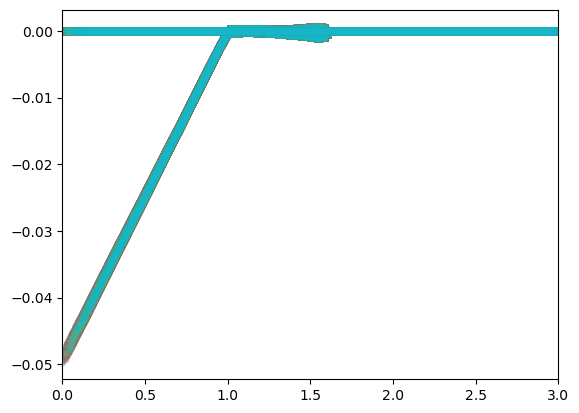

In [171]:
for i in range(edge_feats_test_.shape[2]):
    # know the sign by the product of the force and the distance versors
    p  = msg_f[0][:,:,i]*edge_feats_test_[...,i,1:].cpu().numpy()
    # take the max to avoid floating point errors bw components
    ps = np.take_along_axis(np.sign(p), np.argmax(np.abs(p), axis=-1,keepdims=True), axis=-1).reshape(-1)
    plt.plot(
         edge_feats_test_  [...,i,0:1].reshape(-1,1).cpu().numpy()*norm,
         ps*np.hypot(*msg_f[0][:,:,i].reshape(-1,2).T)*norm_v,
         '+',alpha=0.1,
        );
plt.xlim(0,3);

In [172]:
# edges contributing to message_0
msg_f0_idx = np.unique(np.nonzero(msg_f[0]>0.01)[2]); msg_f0_idx

array([ 13,  14,  15,  16,  17,  18,  19,  26,  33,  34,  35,  36,  37,
        38,  39,  41,  53,  54,  55,  56,  57,  58,  59,  64,  73,  74,
        75,  76,  77,  78,  79,  93,  94,  95,  96,  97,  98,  99, 105,
       113, 114, 115, 116, 117, 118, 119, 133, 134, 135, 136, 137, 138,
       139])

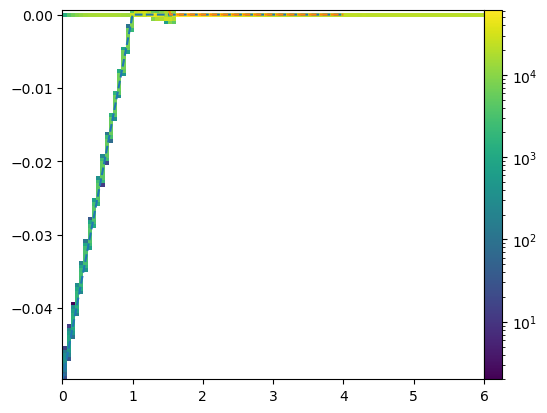

In [173]:
i=msg_f0_idx #49
p  = msg_f[0][:,:,i]*edge_feats_test_[...,i,1:].cpu().numpy()
ps = np.take_along_axis(np.sign(p), np.argmax(np.abs(p), axis=-1,keepdims=True), axis=-1).reshape(-1)

plt.hist2d(
     edge_feats_test_  [...,i,0:1].reshape(-1).cpu().numpy()*norm,
     ps*np.hypot(*msg_f[0][:,:,i].reshape(-1,2).T)*norm_v,
    100, range=[[0,6],None], norm='log',
    );
plt.plot(d_,-dv_theo1, '--', label='Attractive');
plt.plot(d_,dv_theo15, '--',label='Repulsive');
plt.colorbar(pad=0);

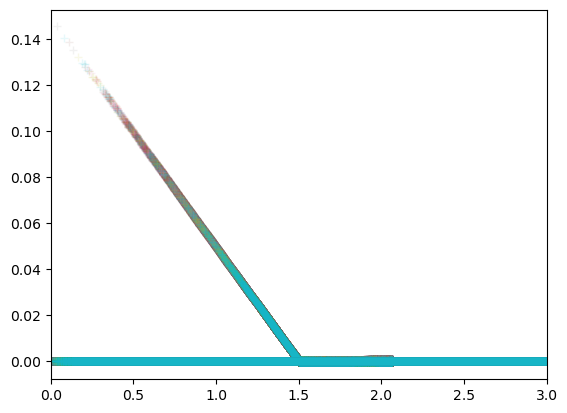

In [724]:
# message*edge_pred
for i in range(edge_feats_test_.shape[2]): # edges
    p  = msg_f[1][:,:,i]*edge_feats_test_[...,i,1:].cpu().numpy()
    ps = np.take_along_axis(np.sign(p), np.argmax(np.abs(p), axis=-1,keepdims=True), axis=-1).reshape(-1)

    plt.plot(
         edge_feats_test_  [...,i,0:1].reshape(-1,1).cpu().numpy()*norm,
         ps*np.hypot(*msg_f[1][:,:,i].reshape(-1,2).T)*norm_v,
          '+', alpha=0.1
        );
plt.xlim(0,3);

In [174]:
# edges contributing to message_0
msg_f1_idx = np.unique(np.nonzero(msg_f[1]<-0.01)[2]); msg_f1_idx

array([153, 154, 155, 156, 157, 158, 159, 168, 172, 173, 174, 175, 176,
       177, 178, 179, 193, 194, 195, 196, 197, 198, 199, 213, 214, 215,
       216, 217, 218, 219, 227, 233, 234, 235, 236, 237, 238, 239, 253,
       254, 255, 256, 257, 258, 259, 268, 273, 274, 275, 276, 277, 278,
       279])

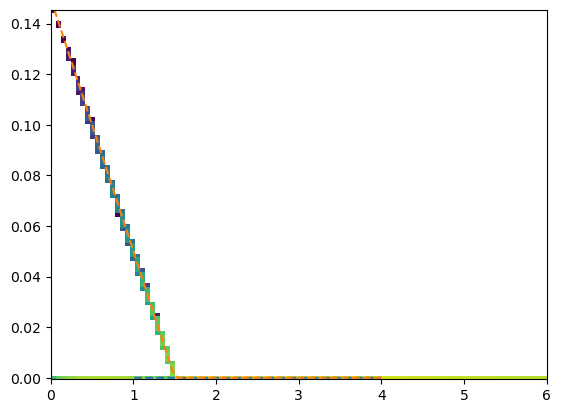

In [175]:
i=msg_f1_idx
p  = msg_f[1][:,:,i]*edge_feats_test_[...,i,1:].cpu().numpy()
ps = np.take_along_axis(np.sign(p), np.argmax(np.abs(p), axis=-1,keepdims=True), axis=-1).reshape(-1)
plt.hist2d(
     edge_feats_test_  [...,i,0:1].reshape(-1).cpu().numpy()*norm,
     ps*np.hypot(*msg_f[1][:,:,i].reshape(-1,2).T)*norm_v,
    100, range=[[0,6],None], norm='log'
    );
plt.plot(d_,-dv_theo1, '--', label='Attractive');
plt.plot(d_,dv_theo15, '--',label='Repulsive');

In [176]:
torch.cuda.empty_cache()

## clean plot

In [233]:
params['data_path']

'../data/raw/synth3_21/'

In [860]:
np.savez_compressed("draft/synth3_21"+"_forces_msg", # edges and msg from test set
                    edges_pred=edges_pred,
                    model_skip_first=model.skip_first,
                    msg_transf=msg_transf, edge_feats_test_=edge_feats_test_,
                    delta_t = ds_train.delta_t,
                    norm=norm, norm_v=norm_v # norm of model's training dataset
                   )

In [271]:
with np.load("draft/synth3_21"+"_forces_msg"+".npz") as fm:
    edges_pred=fm['edges_pred']
    model_skip_first=fm['model_skip_first']
    msg_transf=fm['msg_transf']
    edge_feats_test_=fm['edge_feats_test_']
    delta_t = fm['delta_t']
    norm=fm['norm']
    norm_v=fm['norm_v']

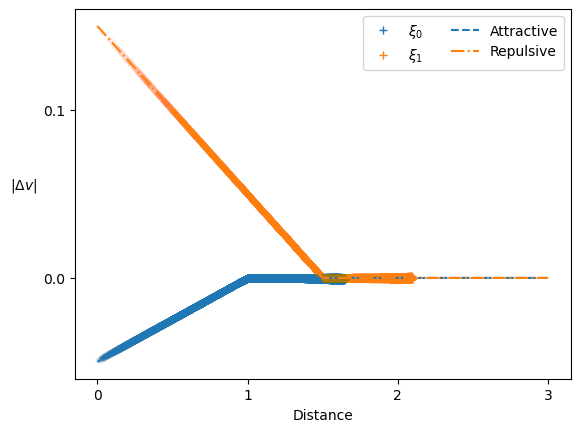

In [273]:
# save/load edges_pred, model.skip_first, msg_transf, edge_feats_test_, norm, norm_v
for i in range(len(msg_transf)):
    mask = edges_pred==model_skip_first+i
    p  = msg_transf[i][mask]*edge_feats_test_[mask][:,1:]
    ps = np.take_along_axis(np.sign(p), np.argmax(np.abs(p), axis=-1,keepdims=True), axis=-1).reshape(-1)
    plt.plot(edge_feats_test_  [mask][:,0]*norm,
             ps*np.hypot(*msg_transf[i][mask].T)*norm_v,'+',
             alpha=0.01,c=f'C{i}', label=fr'$\xi_{i}$');
k=0.05;  d_=np.linspace(0,3,61)
dv_theo1 = -np.maximum(0,k*(1-d_))
plt.plot(d_,dv_theo1, '--', label='Attractive');
dv_theo15 = np.maximum(0,2*k*(1.5-d_))
plt.plot(d_,dv_theo15, '-.',label='Repulsive');

plt.xlabel('Distance'); plt.ylabel(r'$\Delta v$', rotation=0, ha='right');
leg = plt.legend(ncol=2);
for lh in leg.legend_handles:    lh.set_alpha(1)
plt.gca().locator_params(nbins=4);